# **Created by Karit Sookpreedee**
(Updated 3 June 2024)

<img src="./overview.png" alt="PNG Image" />

In [1]:
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
import numpy as np
from numpy.fft import fft, ifft
from numpy.fft import fftshift
from numpy.fft import ifftshift
import matplotlib as mpl
from scipy import signal
from scipy.io import wavfile
import IPython.display as ipd
from scipy.signal import butter, lfilter, freqz

In [2]:
mpl.rcParams['figure.dpi'] = 300
sns.set_theme()
sns.set_style("ticks")

# 0. Loading Audio Samples


In [3]:
sample_rate, data = wavfile.read('./Jungle-SoundBible.com-1211567897.wav')

print(f"data (2 channels) = {data}")
print(f"data shape = {data.shape}")
print(f"sample_rate = {sample_rate}")

# we use only one of the channels
data = data[:,0]
print(f"data (1 channel) = {data}")

data (2 channels) = [[-1  0]
 [ 1  0]
 [ 0 -1]
 ...
 [ 1  0]
 [ 0  1]
 [-1 -1]]
data shape = (119808, 2)
sample_rate = 22050
data (1 channel) = [-1  1  0 ...  1  0 -1]


In [4]:
number_of_samples = len(data) #N
length_in_seconds = len(data)/sample_rate #T_0 = N/f_s
print("number of samples:", number_of_samples)
print("length in seconds:", length_in_seconds)
print("samples per second:", sample_rate)

number of samples: 119808
length in seconds: 5.433469387755102
samples per second: 22050


In [5]:
ipd.Audio(data, rate = sample_rate) # load a local WAV file

# 1. Visualise audio signal

## 1.1. Plot time series

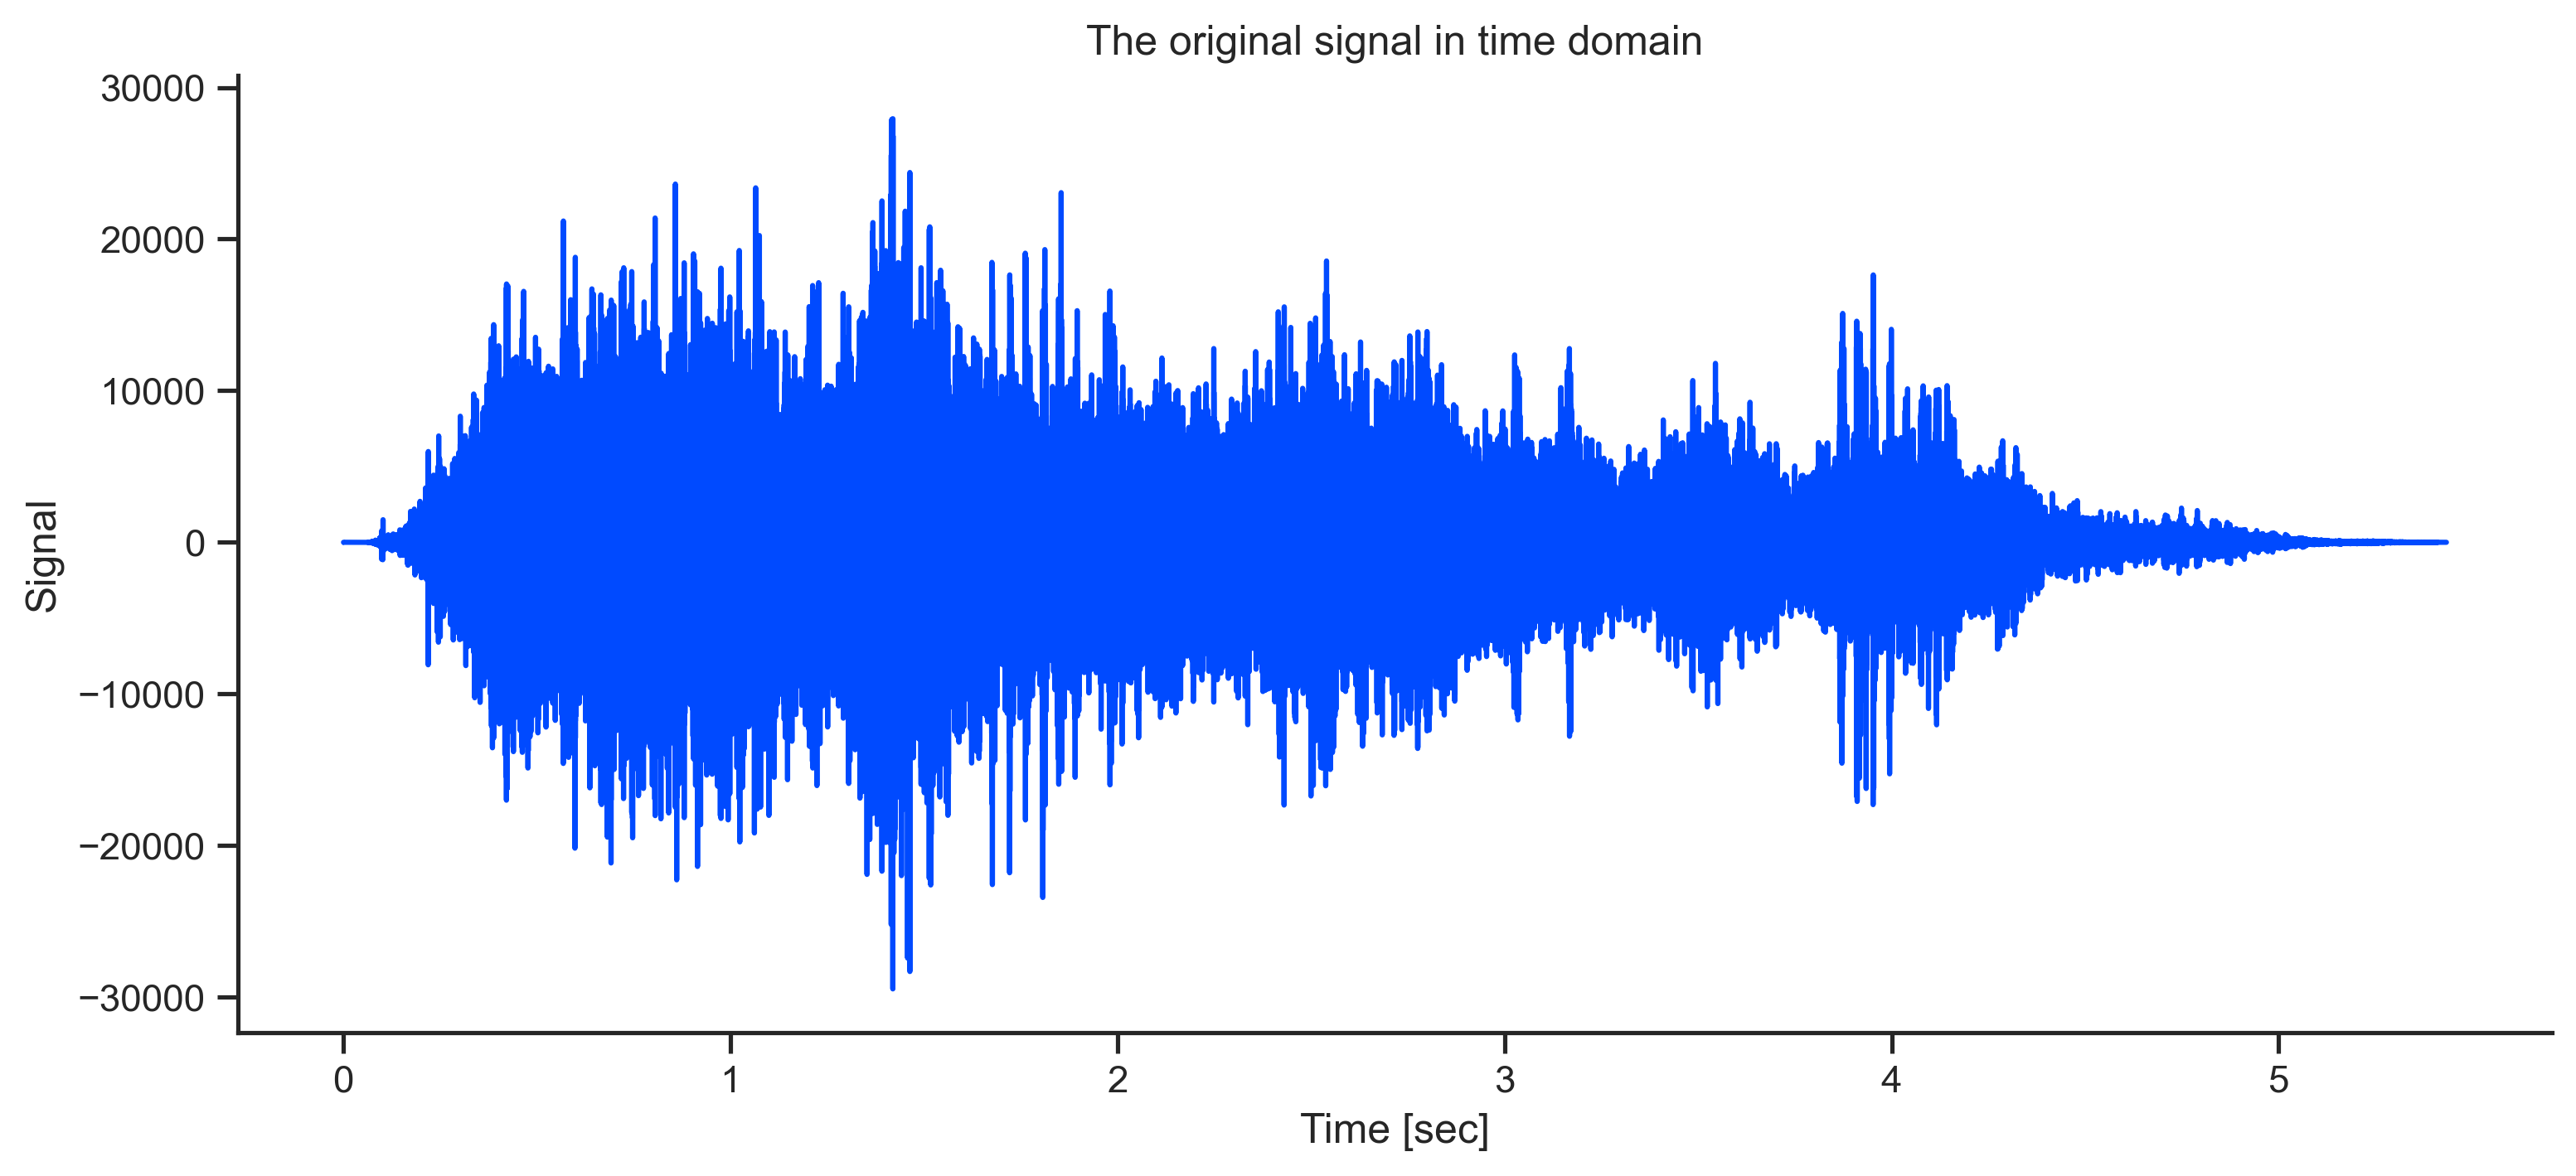

In [39]:
x = np.arange(number_of_samples) / sample_rate # n/f_s = nT_s

plt.figure(figsize=(12, 5))
plt.plot(x, data, color = "#004AFF")
plt.xlabel('Time [sec]')
plt.ylabel('Signal')
plt.title("The original signal in time domain")
sns.despine()

## 1.2. Apply FFT to plot frequency spectrum

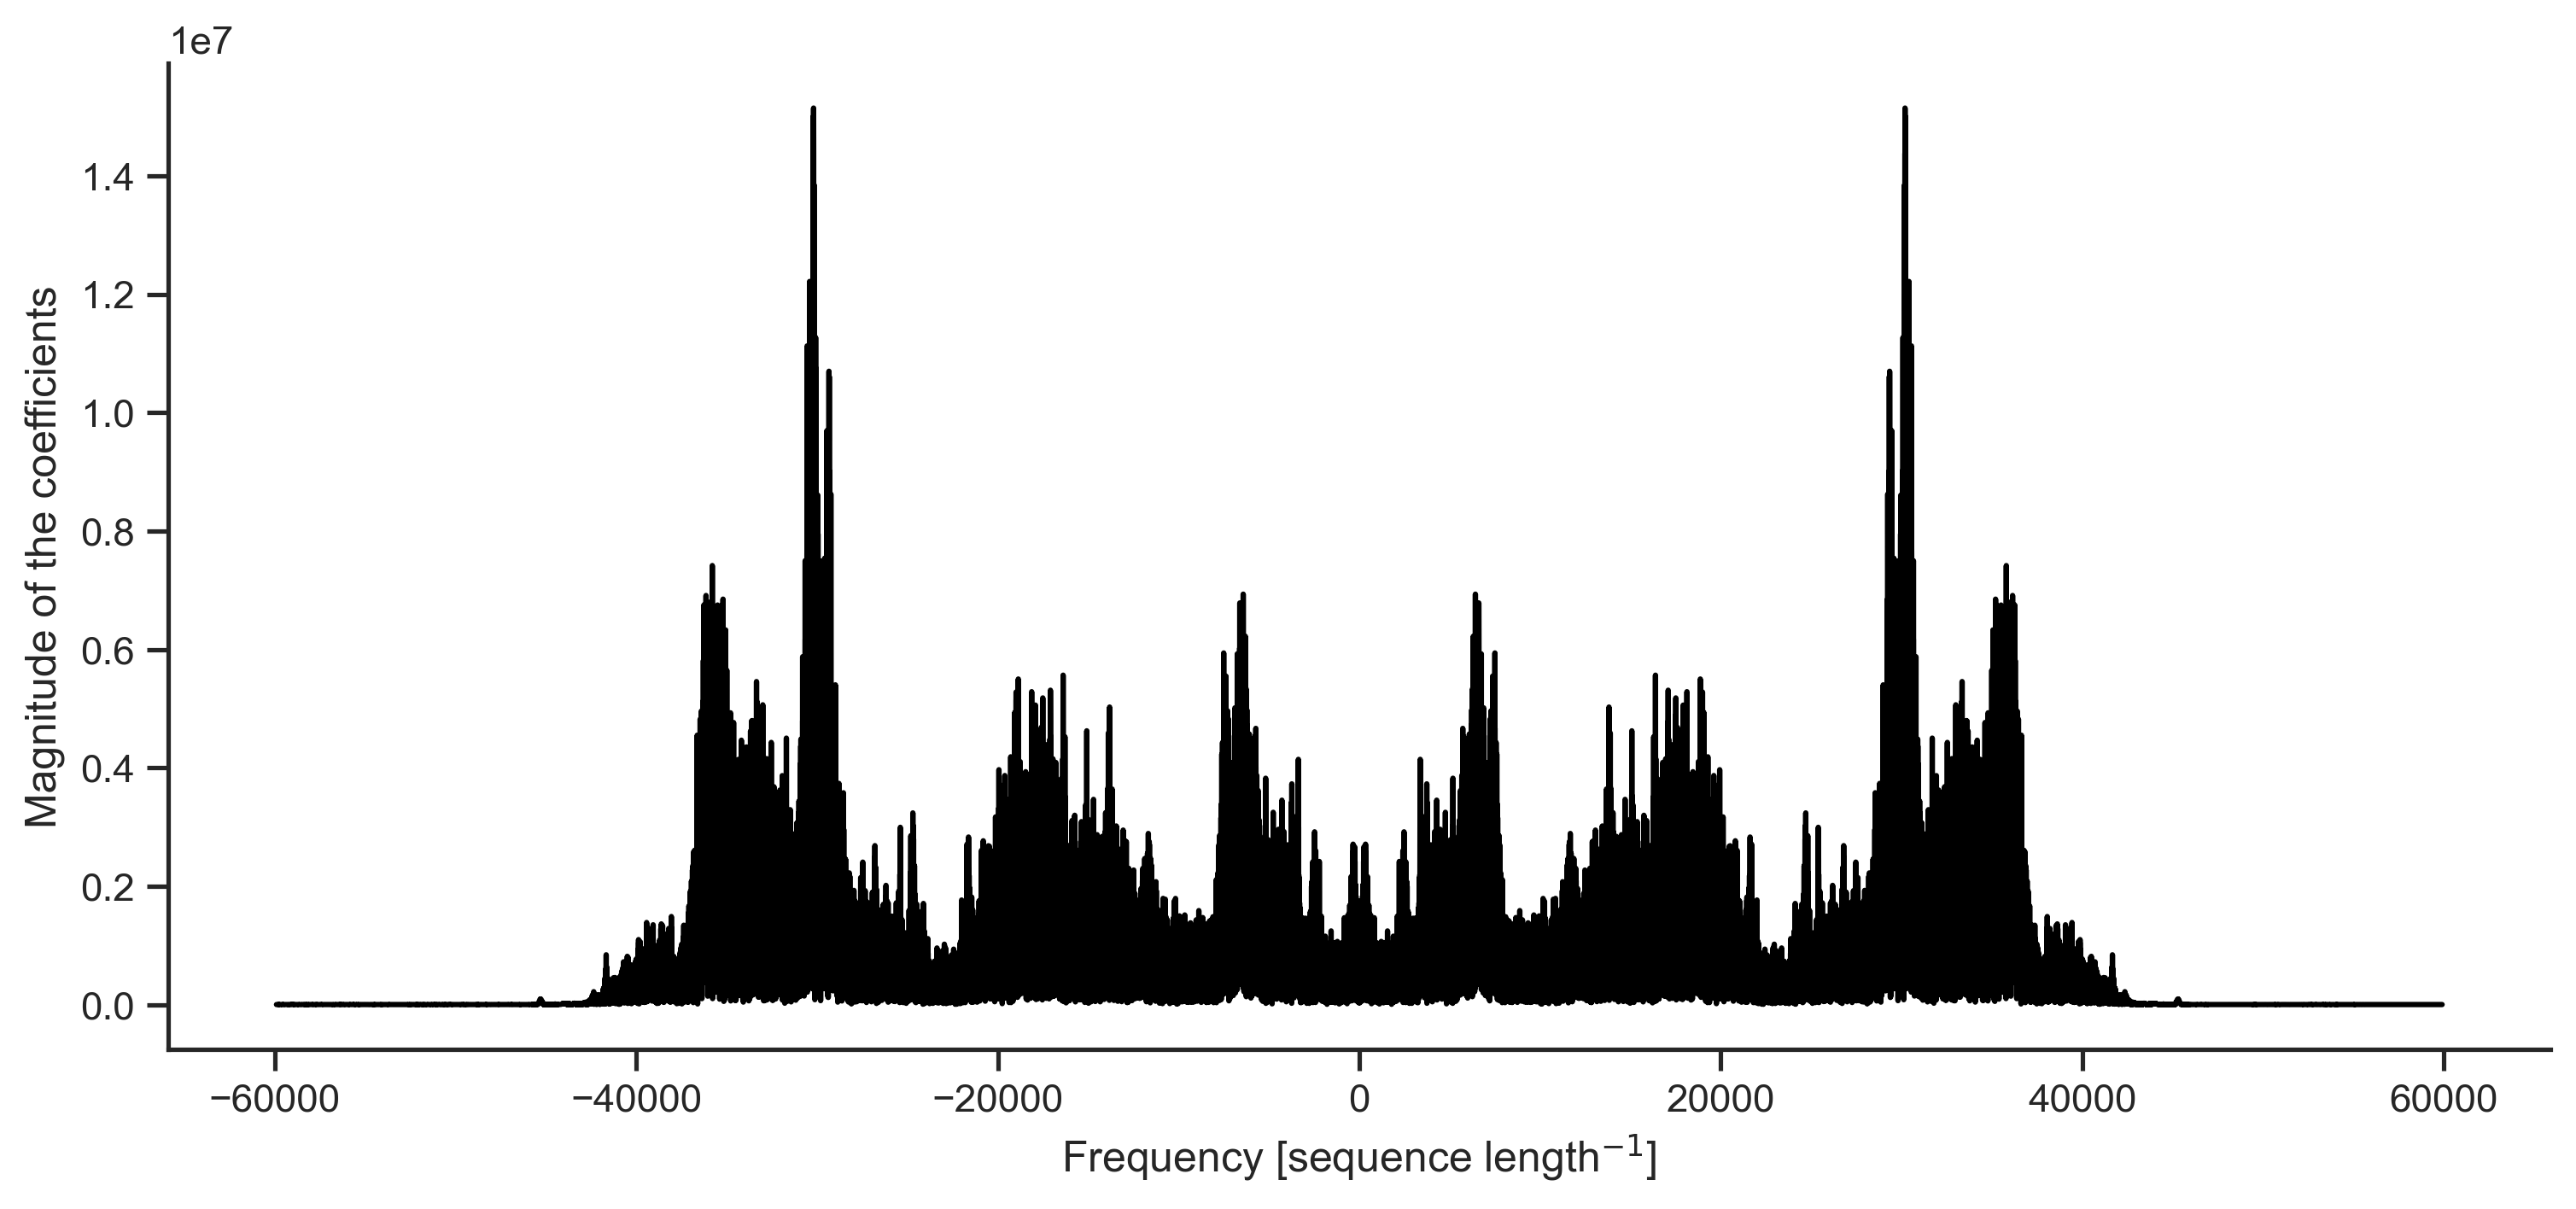

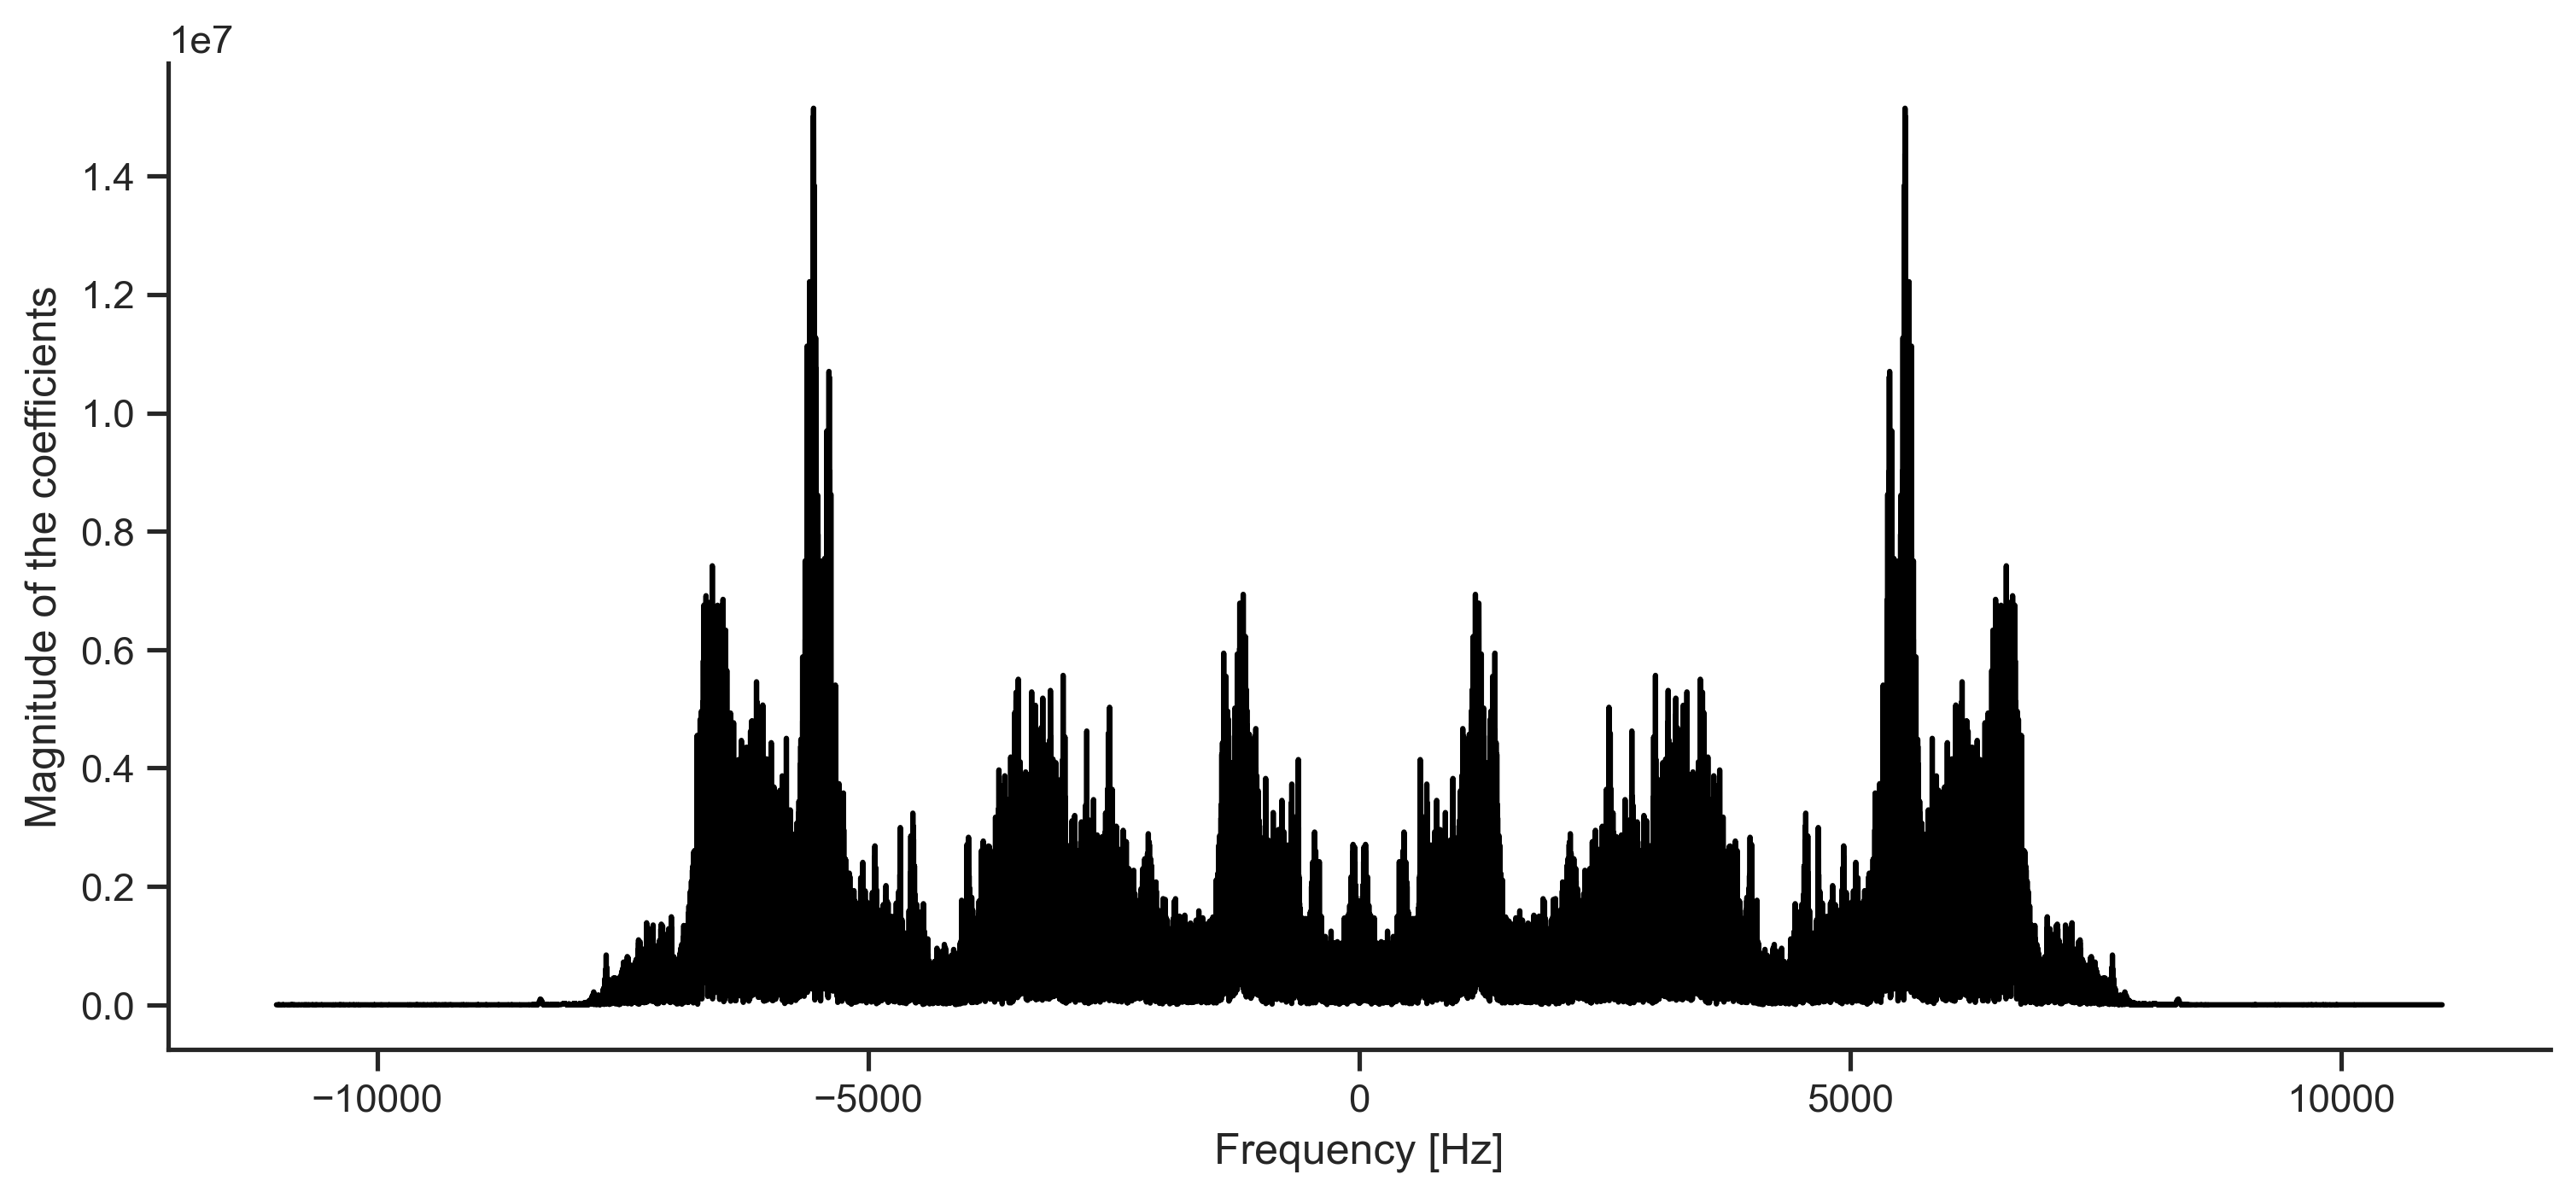

In [40]:
# We apply the FFT
data_fft = fftshift(fft(data))

# We will use this as x-axis to plot our coefficients against
freqs = np.arange(number_of_samples)

# We know that zero frequency is in the centre, so we have to subtract half the length of the array
freqs = freqs - (number_of_samples)//2

real_freqs = freqs*(sample_rate/number_of_samples)

# Lets plot the results again
plt.figure(figsize=(12, 5))
sns.lineplot(x=freqs, y=np.abs(data_fft), color = '#000000')
plt.ylabel('Magnitude of the coefficients')
plt.xlabel('Frequency [sequence length$^{-1}$]')
sns.despine()
plt.show()

plt.figure(figsize=(12, 5))
sns.lineplot(x=real_freqs, y=np.abs(data_fft), color = '#000000')
plt.ylabel('Magnitude of the coefficients')
plt.xlabel('Frequency [Hz]')
sns.despine()
plt.show()

## 1.3. Plot spectrogram

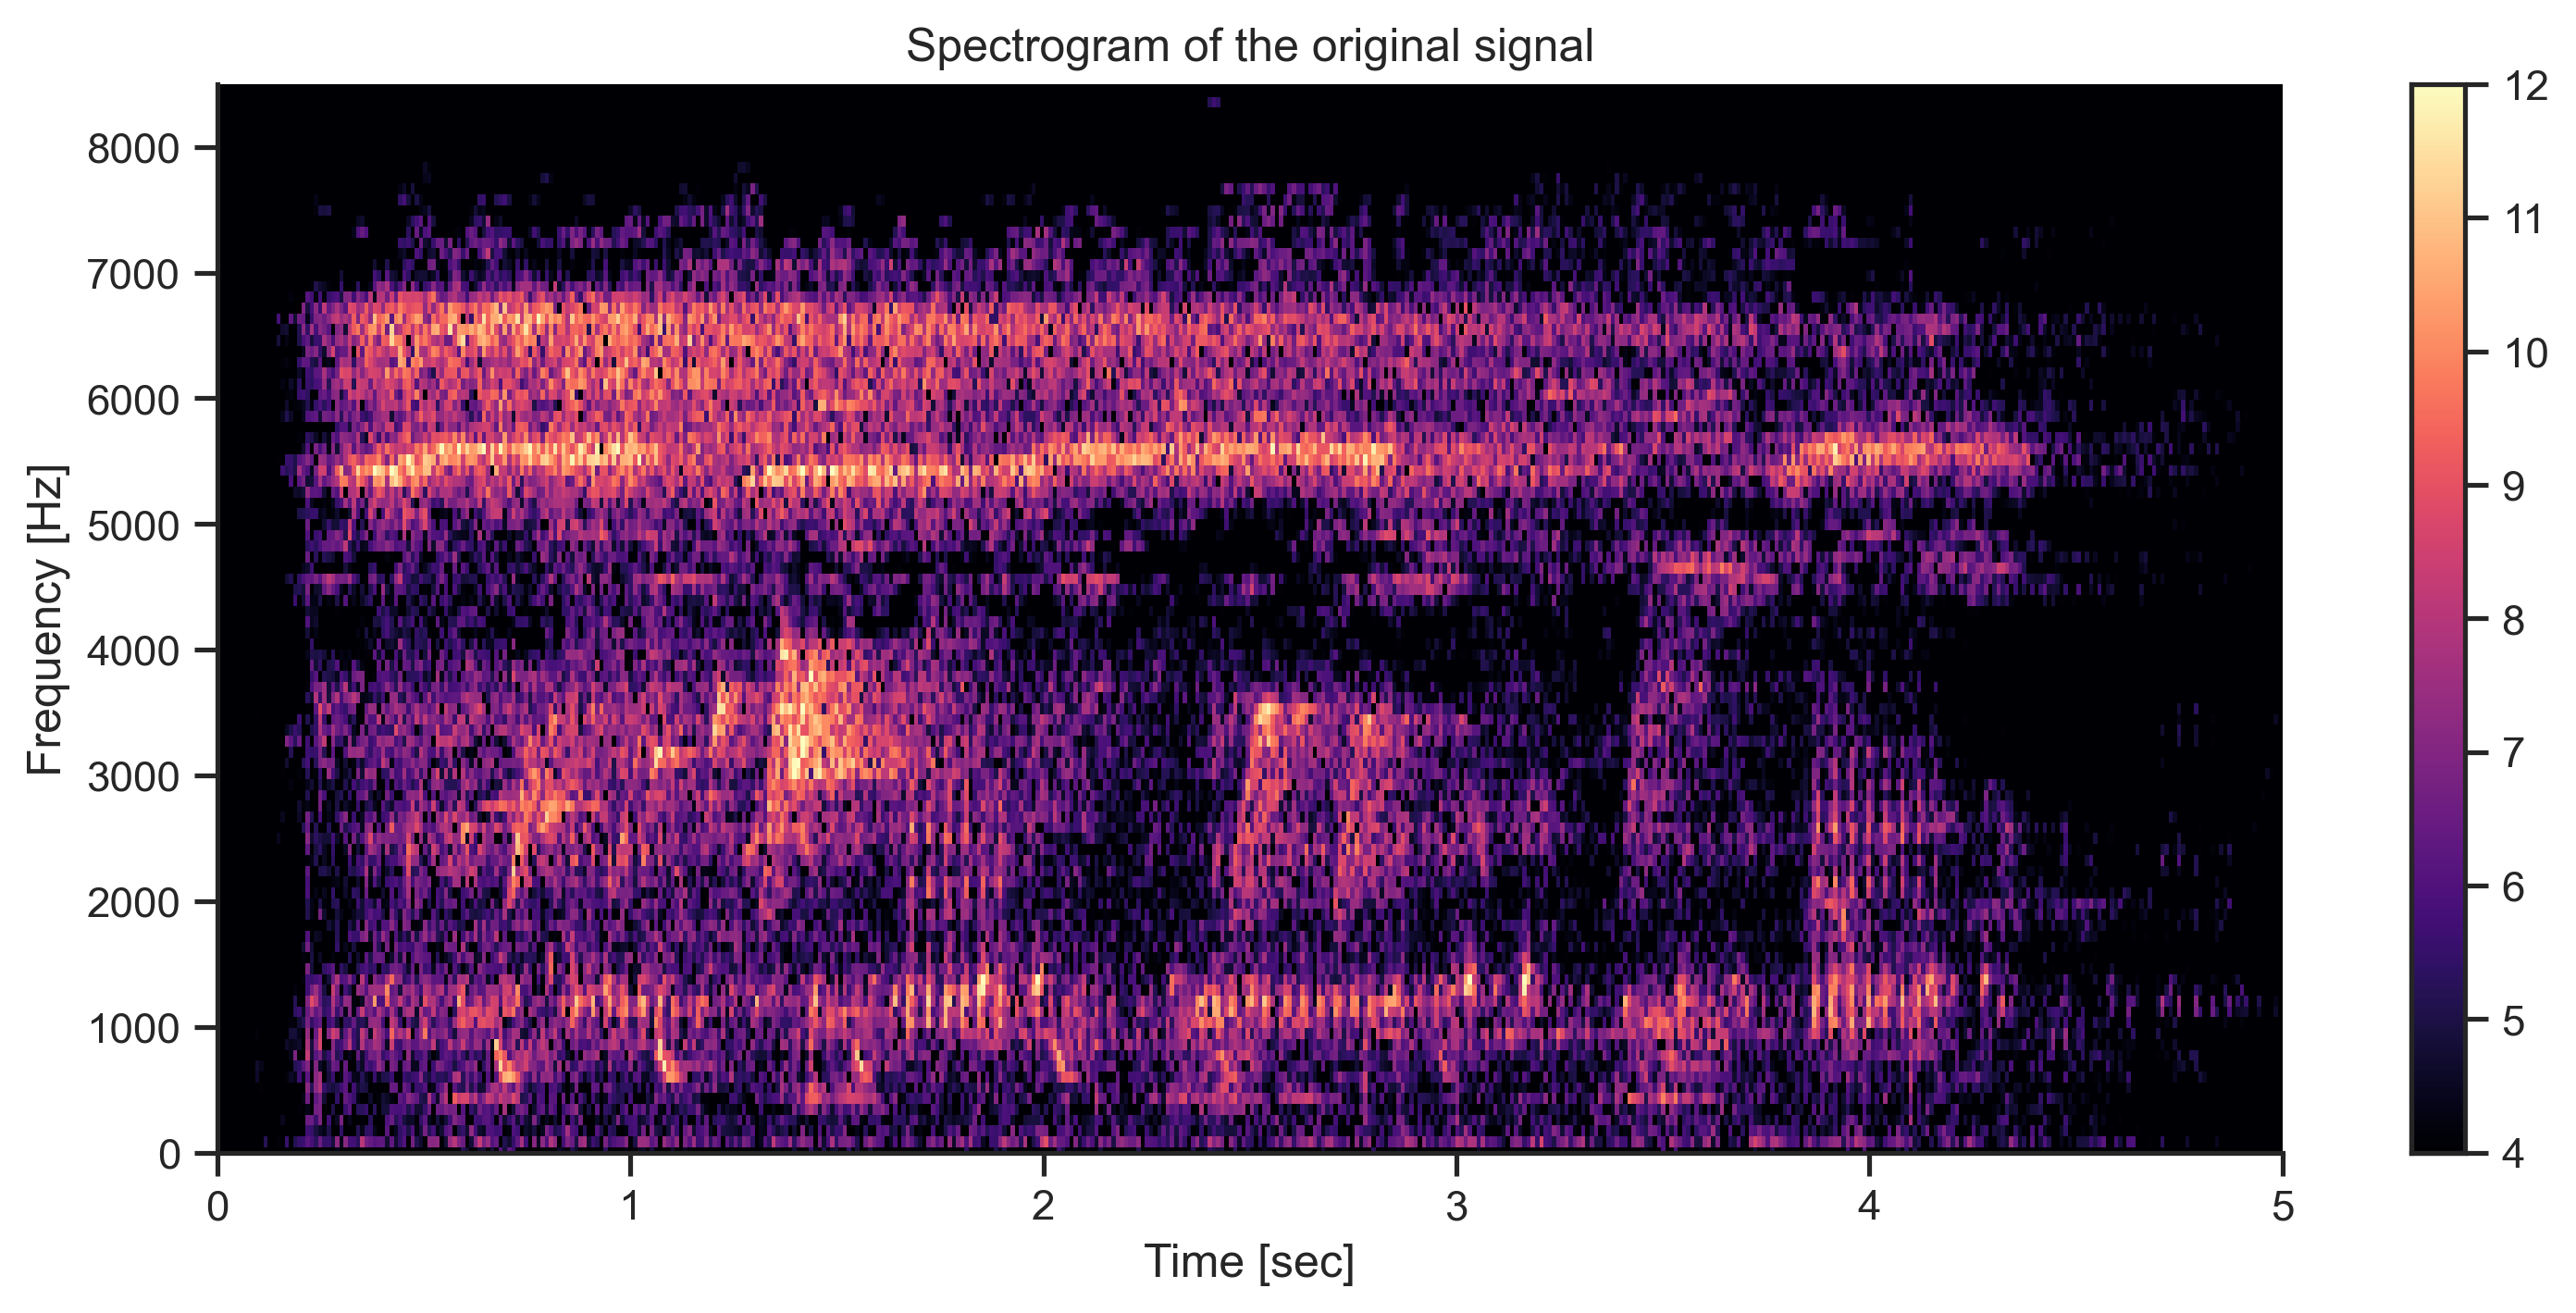

In [41]:
f, t, Sxx = signal.spectrogram(data, sample_rate)

plt.figure(figsize=(12, 5))
plt.pcolormesh(t, f, np.log(Sxx), cmap = 'magma', vmin = 4, vmax = 12)
plt.title("Spectrogram of the original signal")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.ylim(0,8500)
plt.xlim(0,5)
sns.despine()

From my inspections, 

* The range of frequencies for the first animal sound should be around 0 - 1800 Hz

* The range of frequencies for the second animal sound should be around 2000 - 4300 Hz

* The range of frequencies for the third animal sound should be around 4300 - 7700 Hz

# 2. Use boxcar filter to isolate 3 types of animal sounds


In [77]:
def get_filtered_signal(sample_rate,data,real_freqs,minf,maxf):

    # plot spectrogram
    f, t, Sxx = signal.spectrogram(data, sample_rate)
    plt.figure(figsize=(12, 5))
    plt.pcolormesh(t, f, np.log(Sxx), cmap = 'magma', vmin = 4, vmax = 12)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar()
    plt.ylim(0,8500)
    plt.xlim(0,5)

    plt.axhline(y=minf, color='#33CAFF', linestyle='--')
    plt.text(0, minf, f'{minf}', color='#33CAFF', fontsize=10, va='bottom')

    plt.axhline(y=maxf, color='#33CAFF', linestyle='--')
    plt.text(0, maxf, f'{maxf}', color='#33CAFF', fontsize=10, va='bottom')

    plt.title("Spectrogram (with interval of frequency that I want to filter)", fontsize=10)
    sns.despine()
    plt.show()

    # design filter
    weights = np.zeros(len(real_freqs))
    weights[(real_freqs > minf) & (real_freqs < maxf)] = 1.0
    weights[(real_freqs < -minf) & (real_freqs > -maxf)] = 1.0
    plt.figure(figsize=(12, 5))
    plt.plot(real_freqs, weights, color = "#33CAFF")
    plt.title("Designed boxcar filter")
    plt.ylabel('Weights')
    plt.xlabel('Frequency [Hz]')
    sns.despine()
    plt.show()

    # filtering in frequency domain
    data_fft = fftshift(fft(data))
    data_fft_filtered = data_fft*weights
    plt.figure(figsize=(12, 5))
    sns.lineplot(x = real_freqs, y = np.abs(data_fft), label = 'Original', color = "#000000")
    sns.lineplot(x = real_freqs, y = np.abs(data_fft_filtered), label = 'Filtered', color = "#33CAFF")
    plt.ylabel('Coefficients')
    plt.xlabel('Frequency [Hz]')
    sns.despine()
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.0, frameon = True)
    plt.title("Spectra in frequency domain")
    plt.show()

    # apply the inverse FFT
    data_reconstructed = ifft(ifftshift(data_fft_filtered))
    data_reconstructed = data_reconstructed.real
    plt.figure(figsize=(12, 5))  
    plt.plot(x,data, label ='Original', color = "#000000")
    plt.plot(x,data_reconstructed, label = 'Filtered', color = "#33CAFF")
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.0, frameon = True)
    plt.xlabel('Time [sec]')
    plt.ylabel('Signal')
    plt.title("Reconstructed signal in time domain")
    sns.despine()
    plt.show()

    return data_reconstructed

In [78]:
sample_rate, data = wavfile.read('./Jungle-SoundBible.com-1211567897.wav')
data = data[:,0]
freqs = np.arange(number_of_samples)
freqs = freqs - (number_of_samples)//2
real_freqs = freqs*(sample_rate/number_of_samples)

## 2.1. Isolate the first animal sound

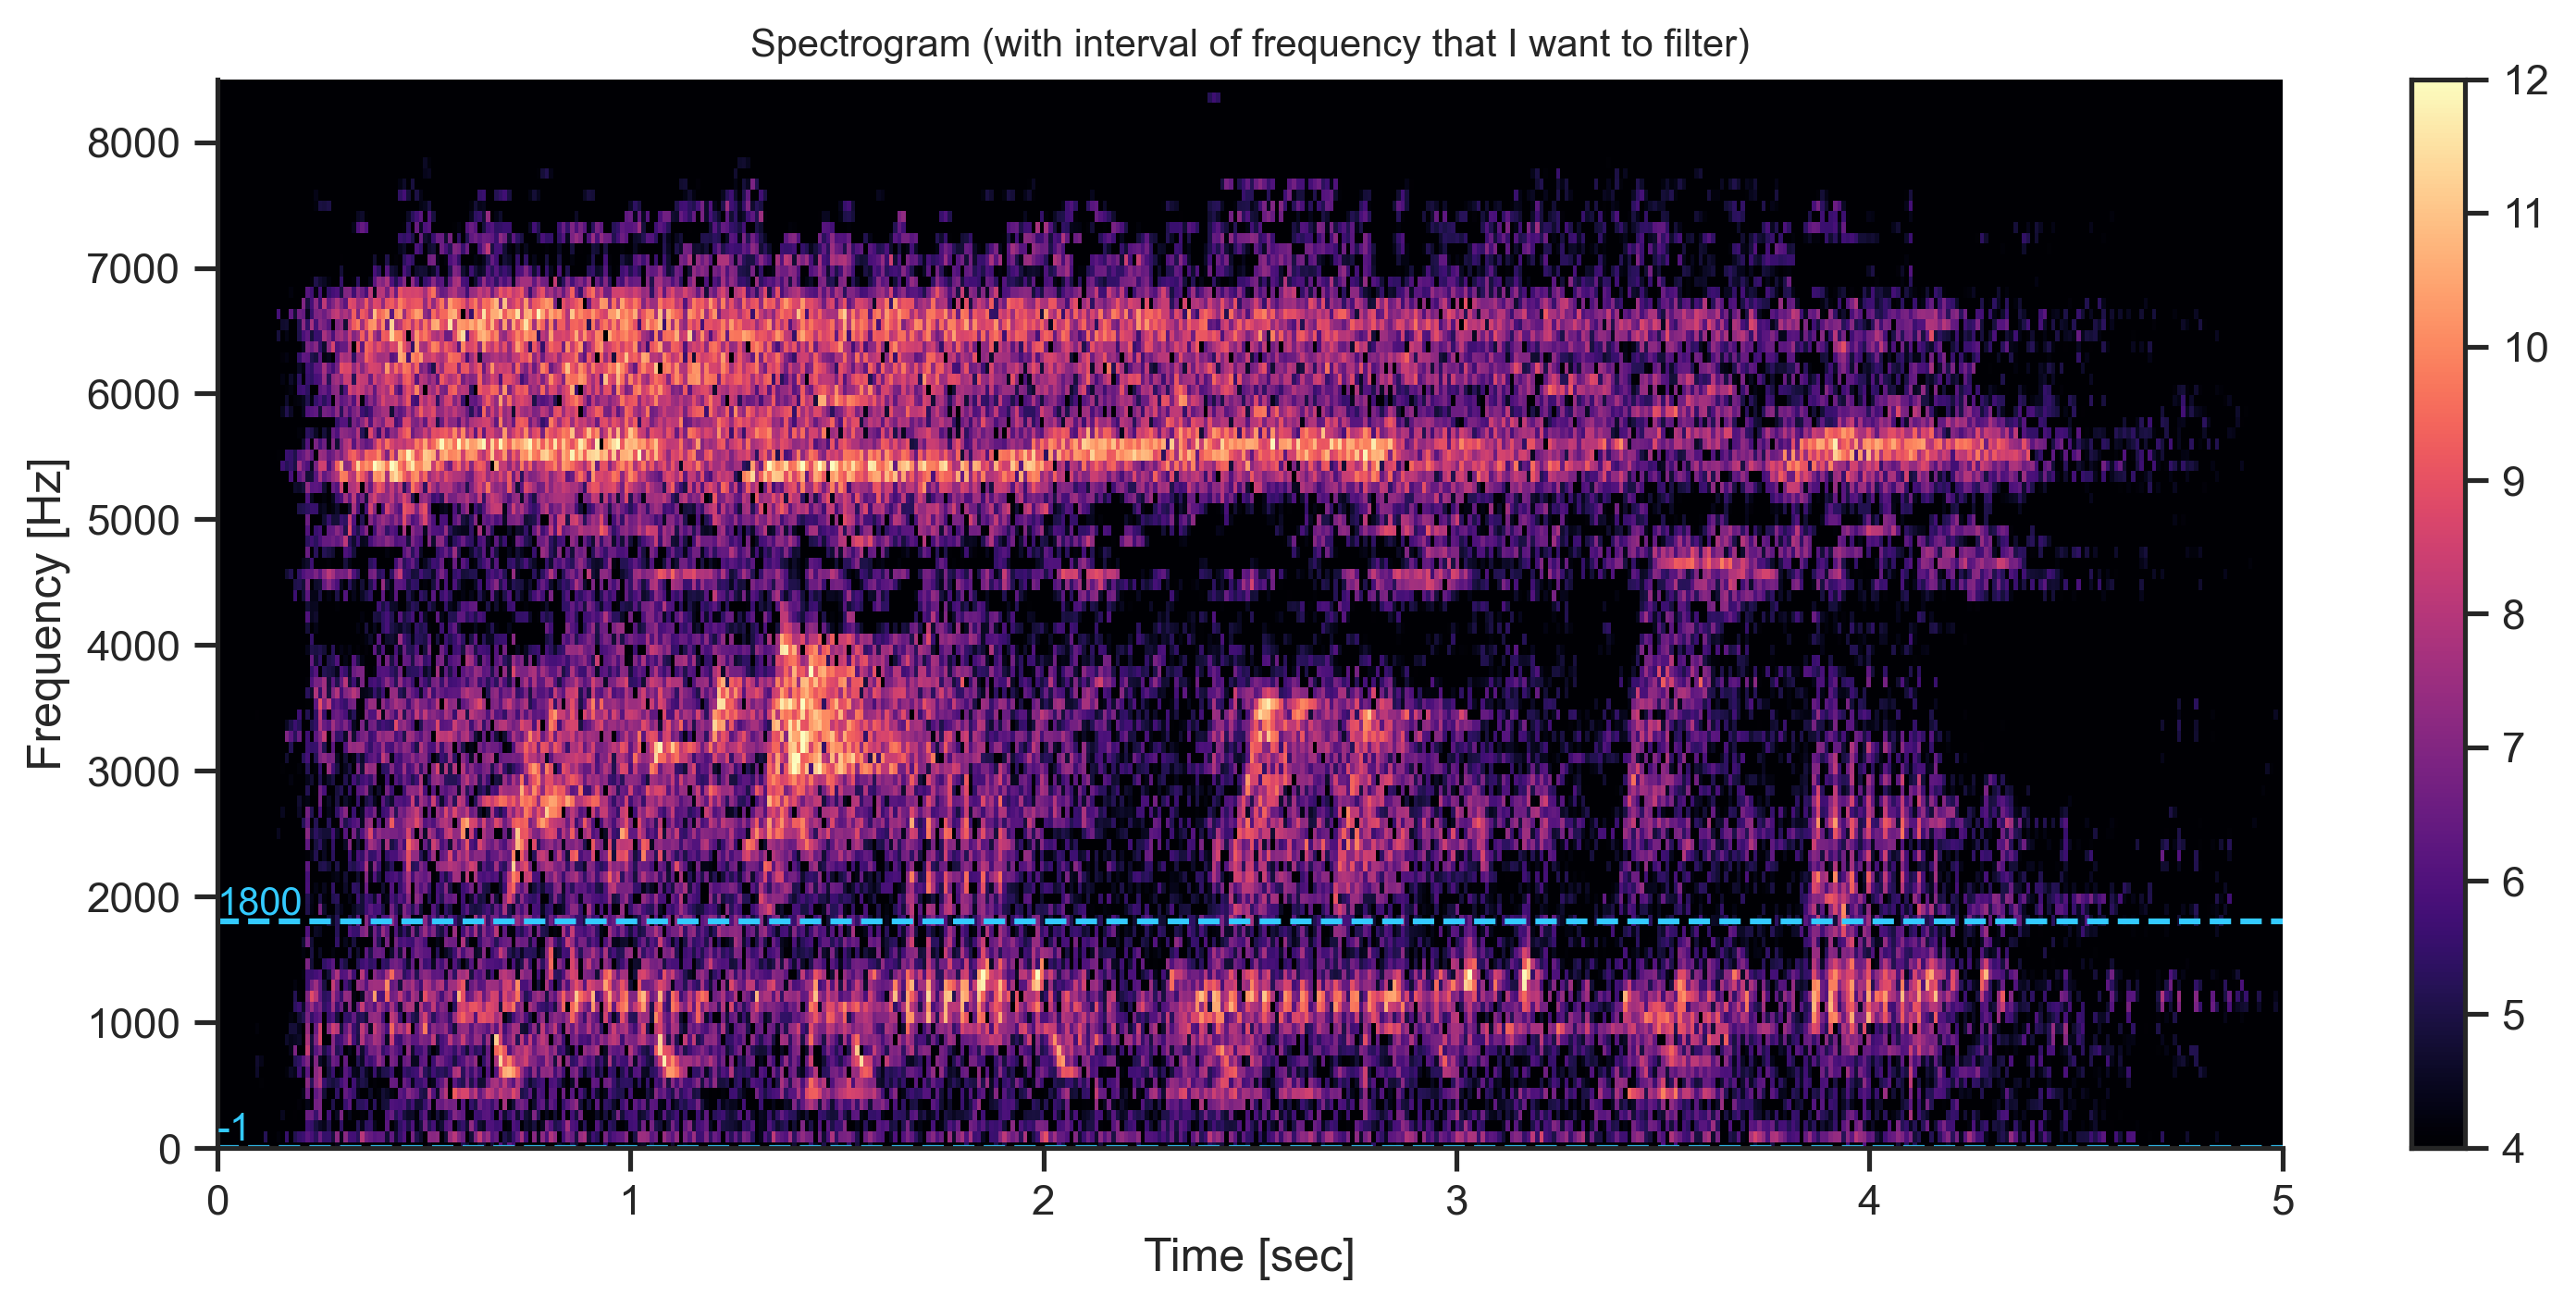

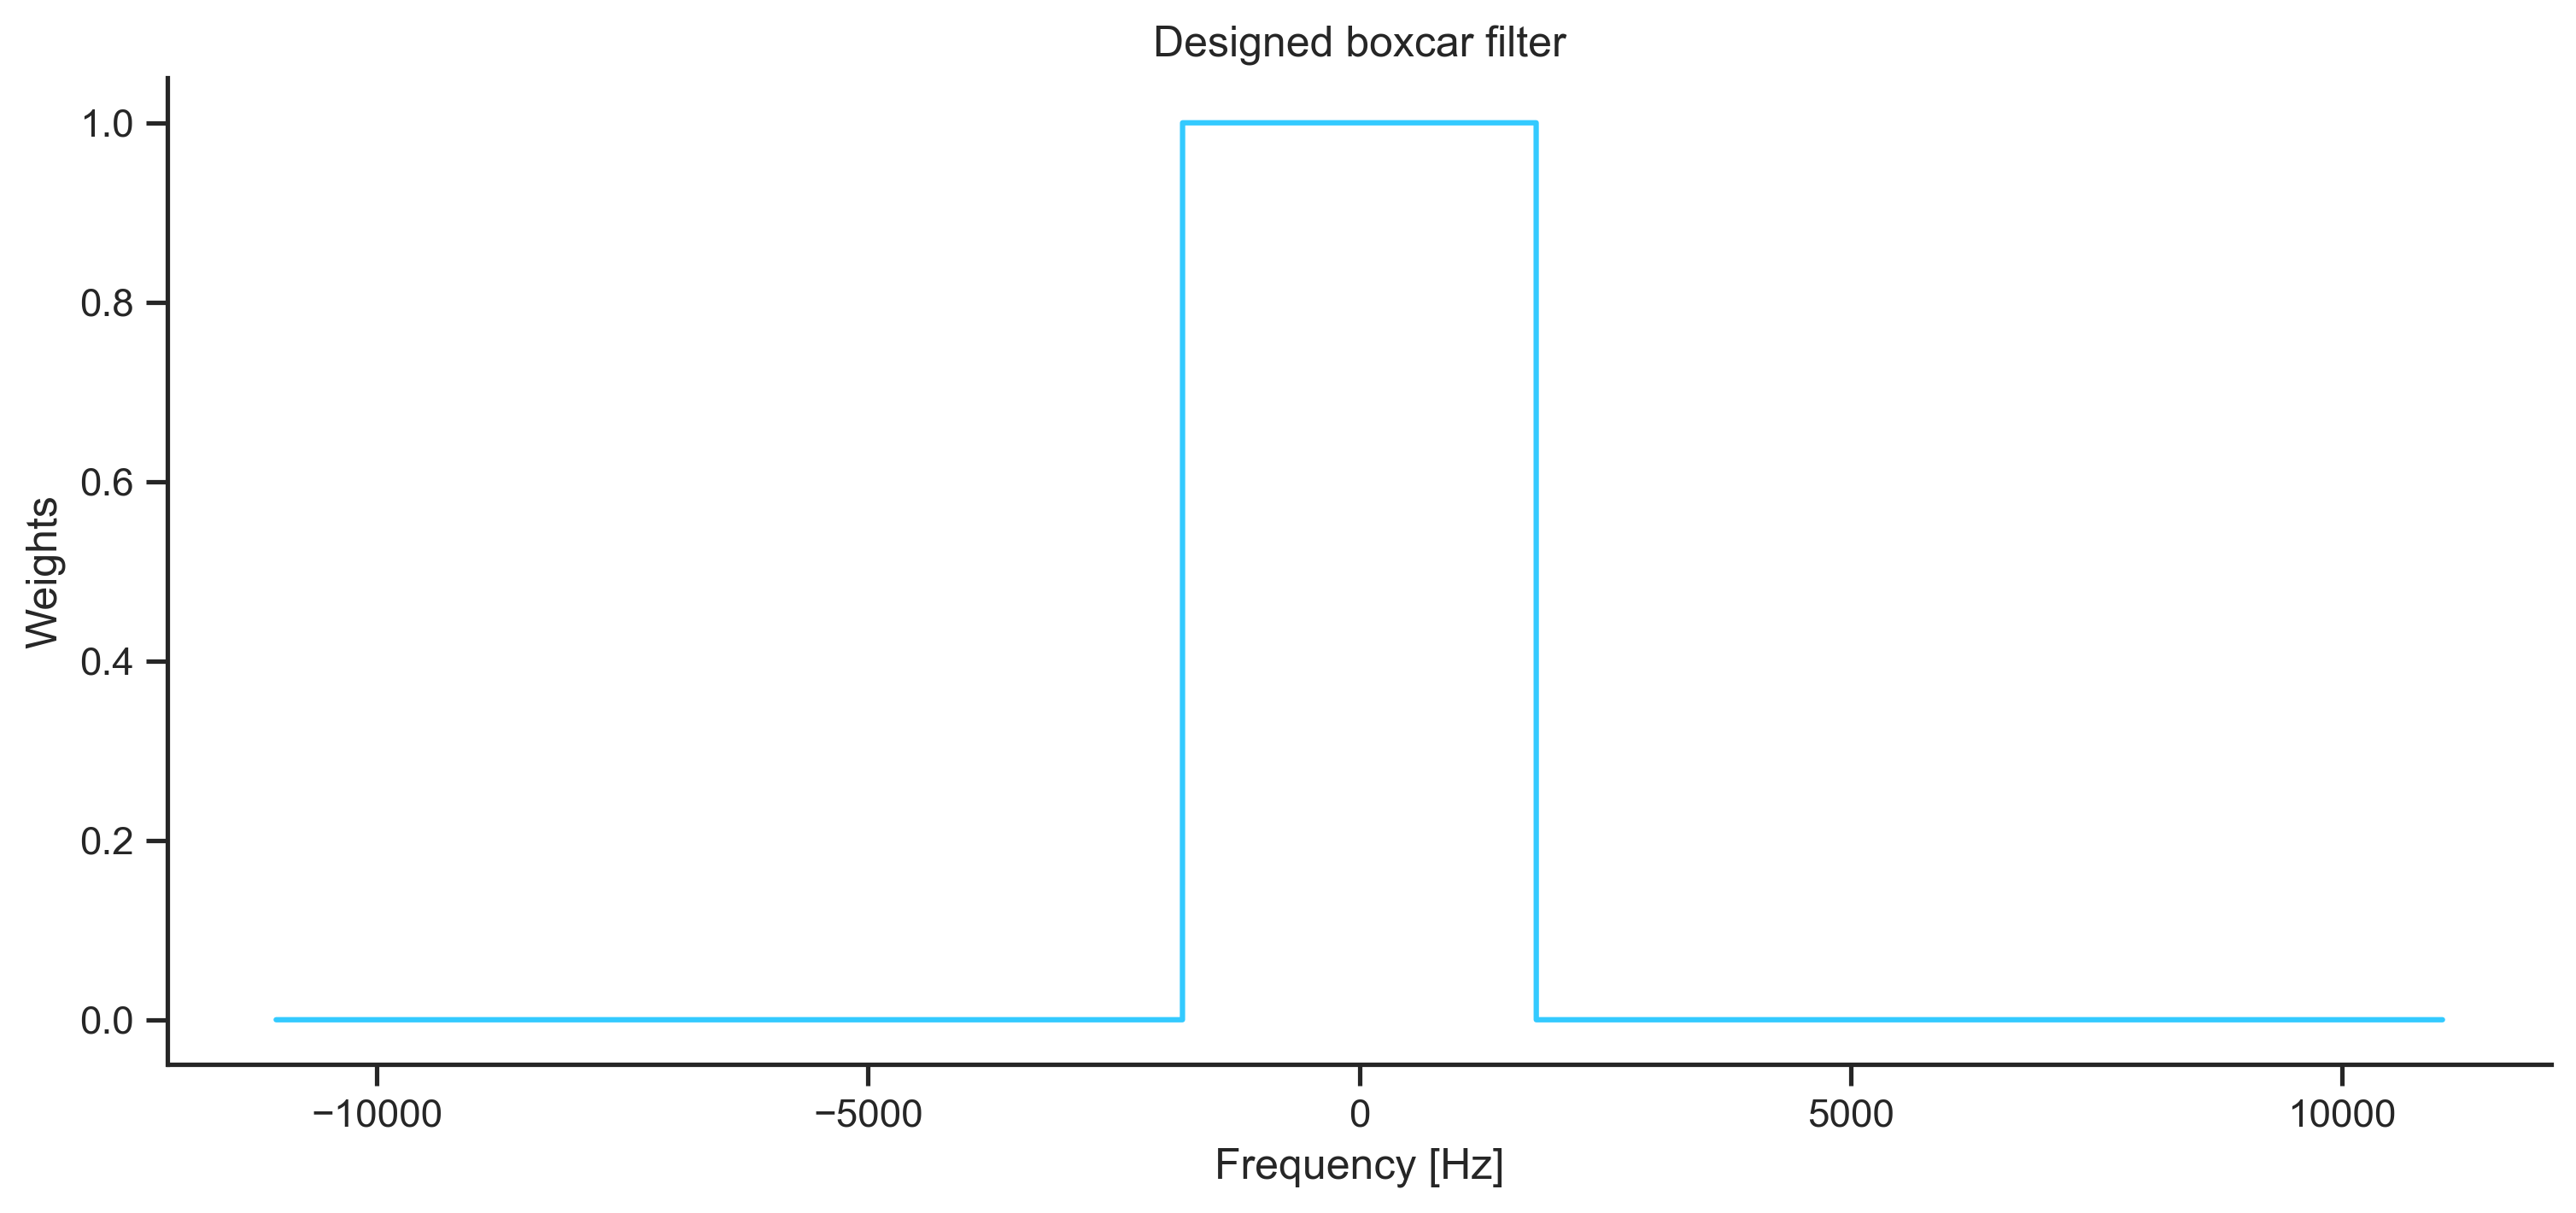

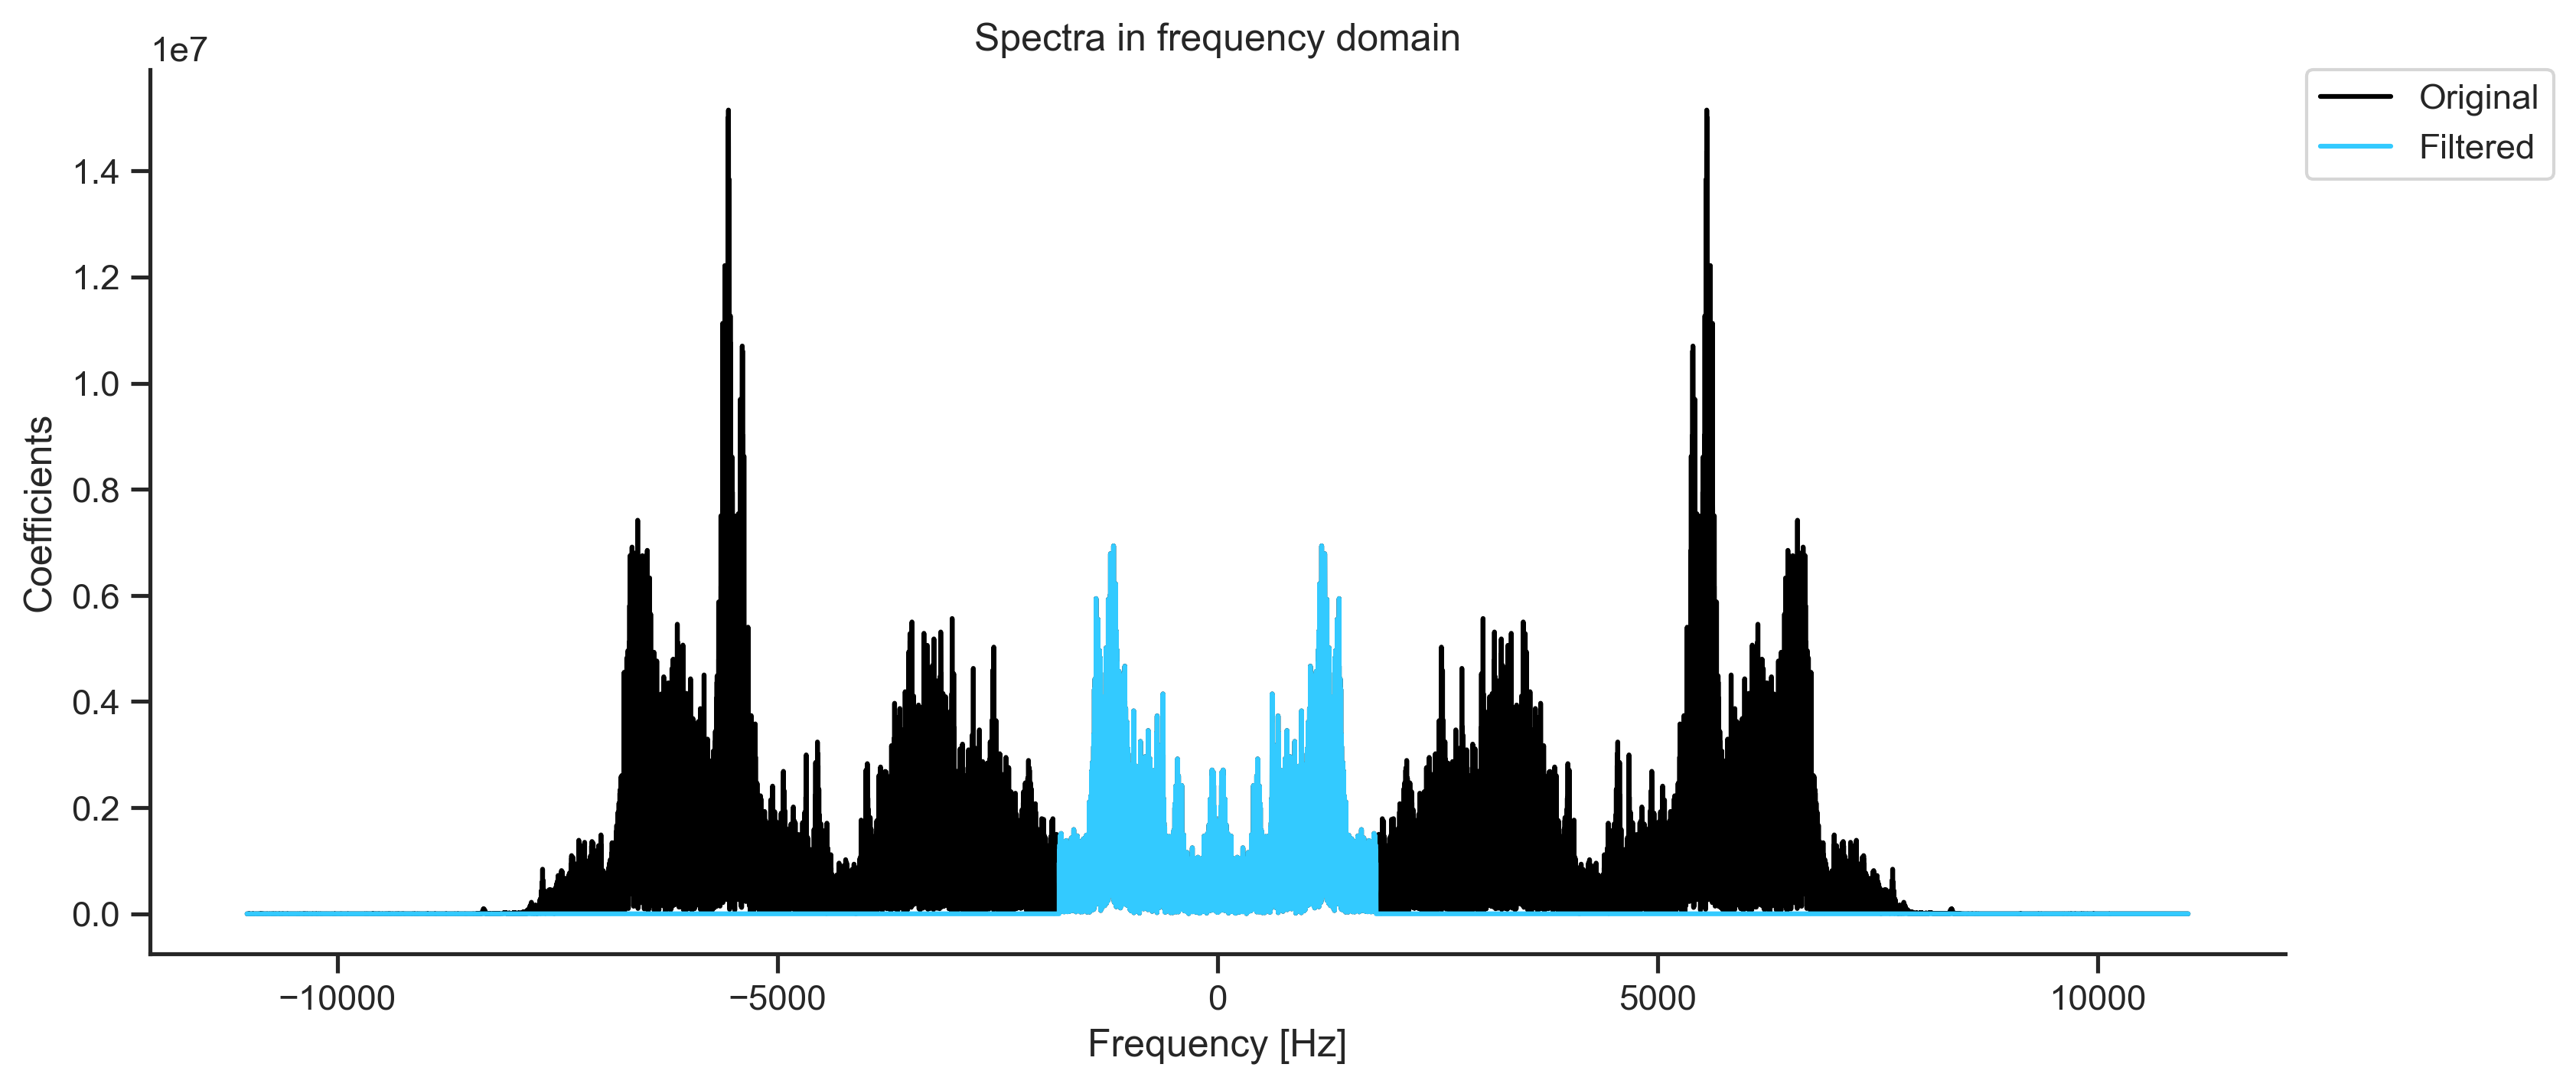

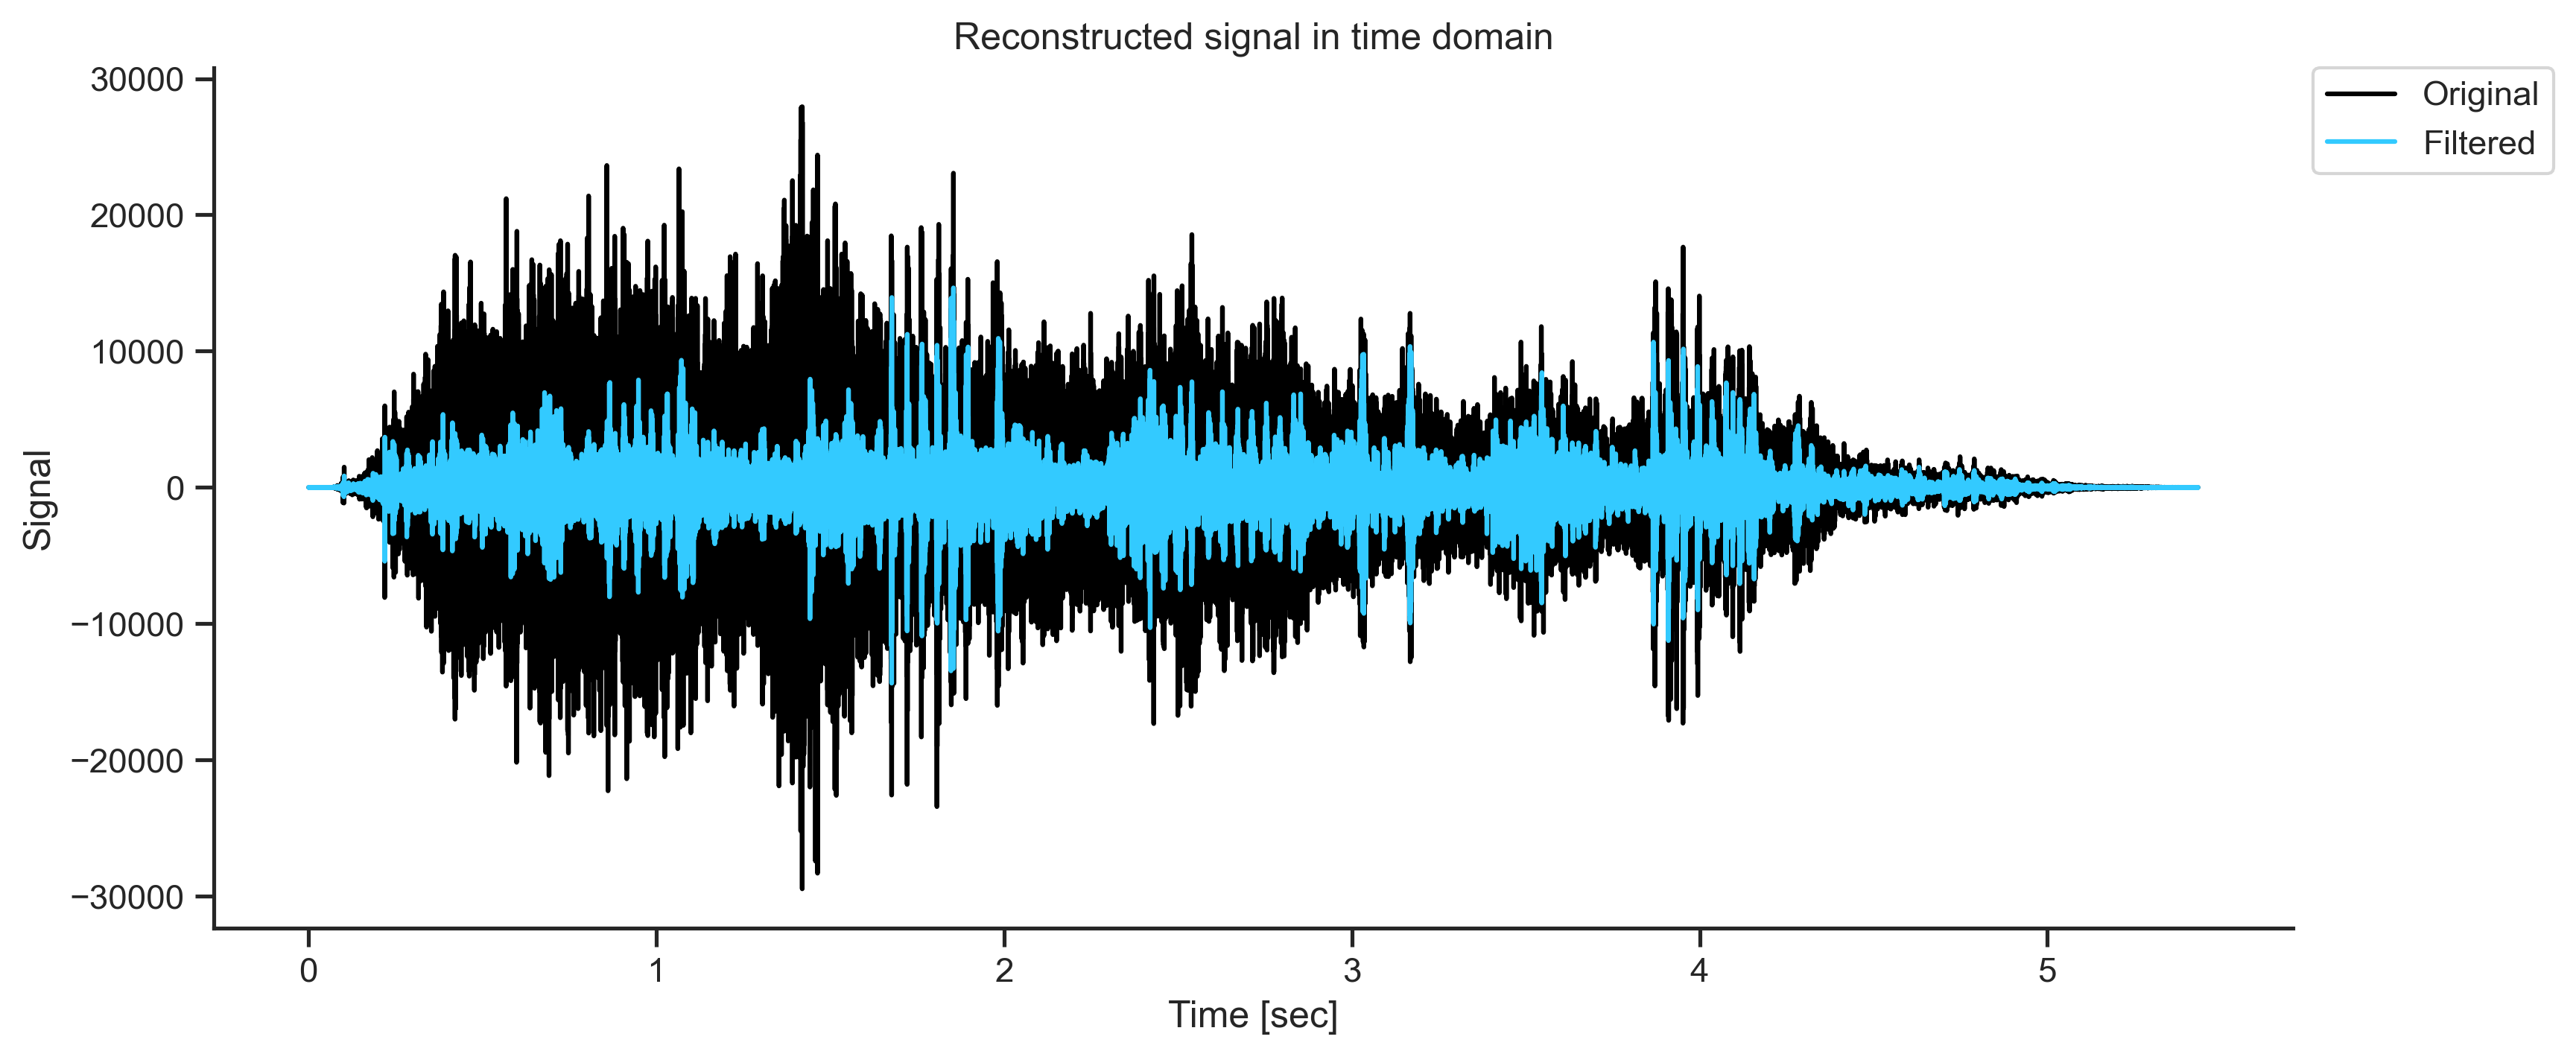

In [79]:
first_animal_sound = get_filtered_signal(sample_rate,data,real_freqs,minf = -1, maxf = 1800)
ipd.Audio(first_animal_sound, rate = sample_rate)

## 2.2. Isolate the second animal sound

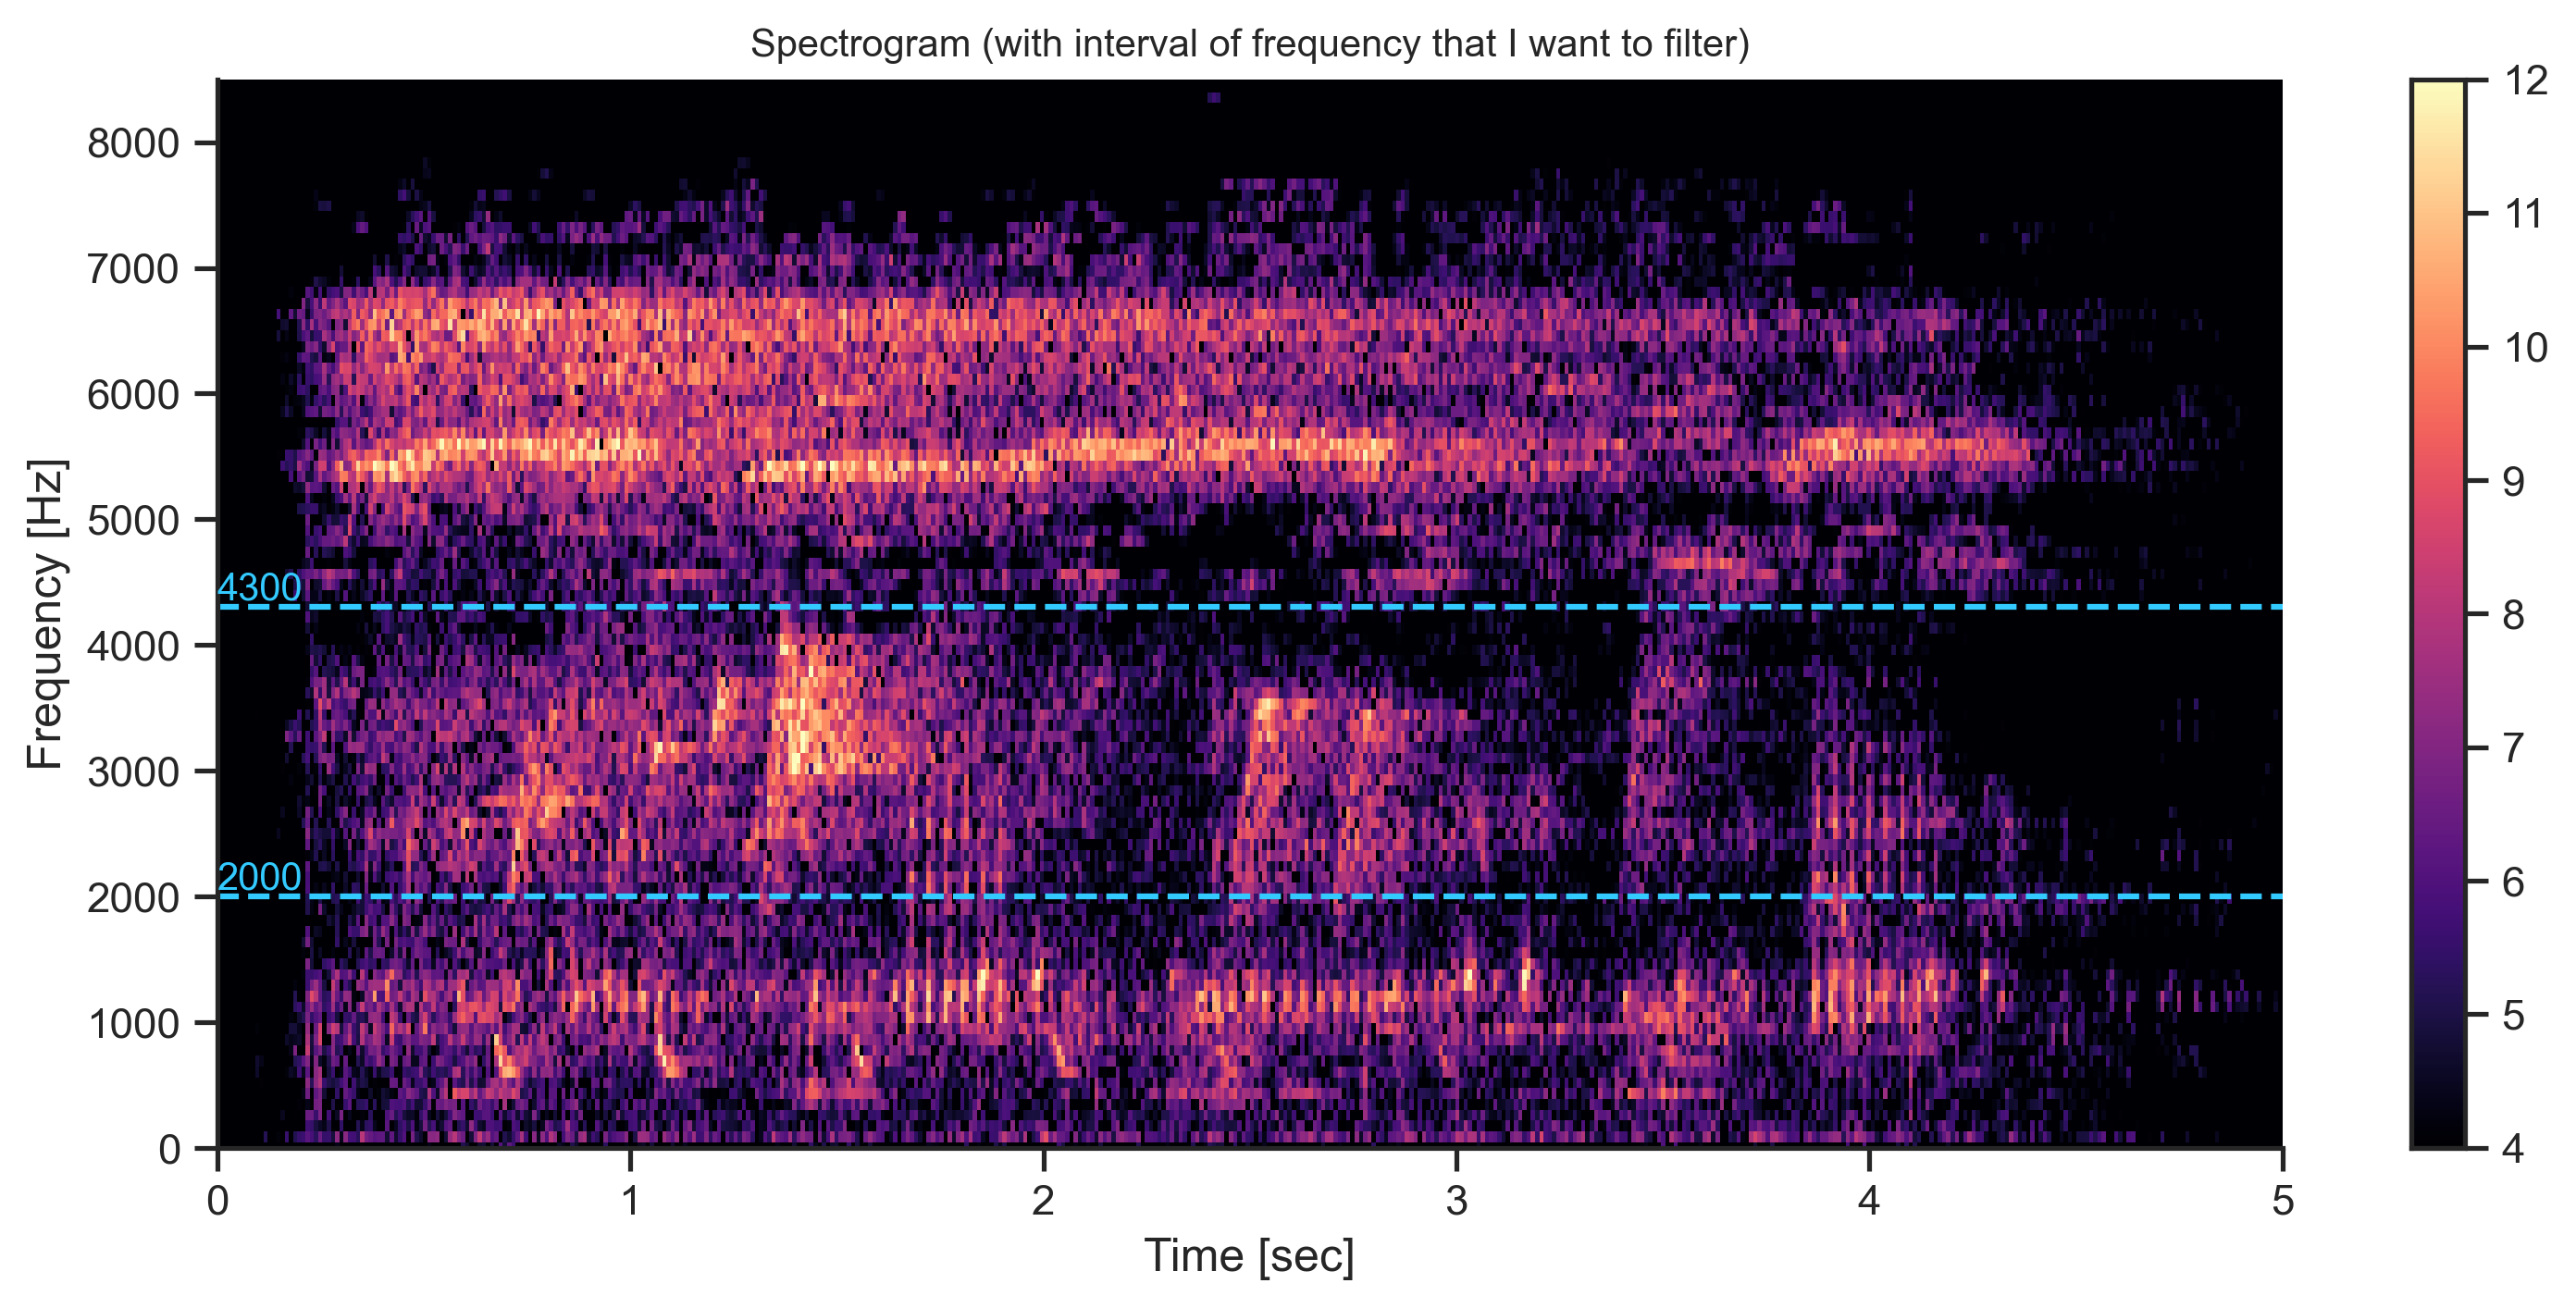

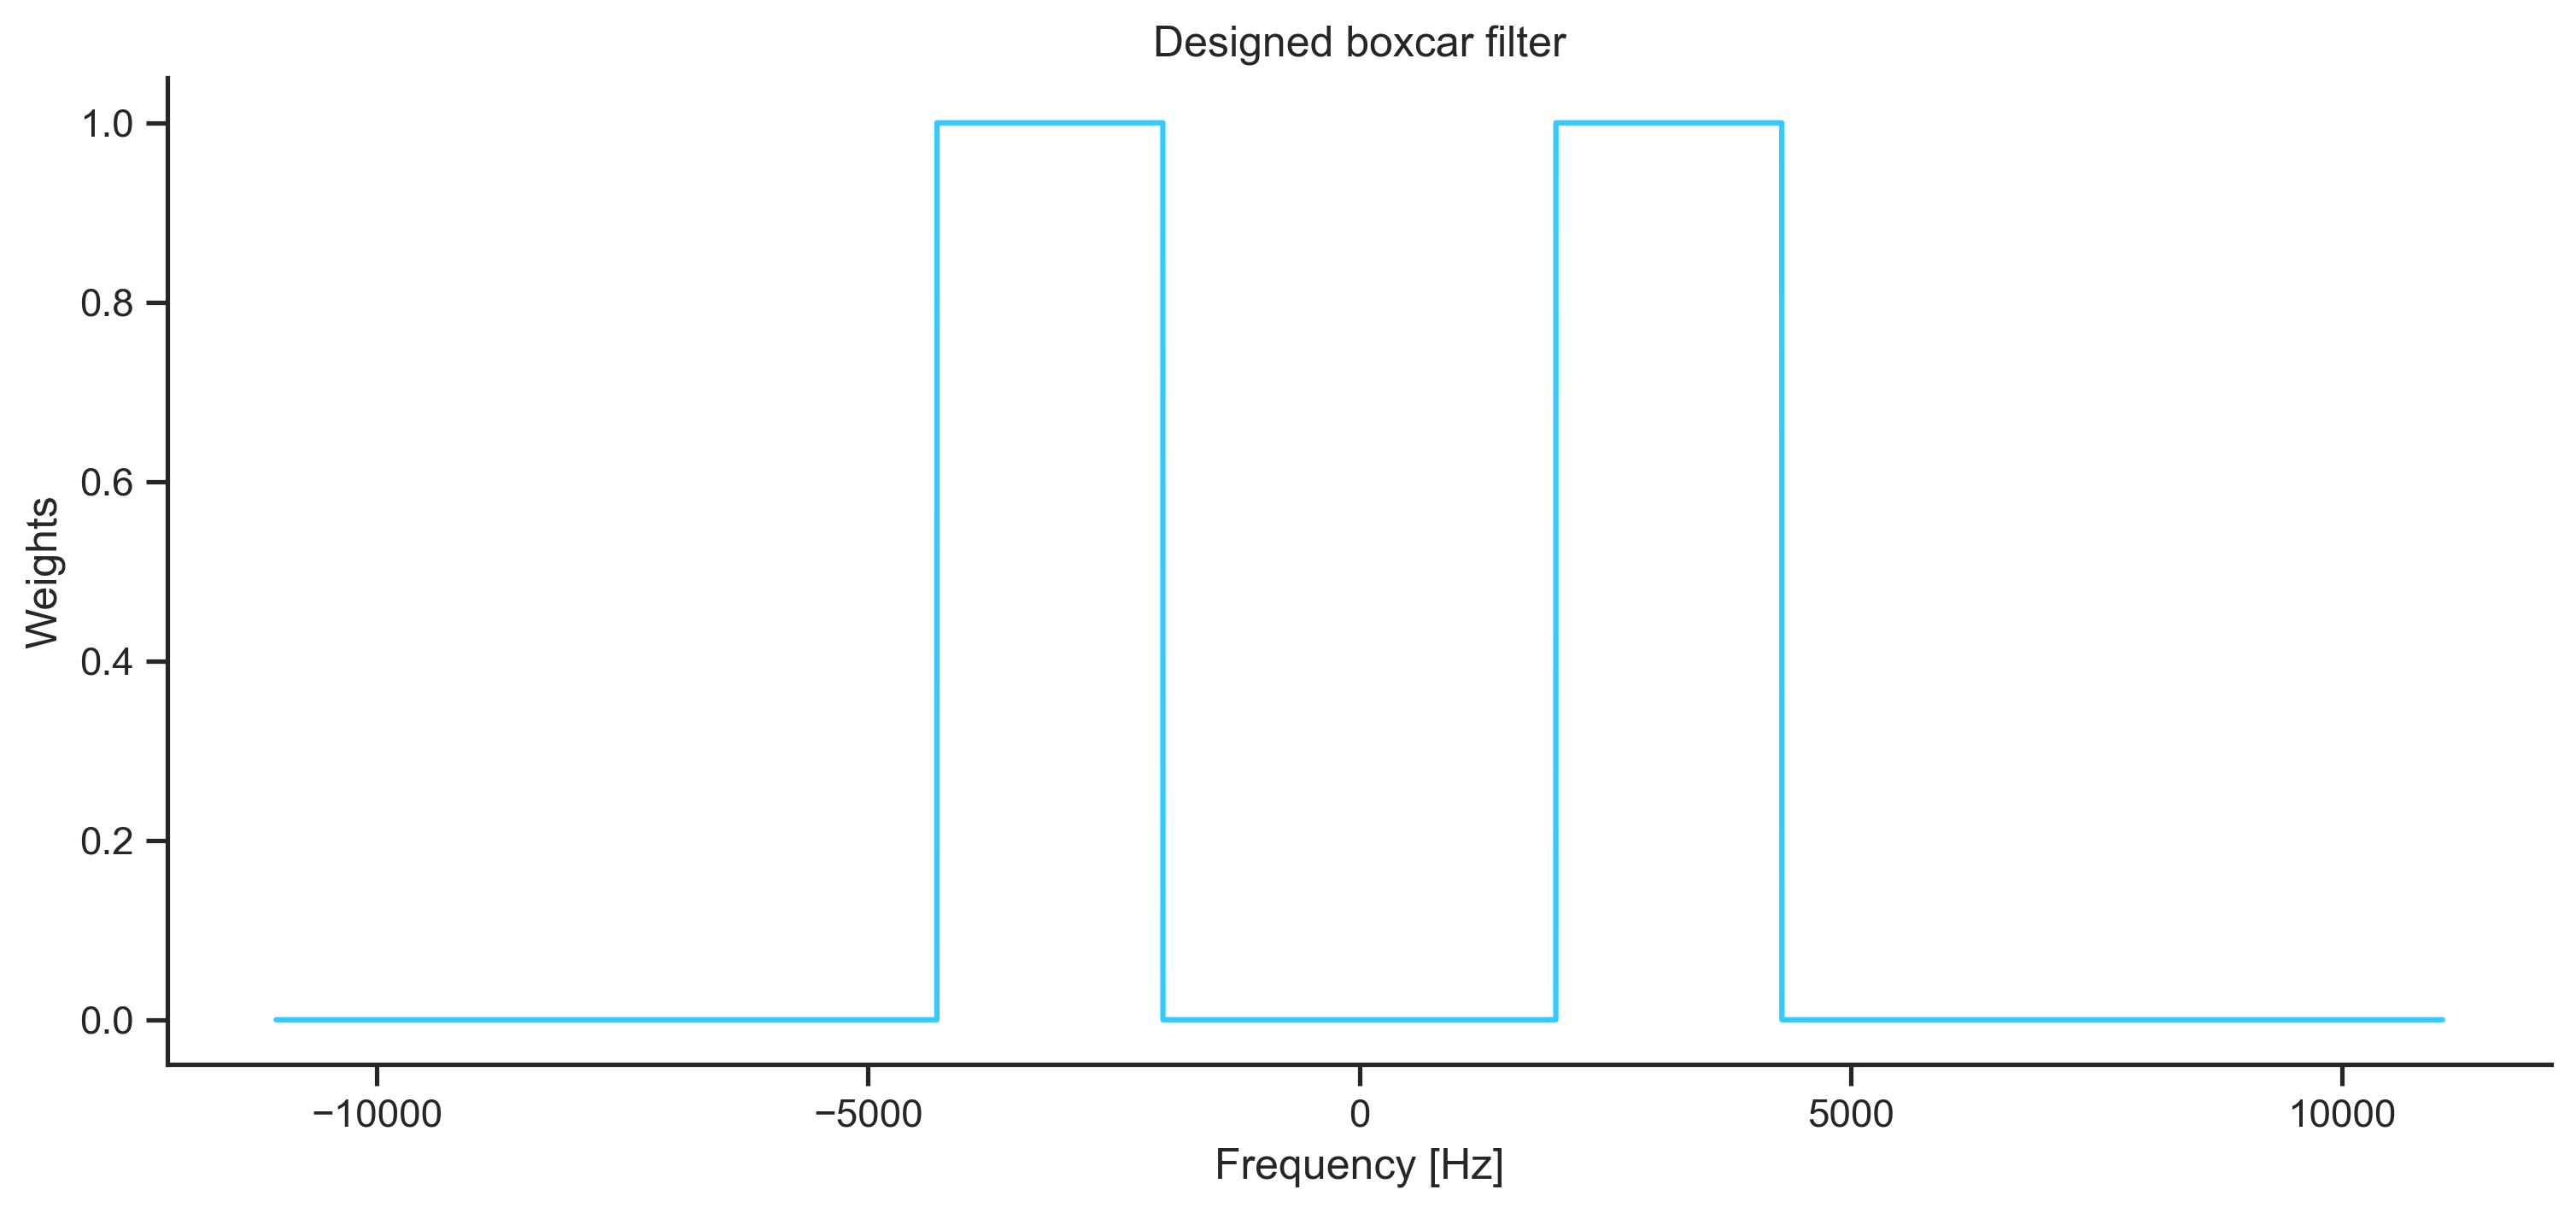

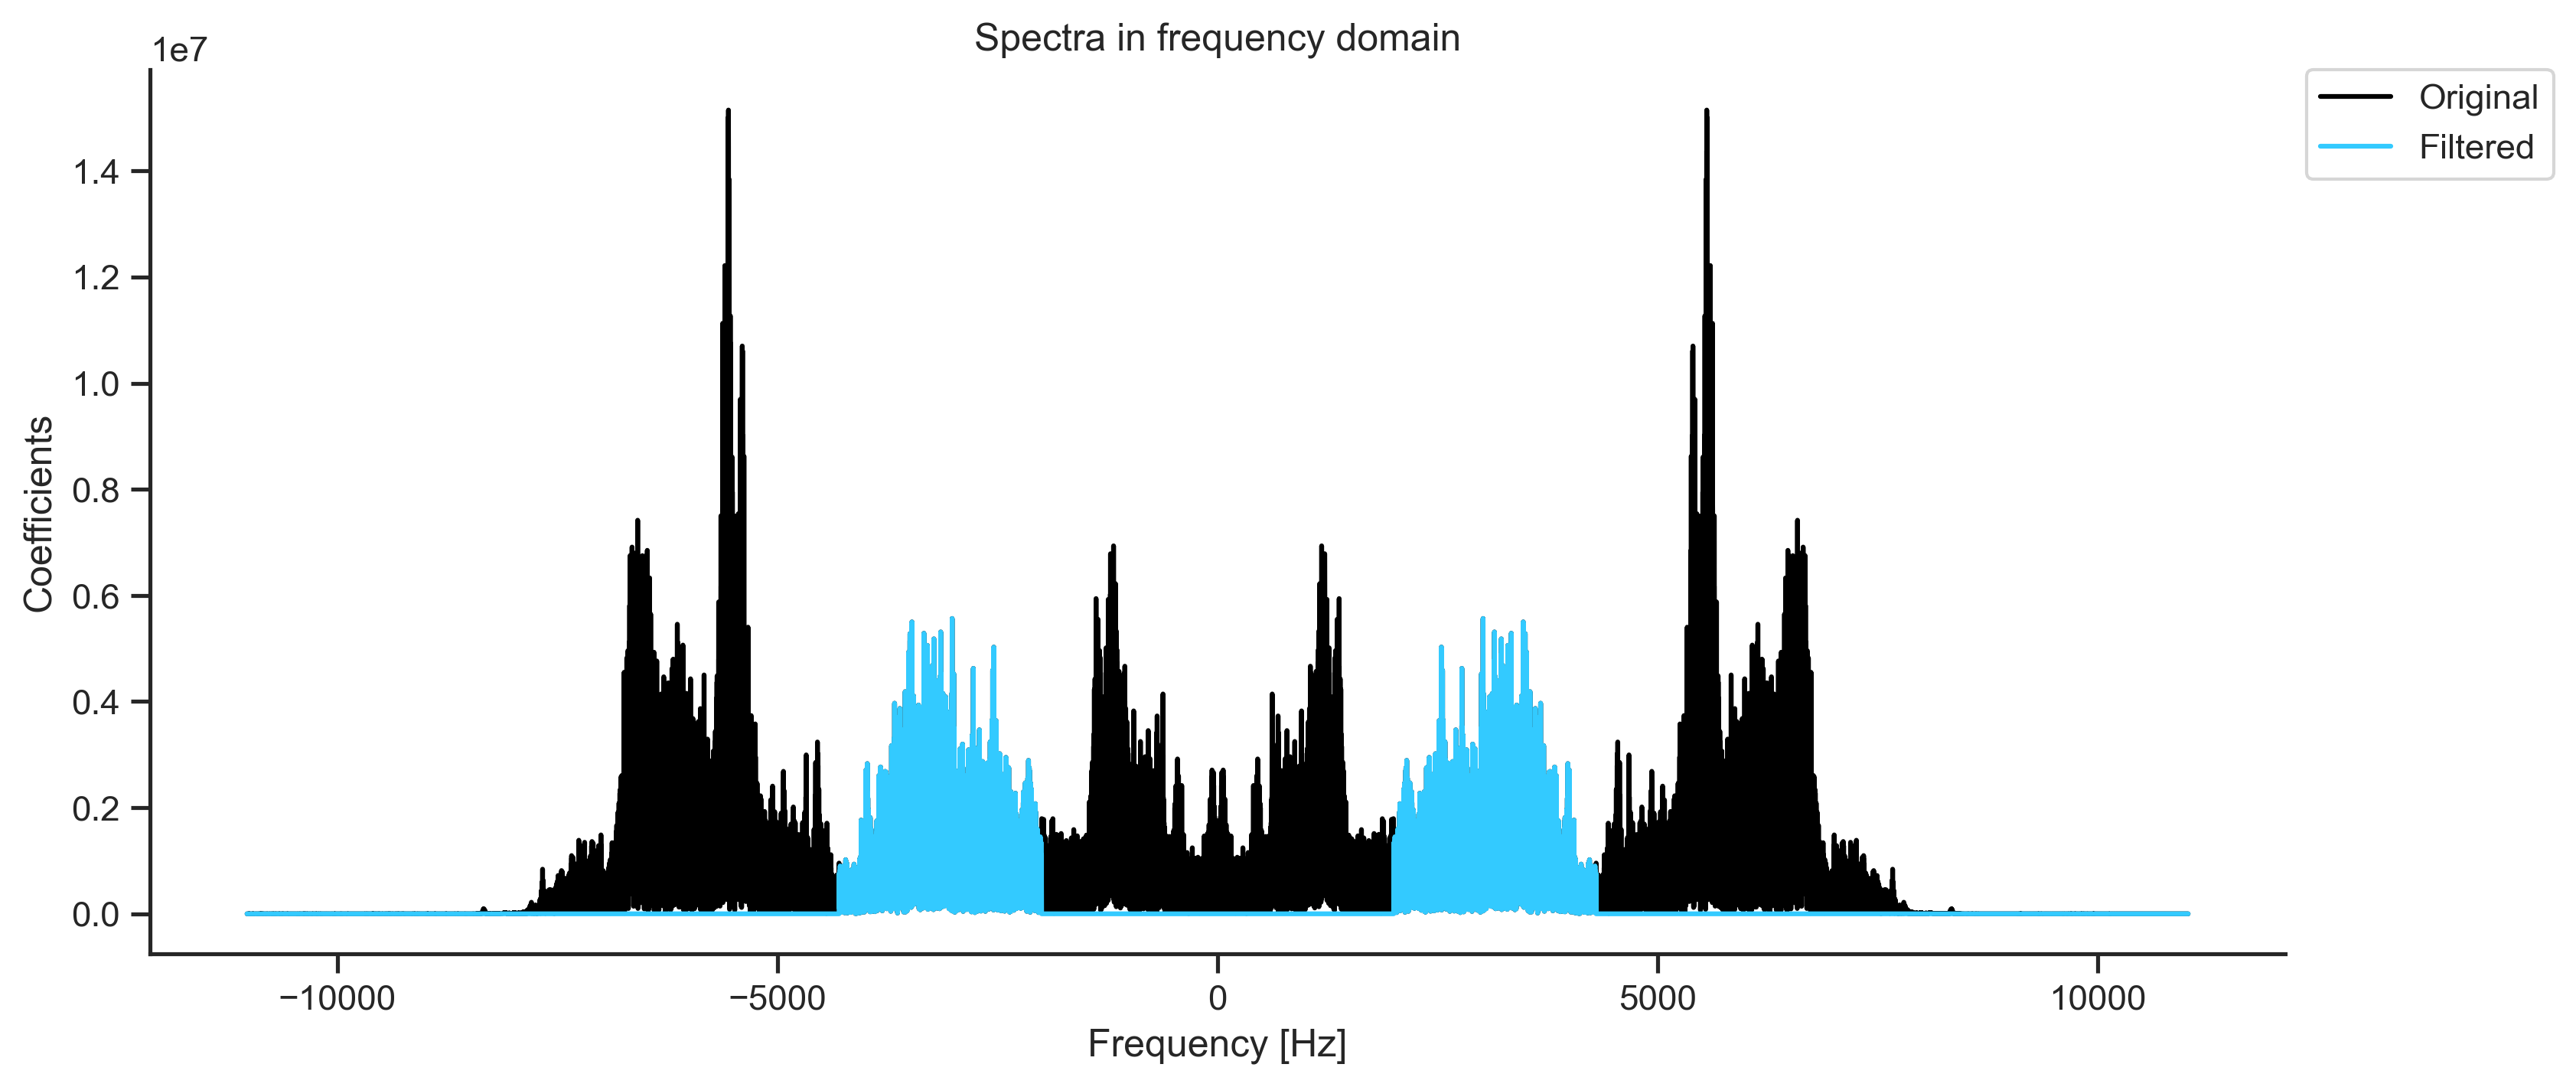

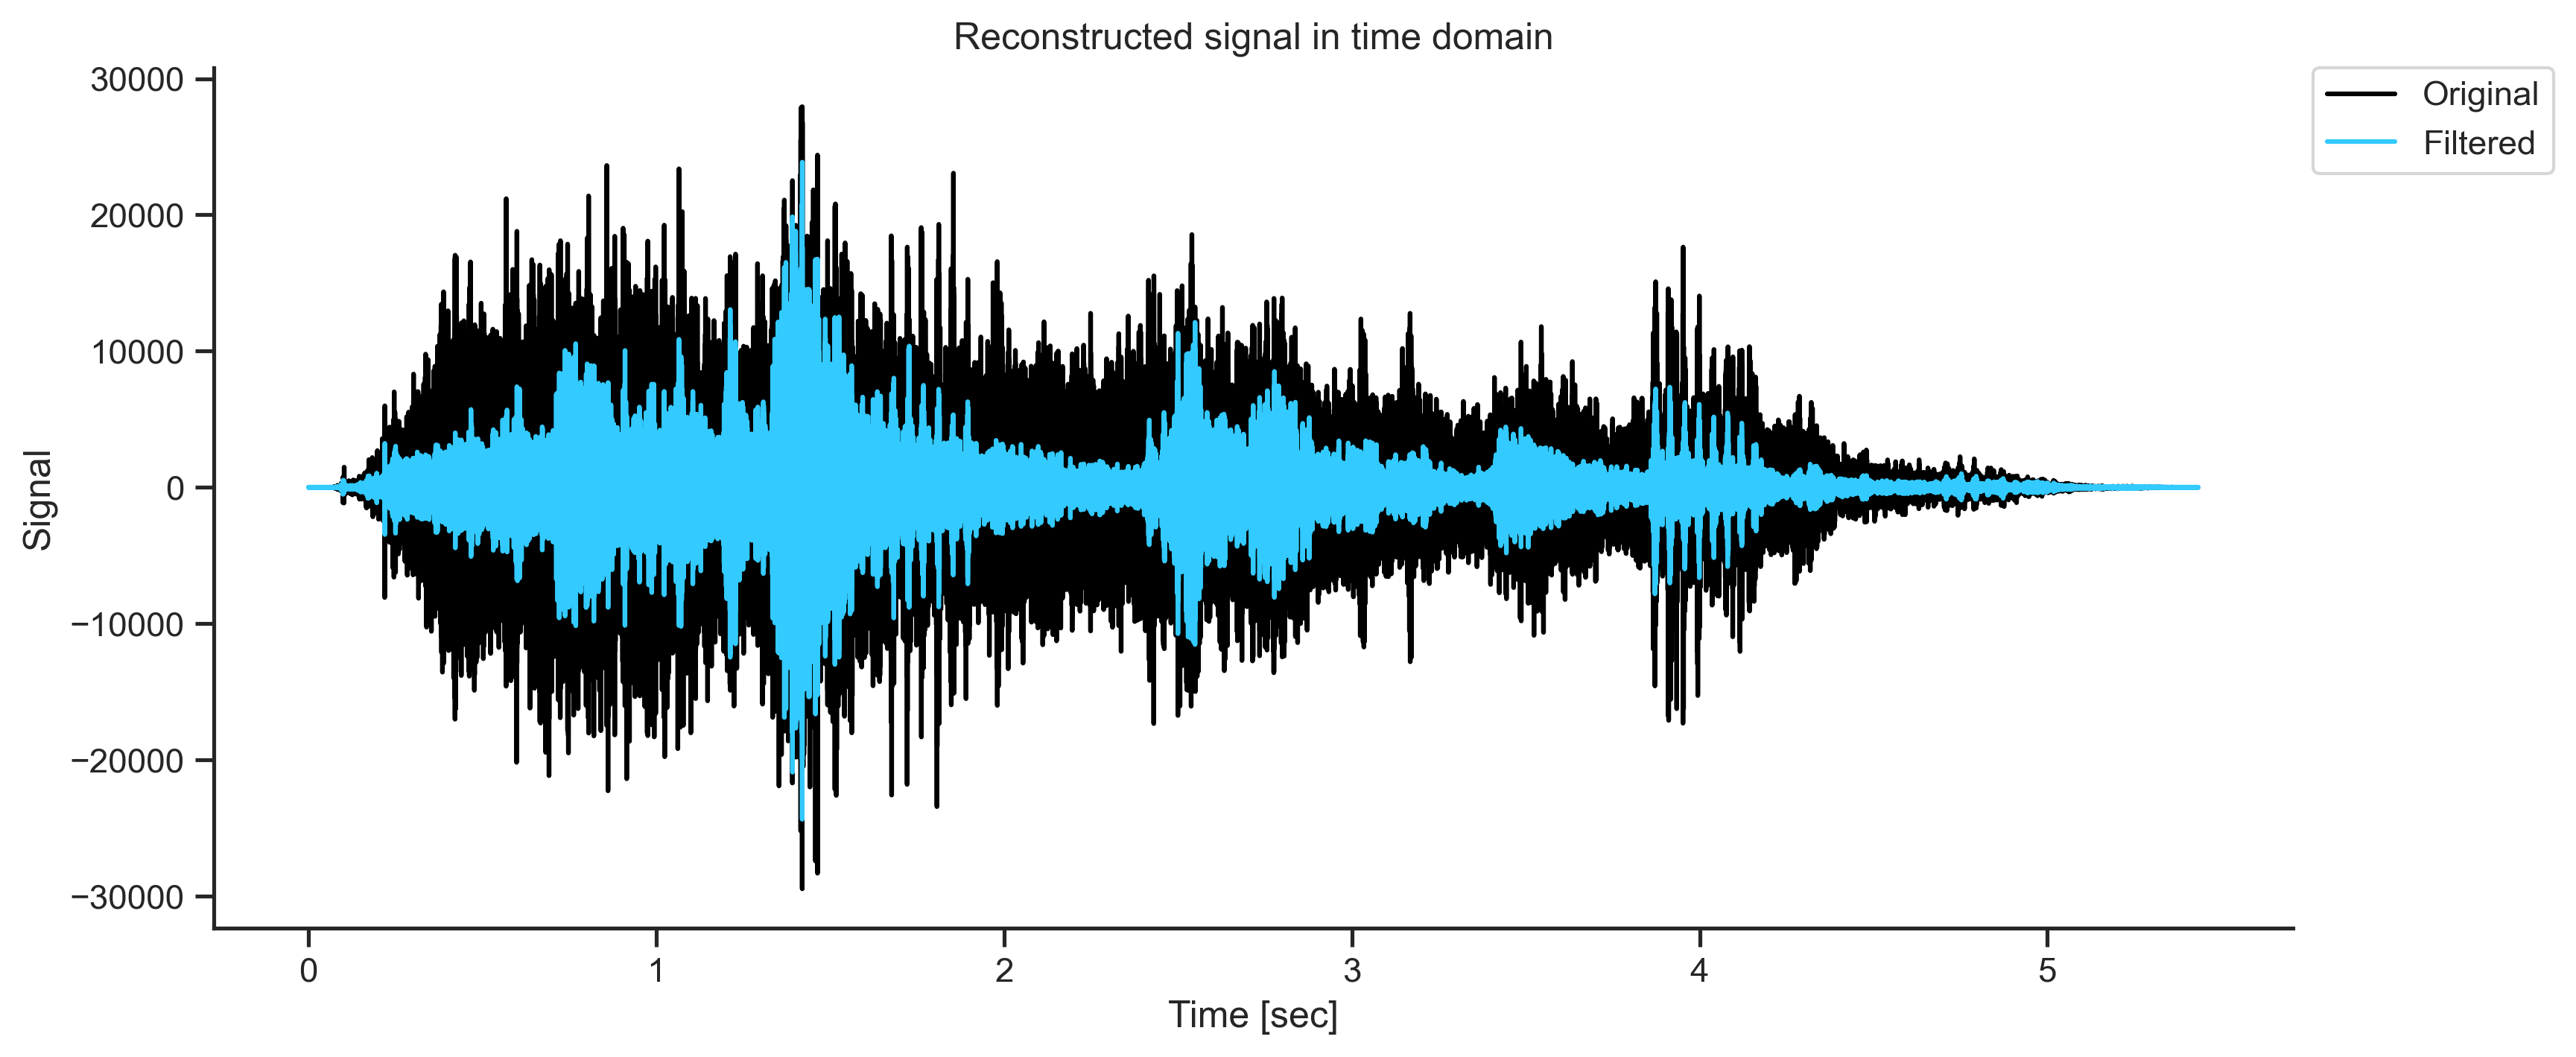

In [80]:
second_animal_sound = get_filtered_signal(sample_rate,data,real_freqs,minf = 2000, maxf = 4300)
ipd.Audio(second_animal_sound, rate = sample_rate)

## 2.3. Isolate the third animal sound

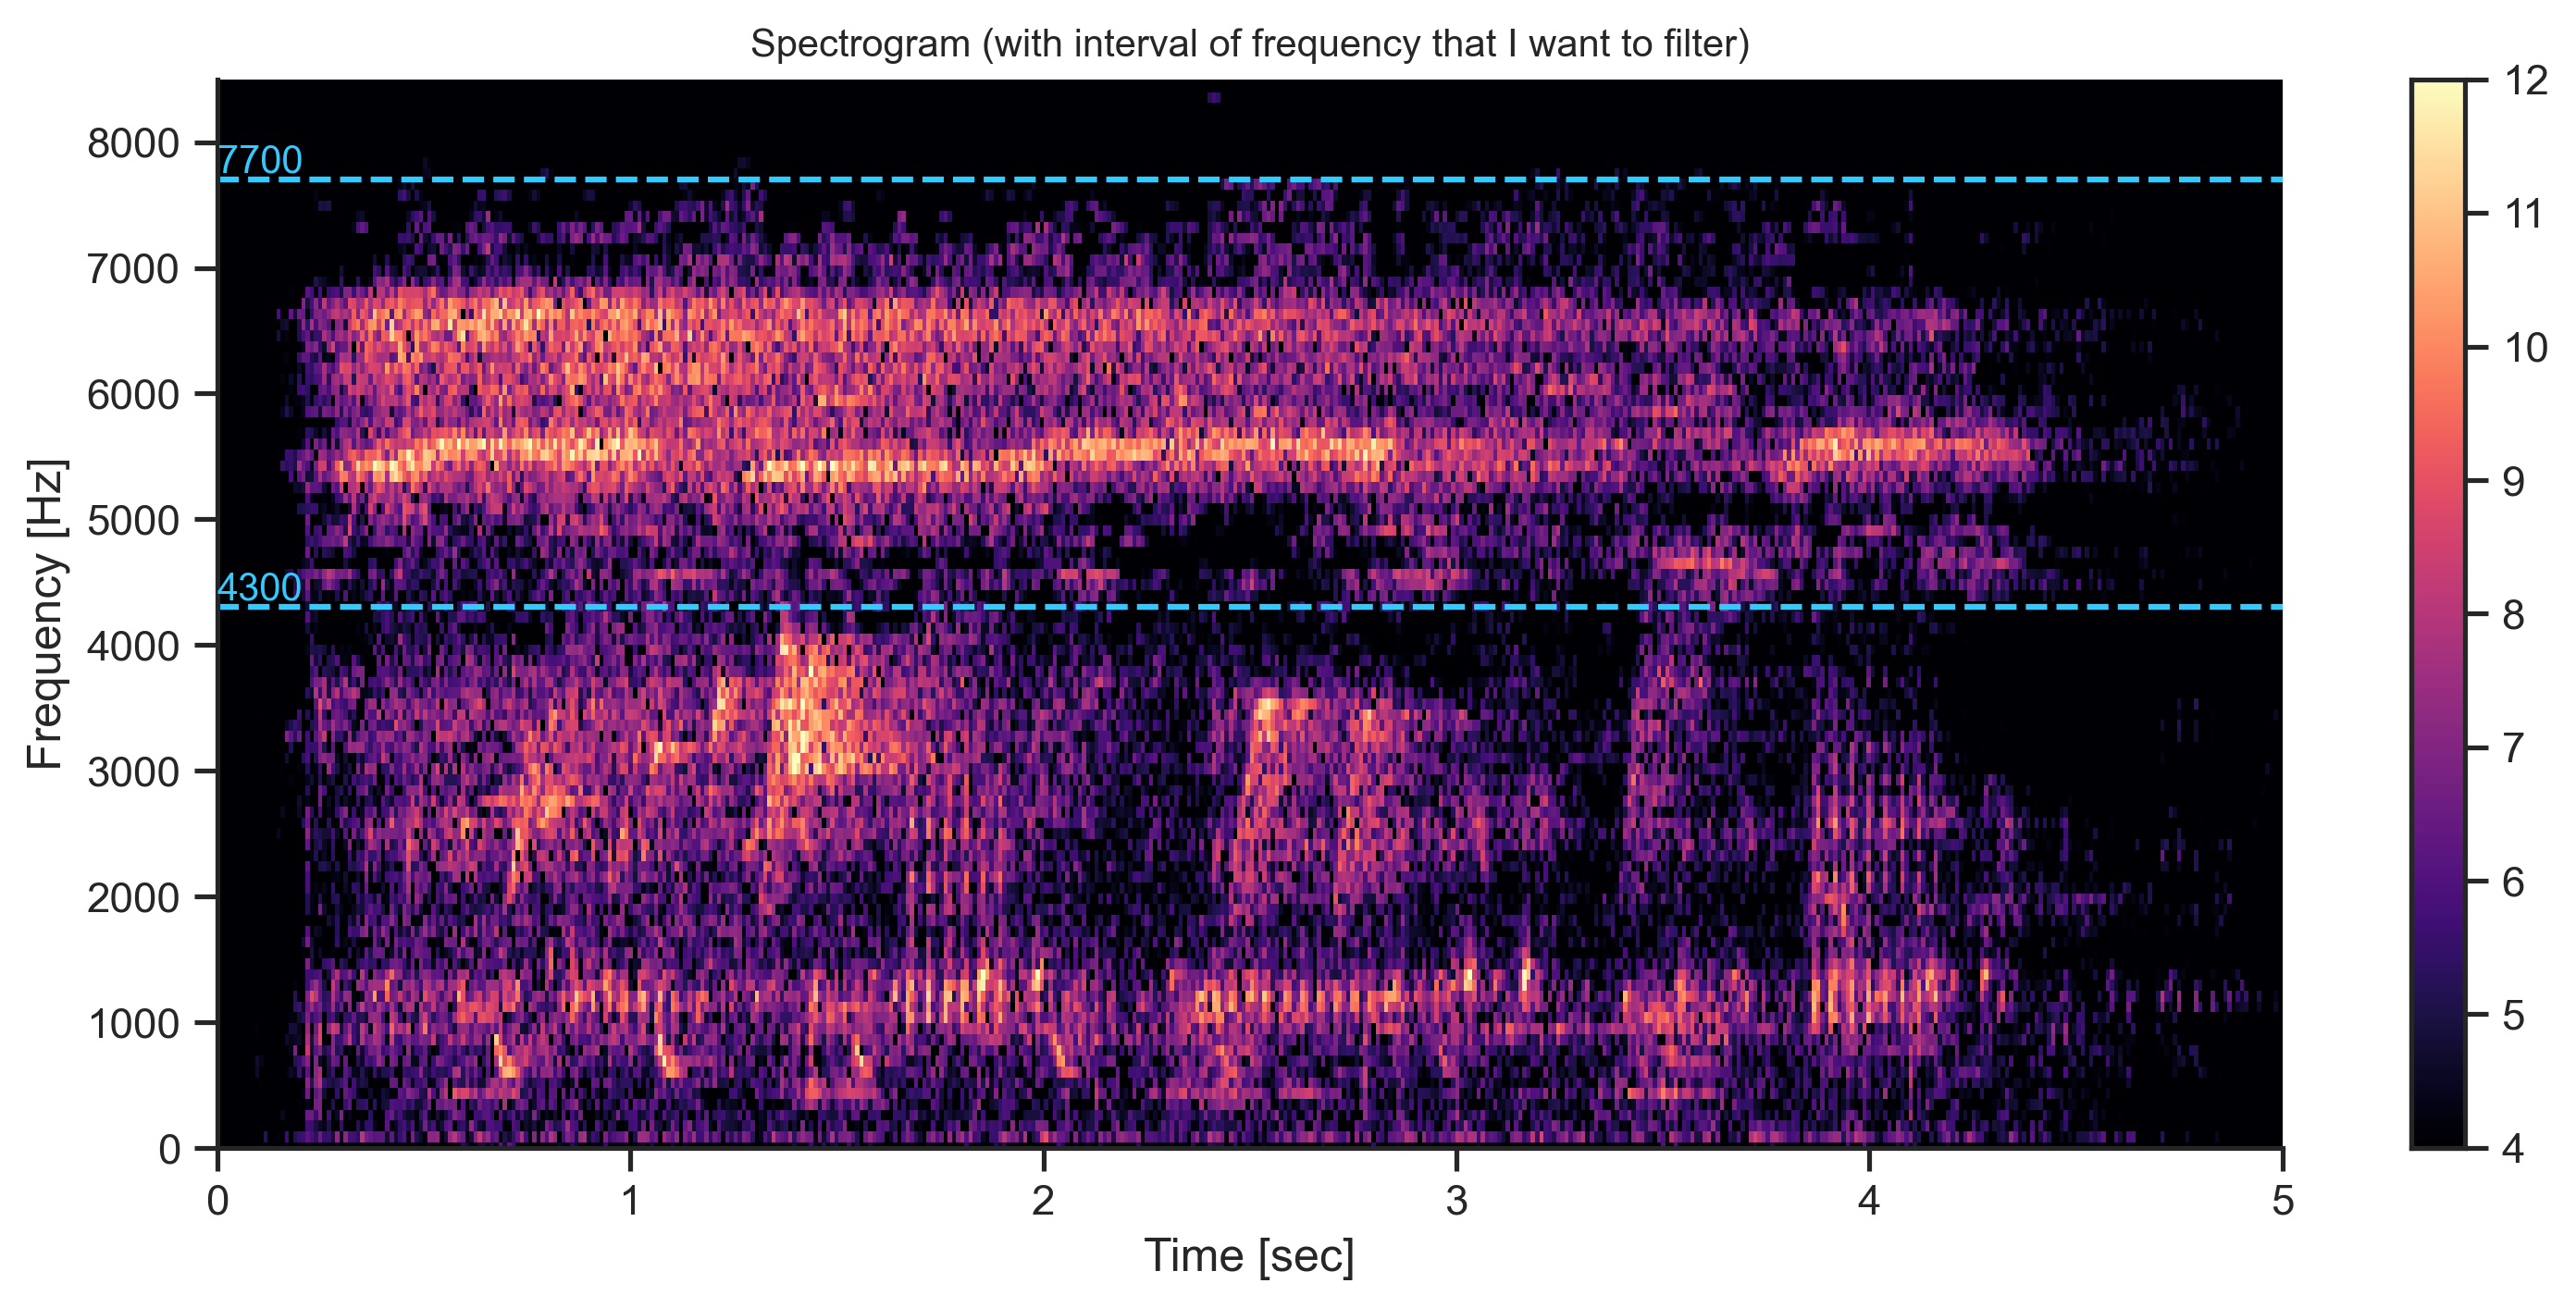

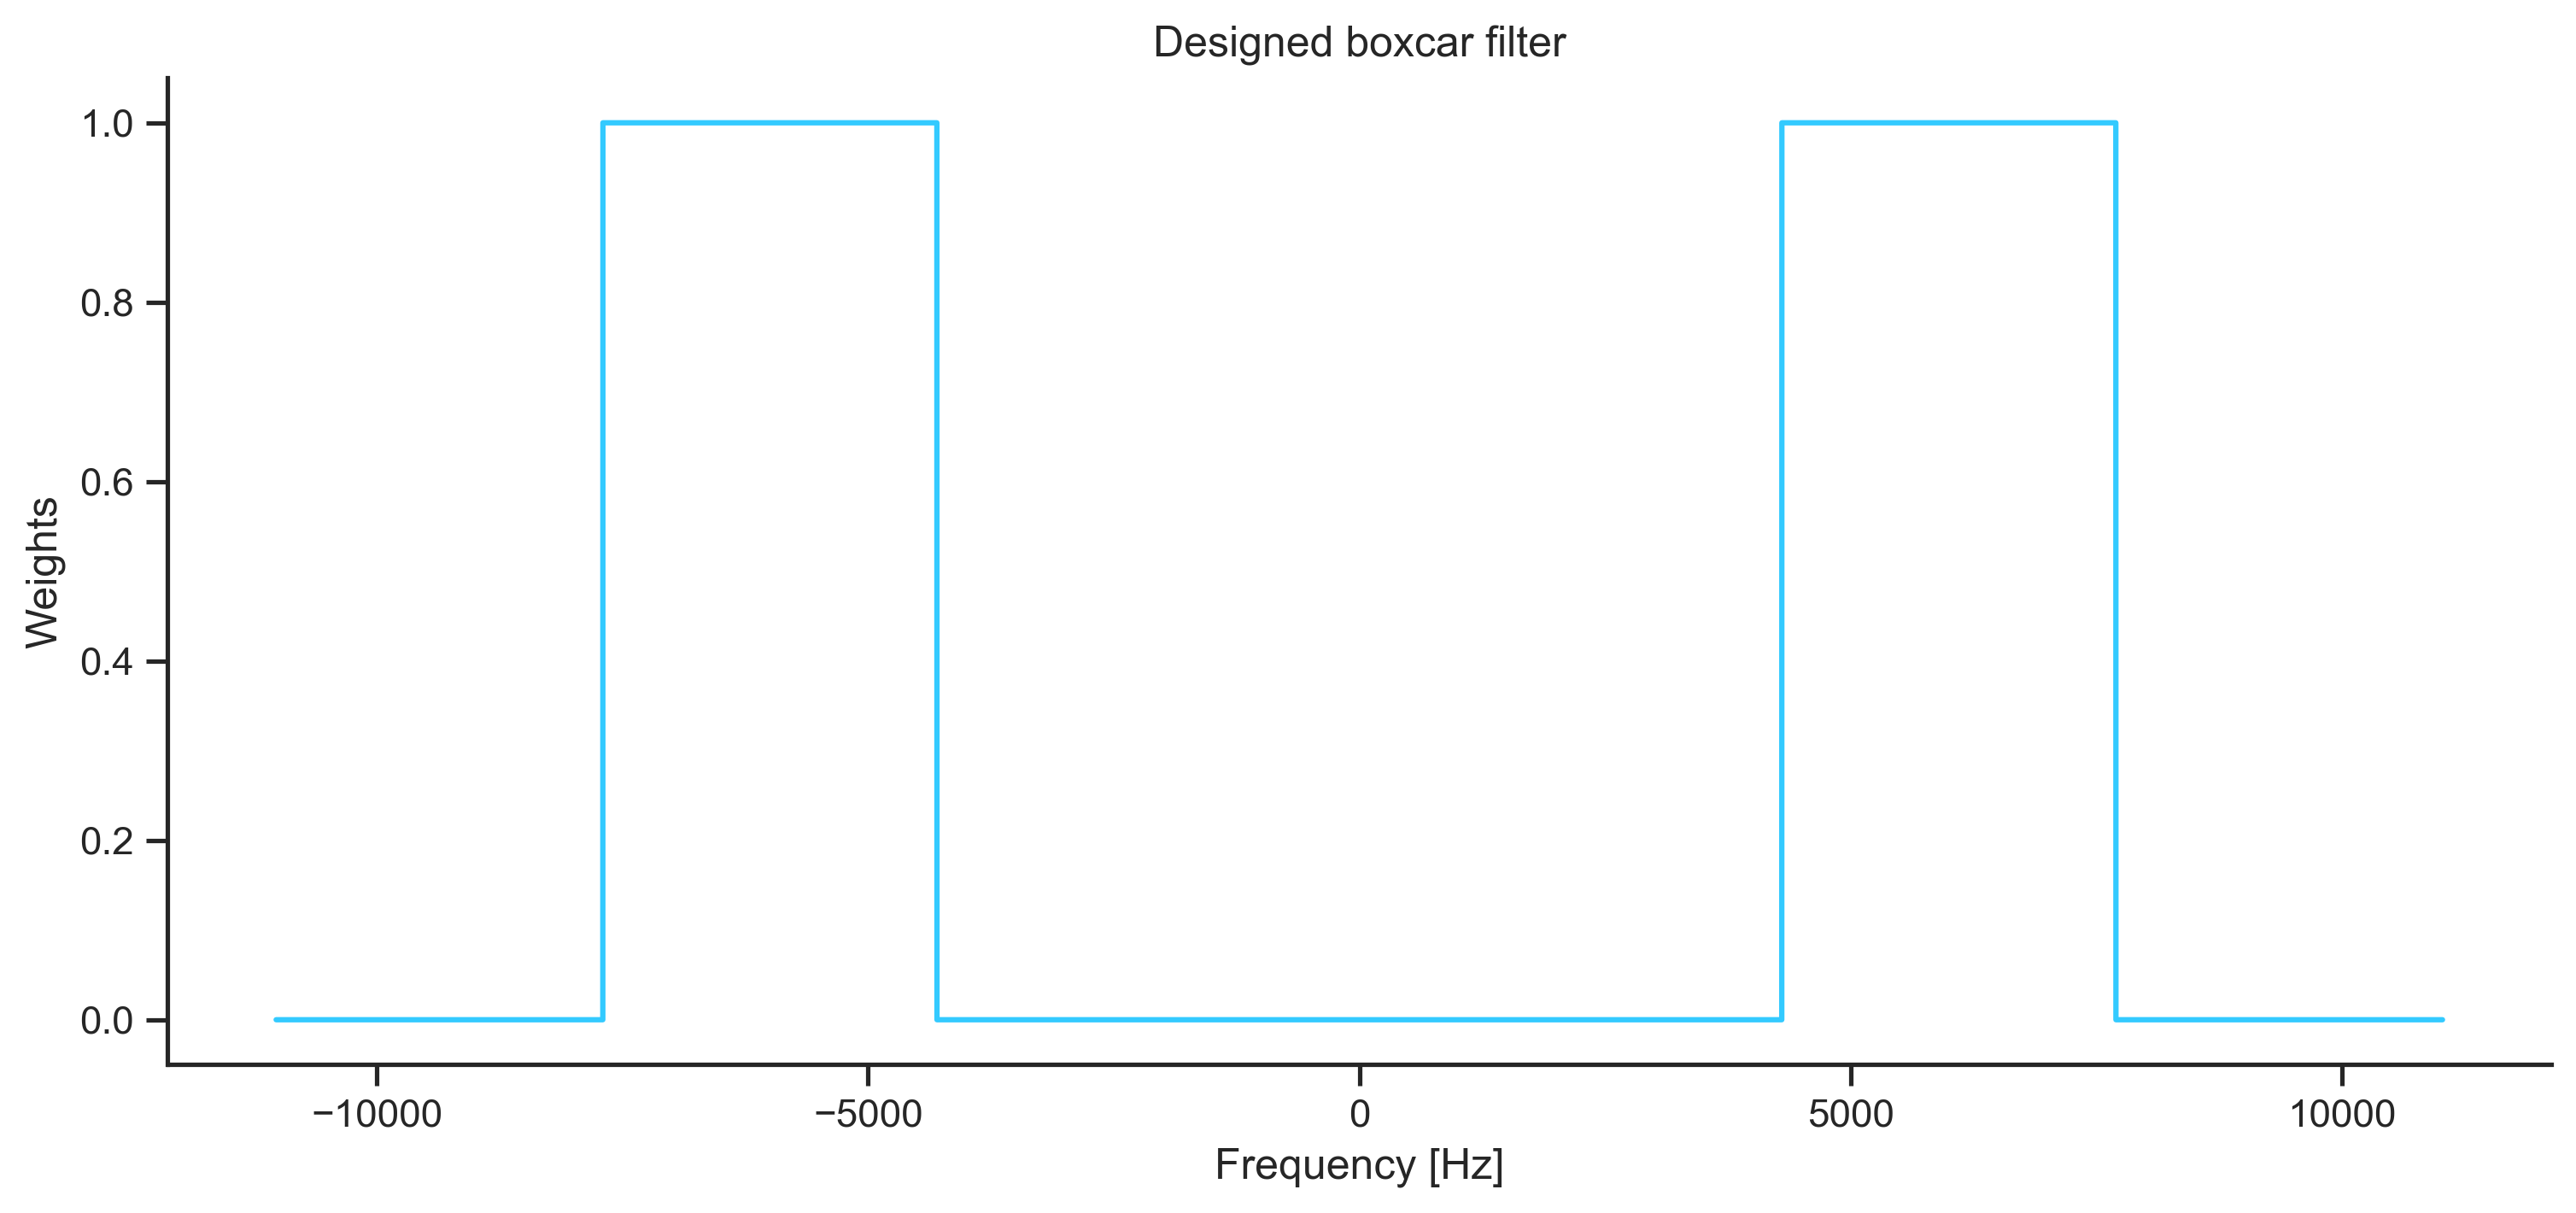

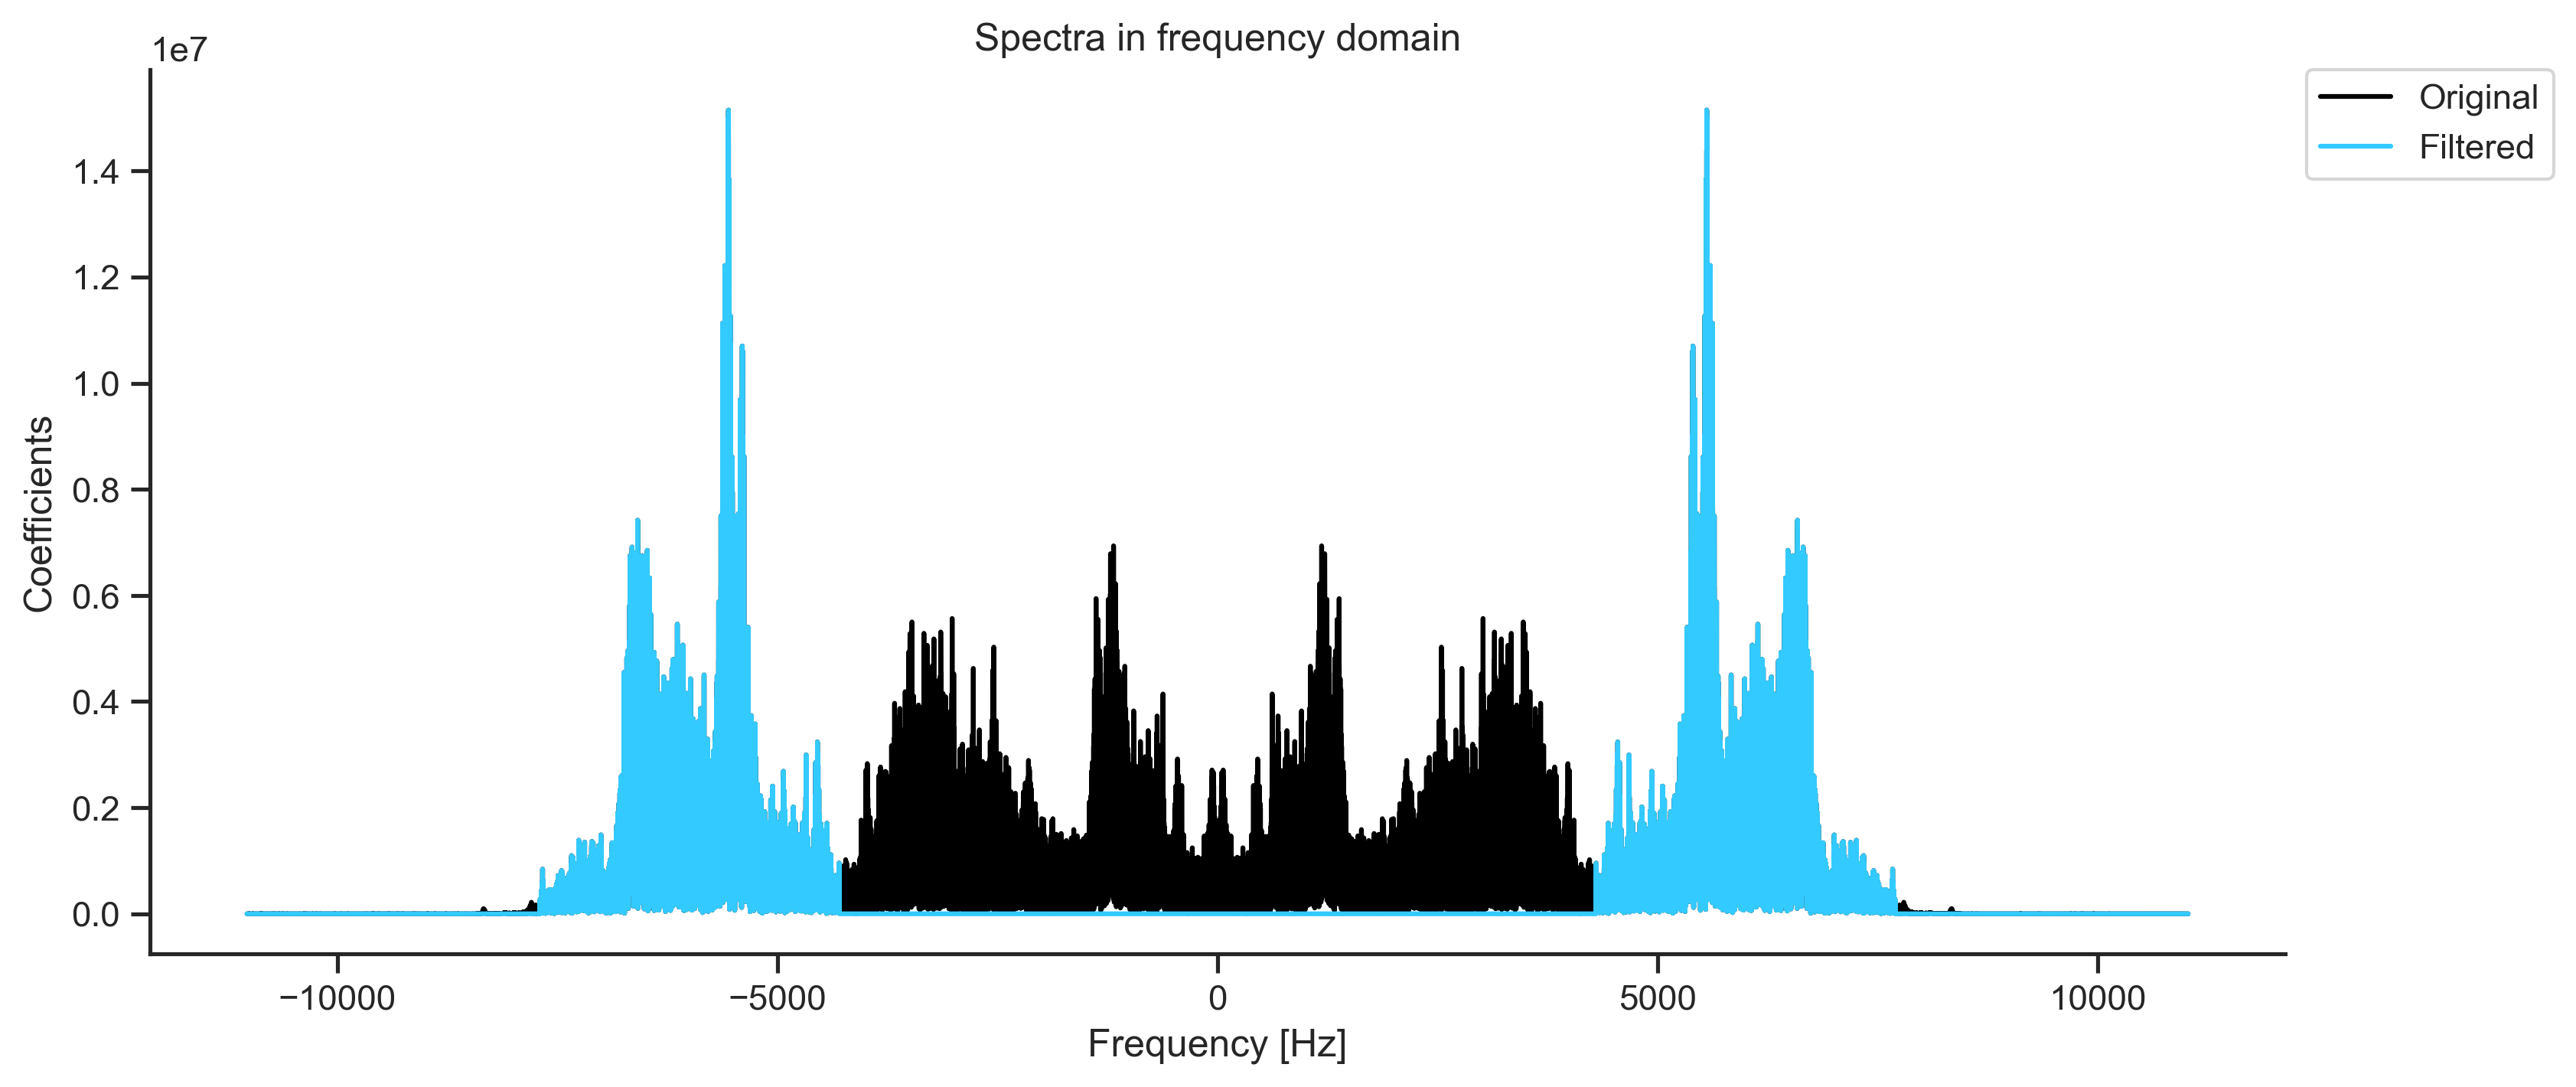

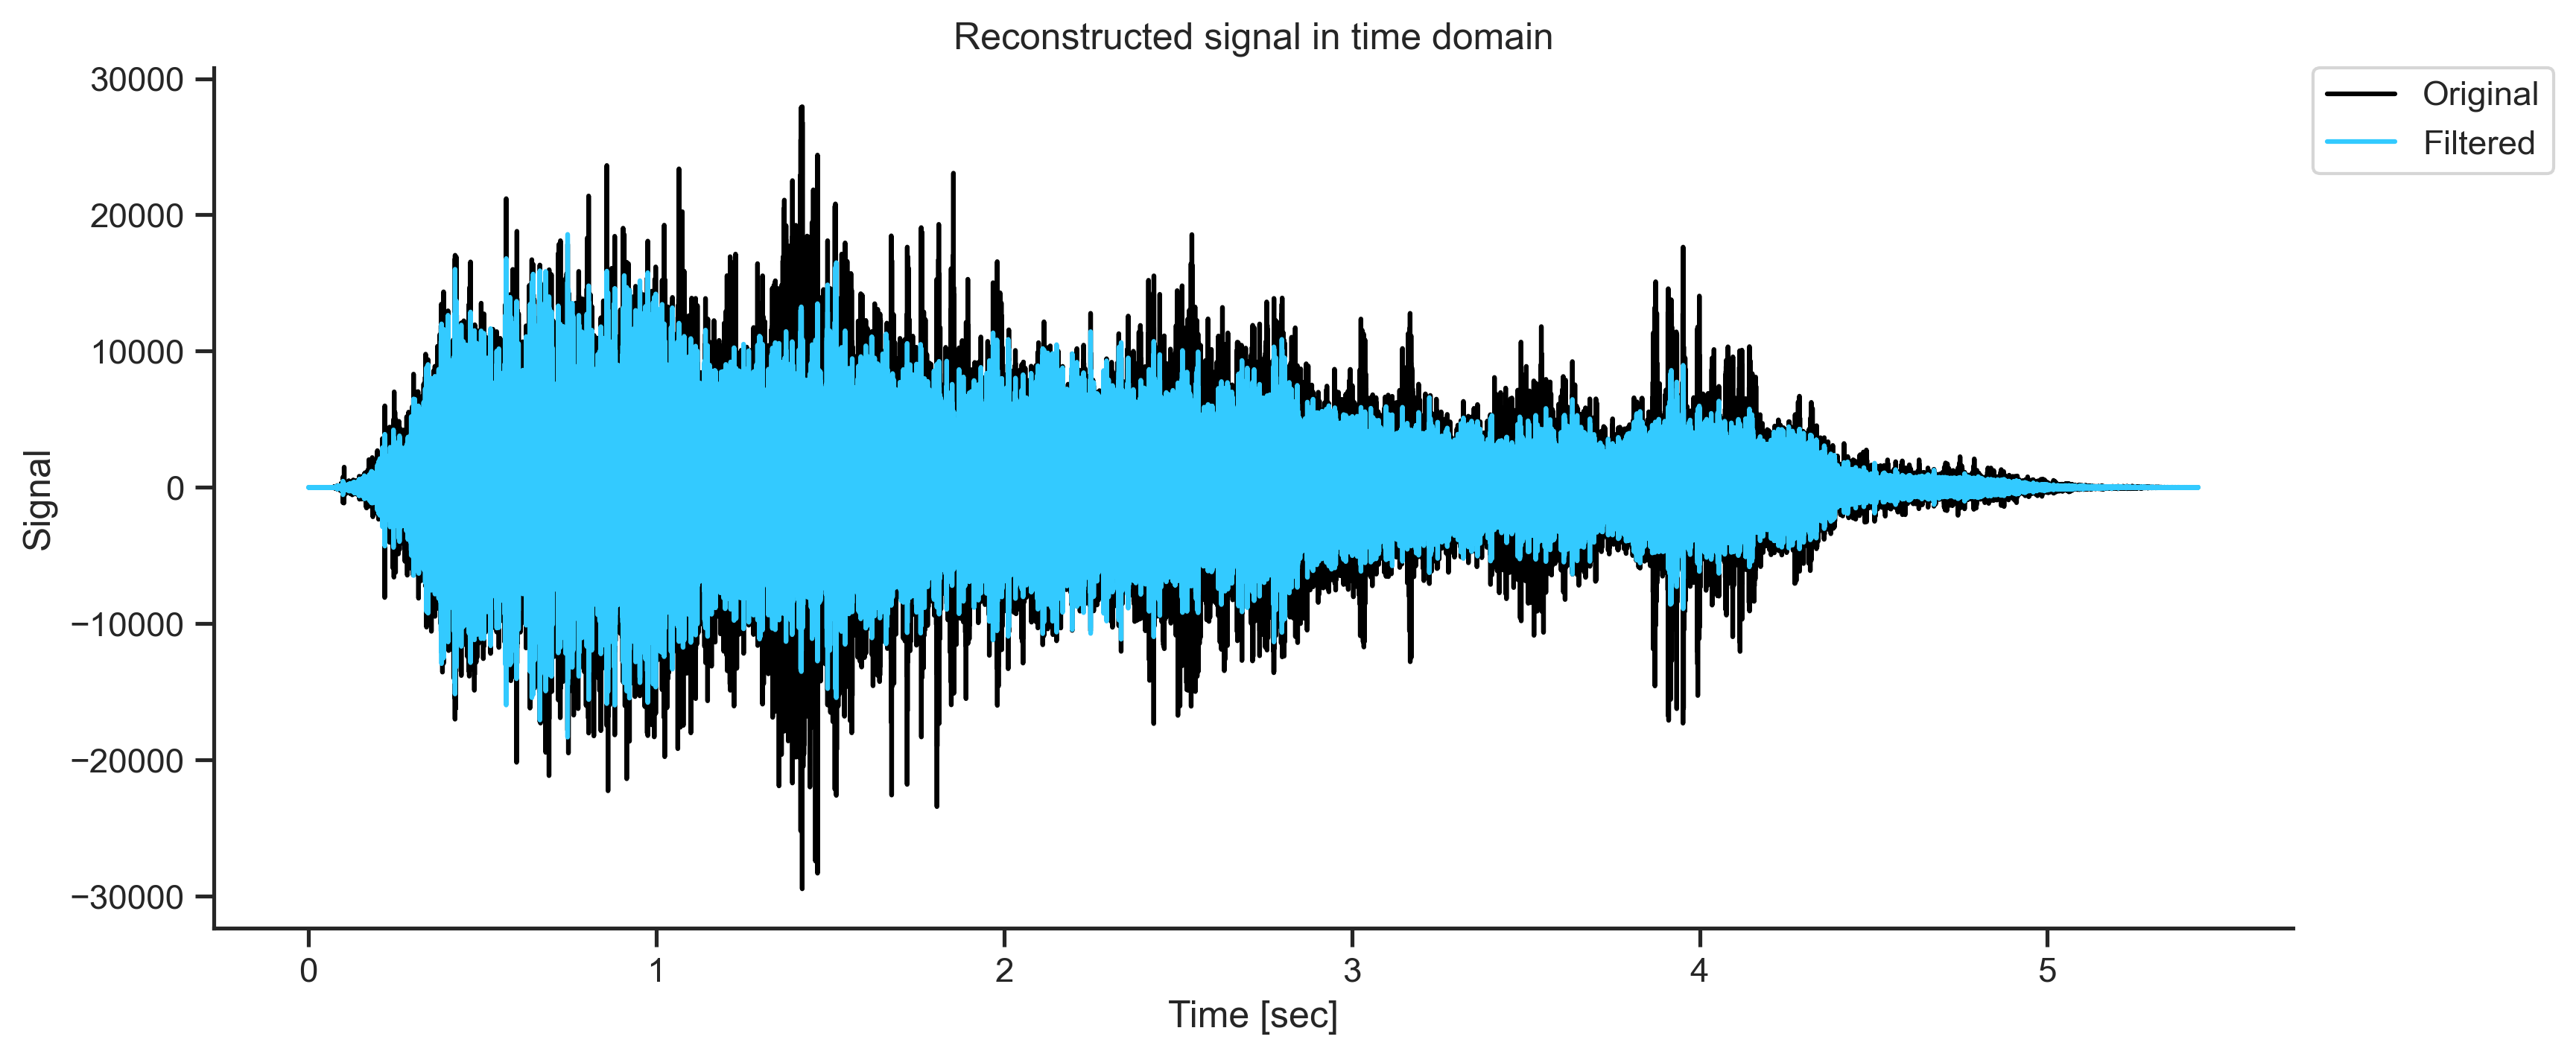

In [81]:
third_animal_sound = get_filtered_signal(sample_rate,data,real_freqs,minf = 4300, maxf = 7700)
ipd.Audio(third_animal_sound, rate = sample_rate)

## 2.4. Visualise the spectrogram for each animal sound

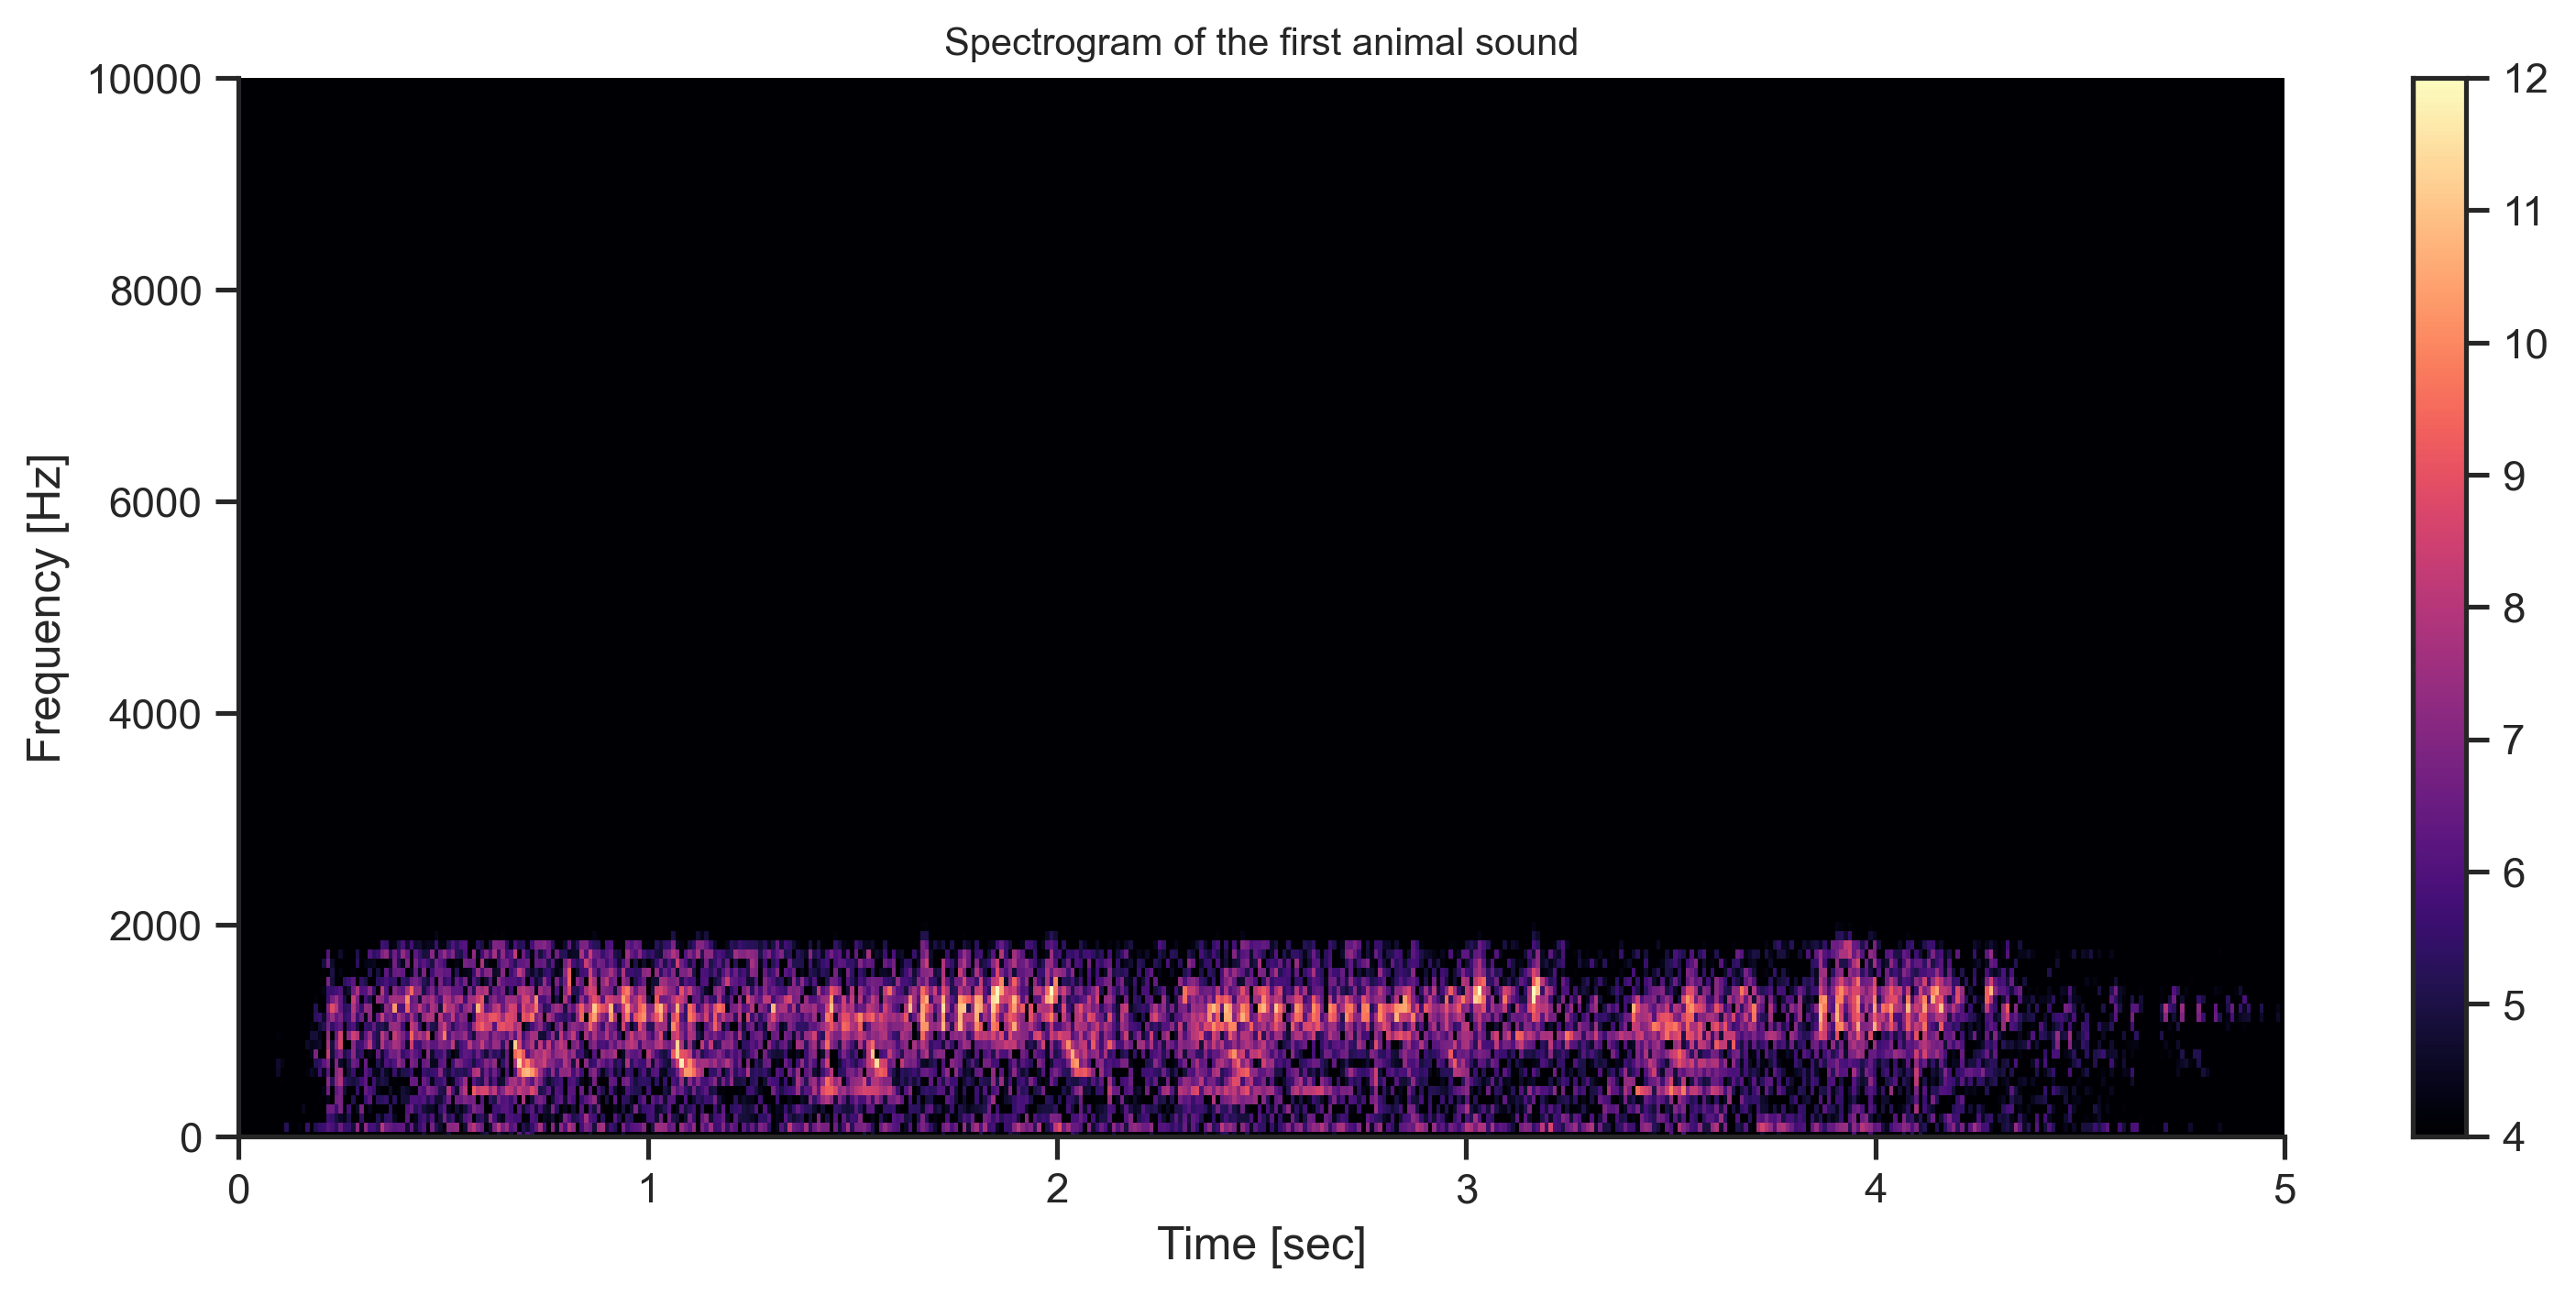

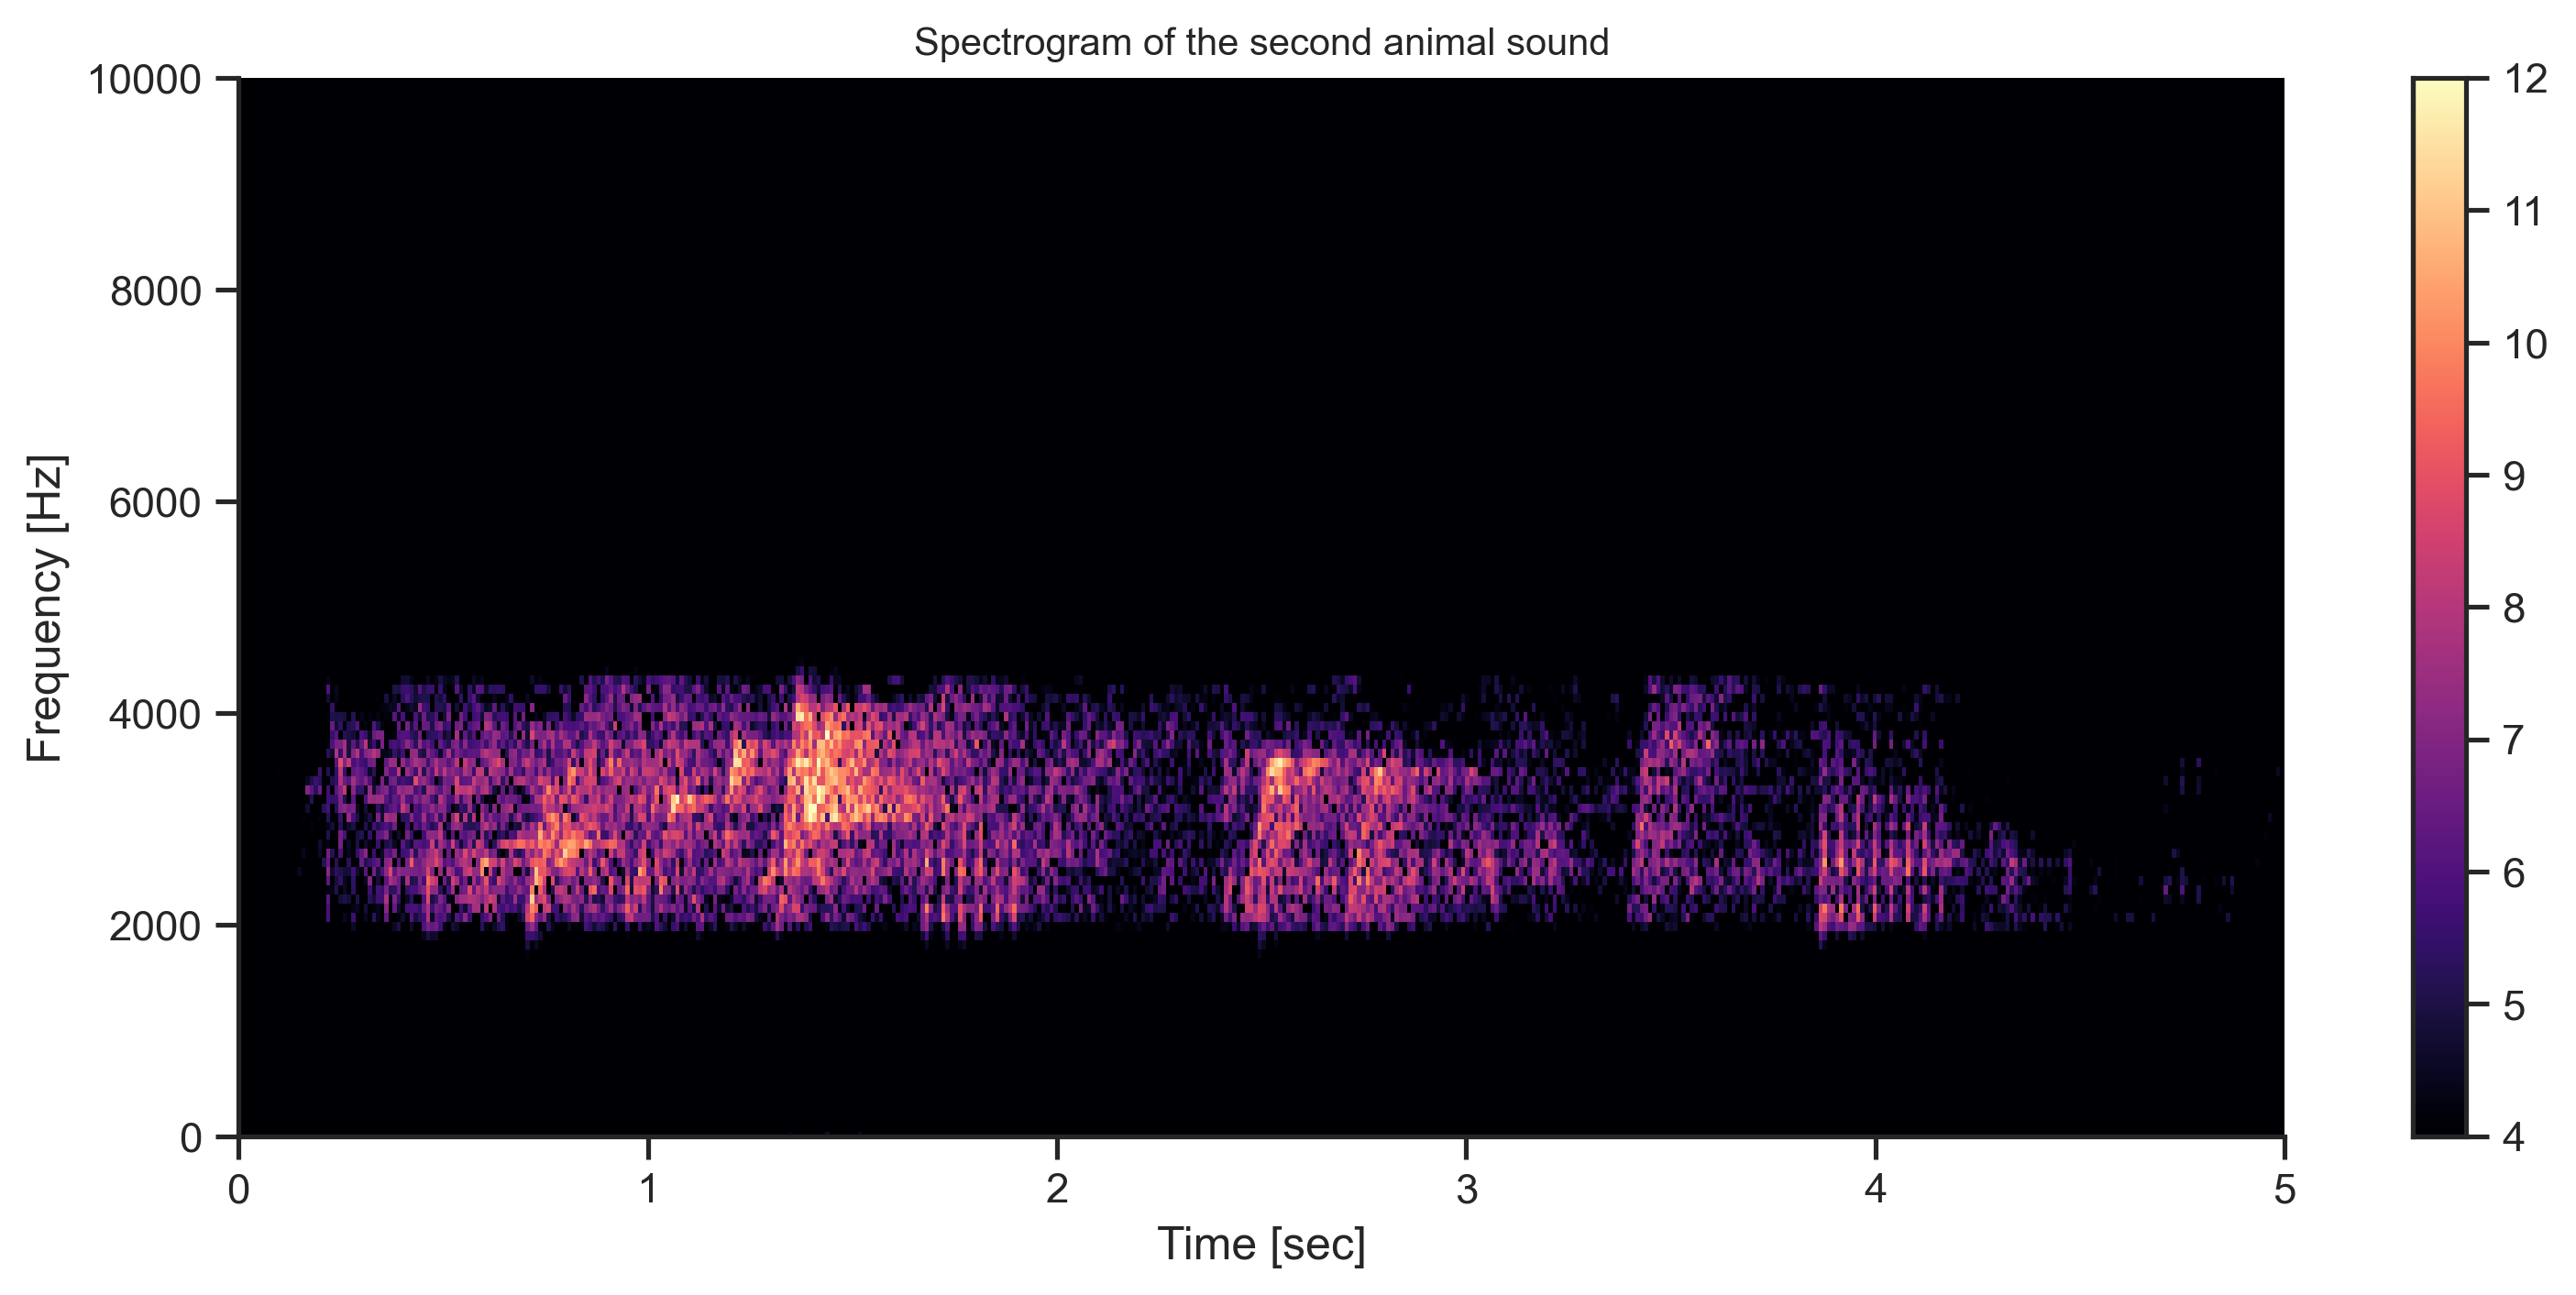

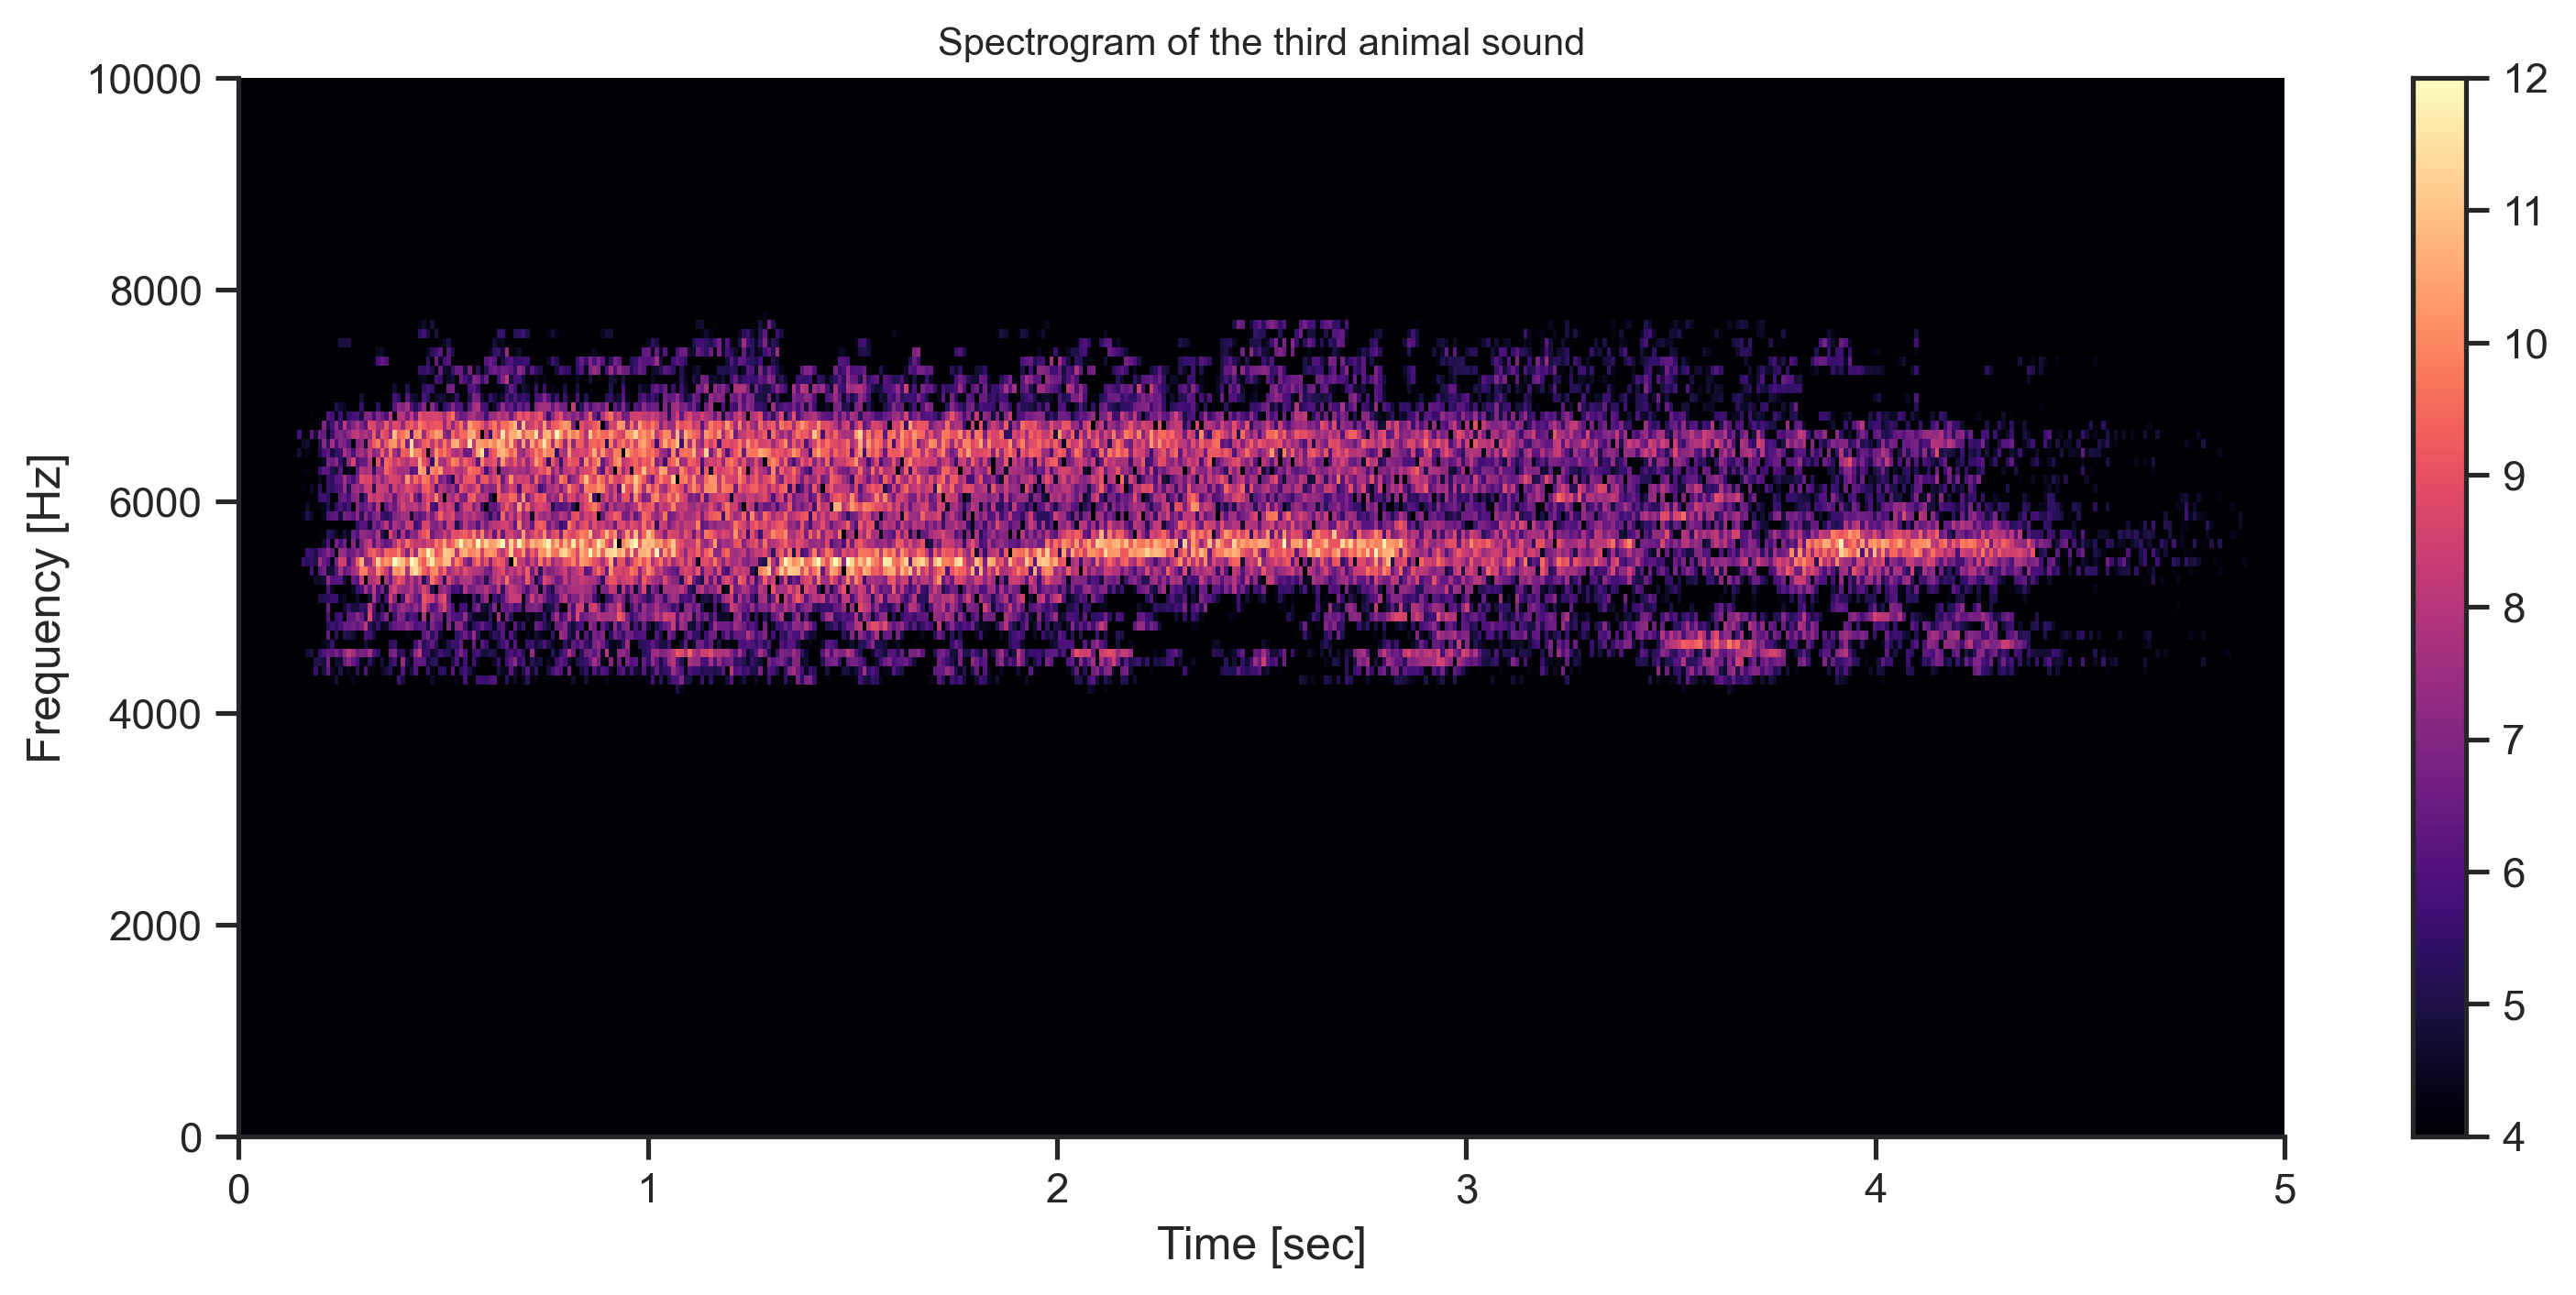

In [48]:
f, t, Sxx = signal.spectrogram(first_animal_sound, sample_rate)
plt.figure(figsize=(12, 5))
plt.pcolormesh(t, f, np.log(Sxx), cmap = 'magma', vmin = 4, vmax = 12)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.ylim(0,10000)
plt.xlim(0,5)
plt.title("Spectrogram of the first animal sound", fontsize=10)
sns.despine()
plt.show()

f, t, Sxx = signal.spectrogram(second_animal_sound, sample_rate)
plt.figure(figsize=(12, 5))
plt.pcolormesh(t, f, np.log(Sxx), cmap = 'magma', vmin = 4, vmax = 12)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.ylim(0,10000)
plt.xlim(0,5)
plt.title("Spectrogram of the second animal sound", fontsize=10)
sns.despine()
plt.show()

f, t, Sxx = signal.spectrogram(third_animal_sound, sample_rate)
plt.figure(figsize=(12, 5))
plt.pcolormesh(t, f, np.log(Sxx), cmap = 'magma', vmin = 4, vmax = 12)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.ylim(0,10000)
plt.xlim(0,5)
plt.title("Spectrogram of the third animal sound", fontsize=10)
sns.despine()
plt.show()

# 3. Use Butterworth bandpass filter to isolate only the second animal sound

I have only utilised a filter that assigns a weight of 0 or 1 to frequencies that should be eliminated or kept. Now, I will create a filter for the second animal that transitions more smoothly between the removed frequencies and those retained in the spectrum.

I adapted the Butterworth band pass filter code from this link: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html.

In [32]:
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

## 3.1. Butterworth bandpass filter with various orders

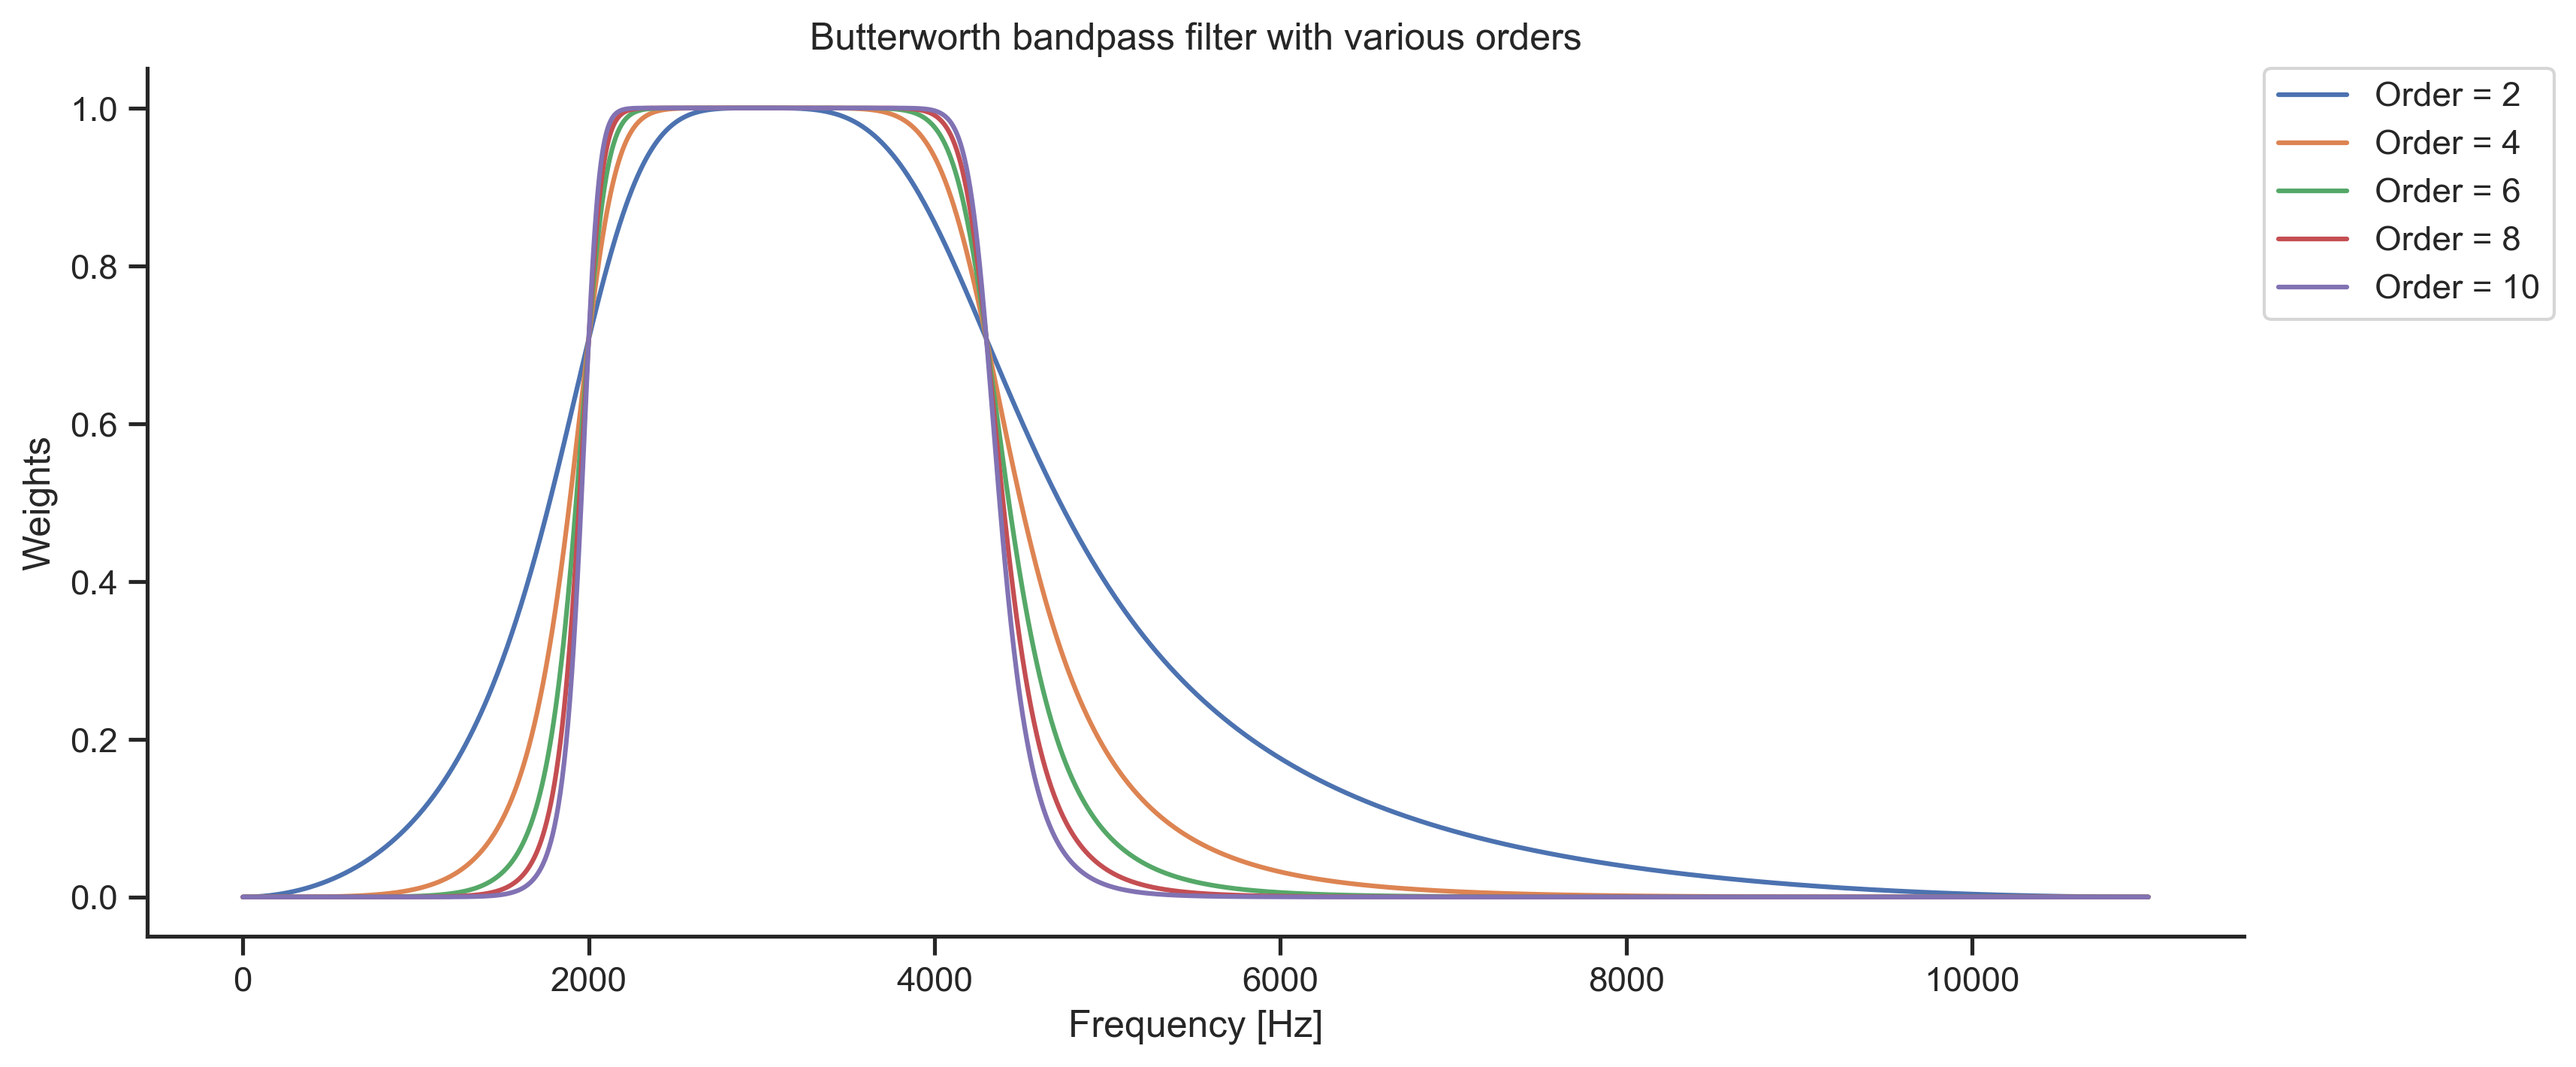

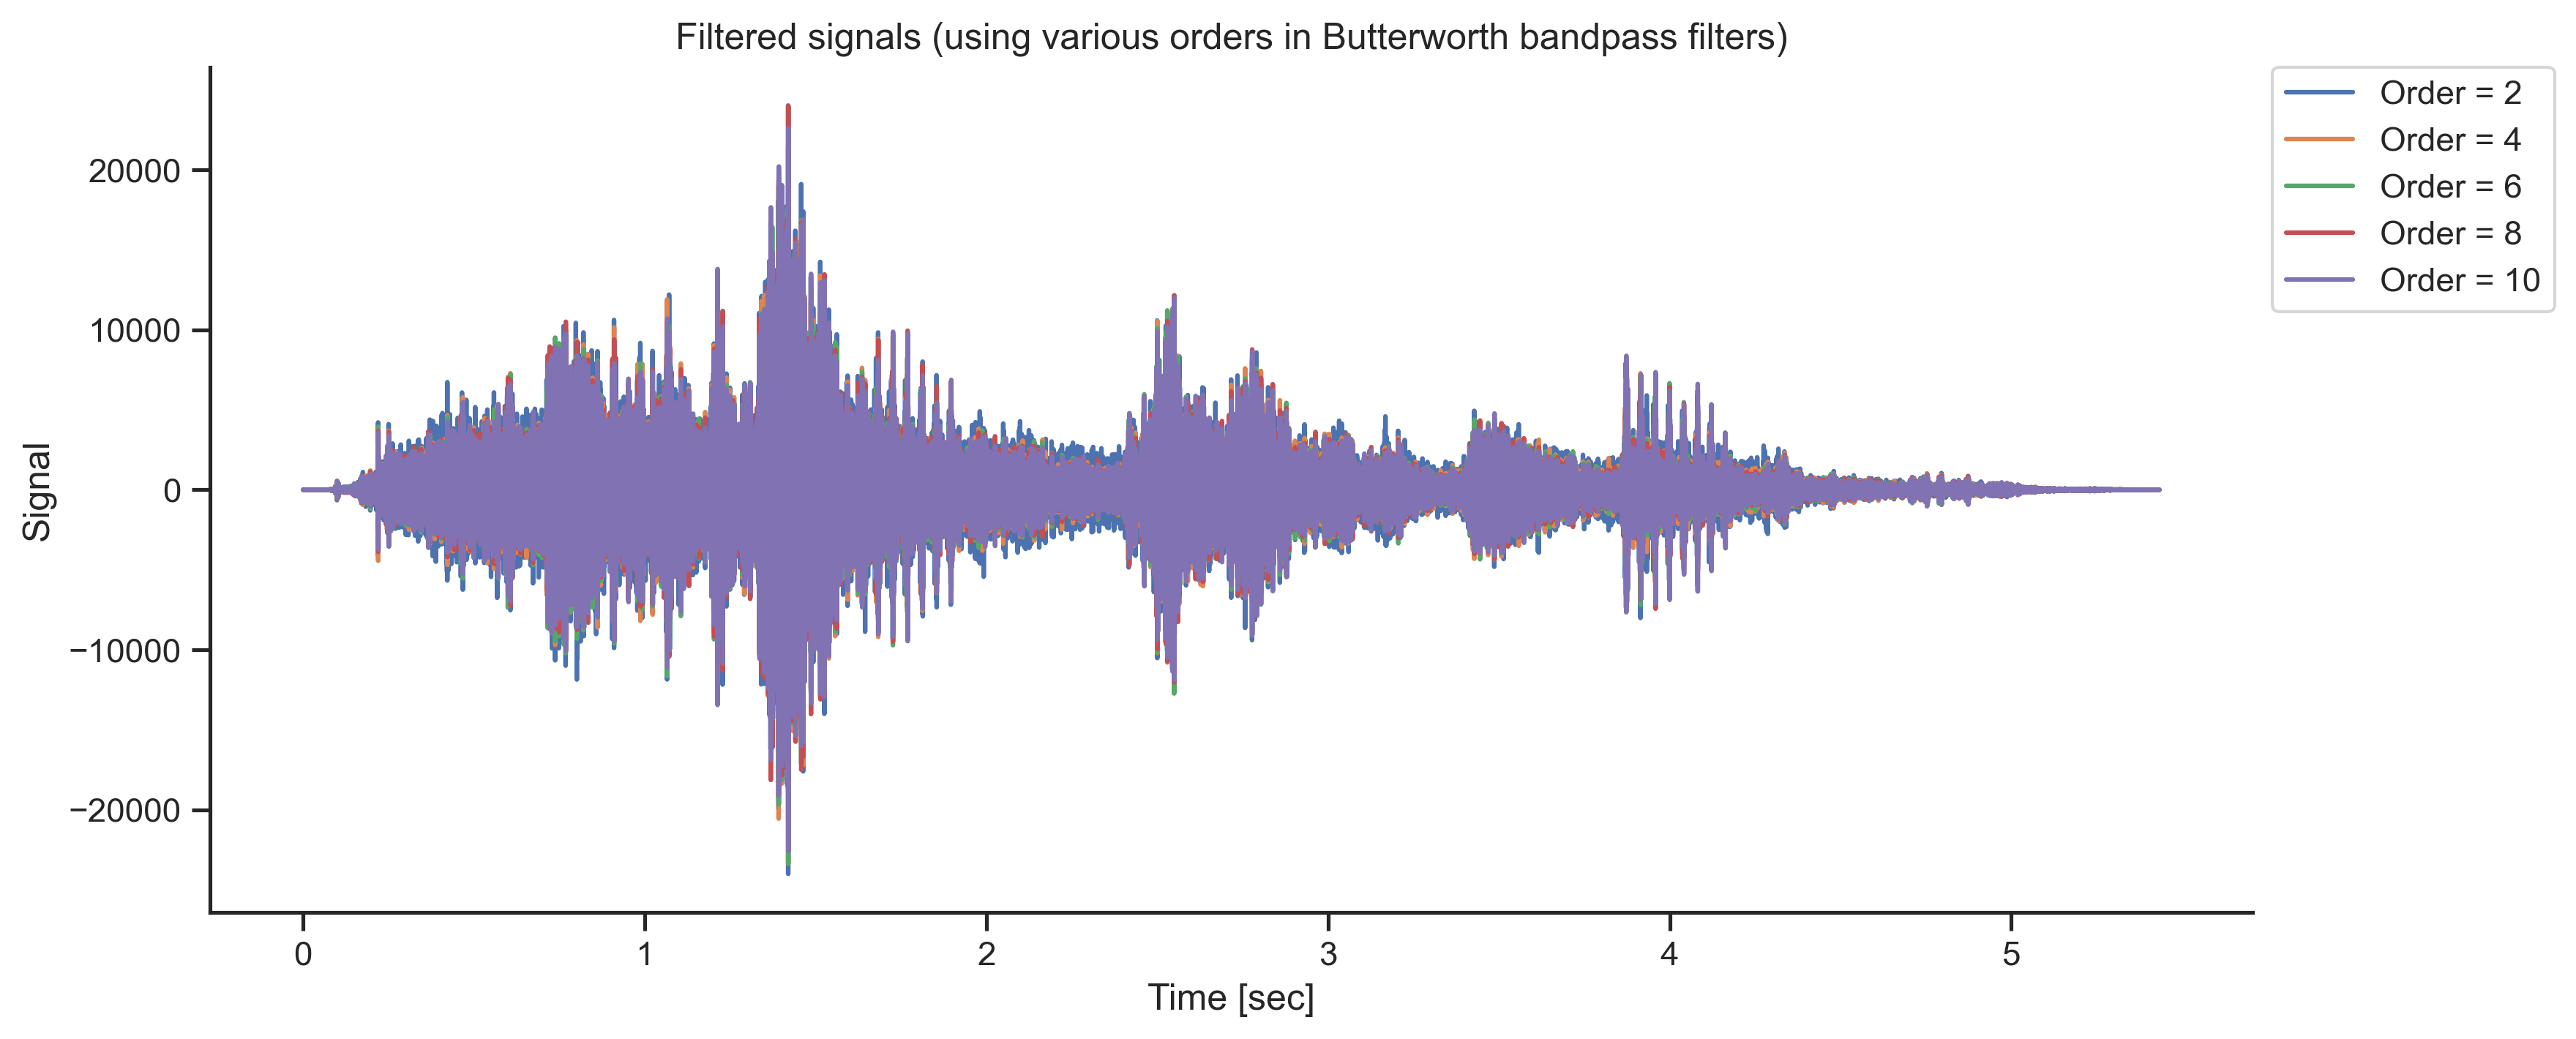

In [56]:
fs = sample_rate
lowcut = 2000
highcut = 4300

# Plot Butterworth bandpass filter in different orders

plt.figure(figsize=(12, 5))
for order in range(2,12,2):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label= f"Order = {order}")

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.0, frameon = True)
plt.ylabel('Weights')
plt.xlabel('Frequency [Hz]')
plt.title("Butterworth bandpass filter with various orders")
sns.despine()
plt.show()

# Plot Filtered signals (using different Butterworth bandpass filters)

plt.figure(figsize=(12, 5))
for order in range(2,12,2):
    y = butter_bandpass_filter(data, lowcut, highcut, fs, order)
    plt.plot(x, y, label= f"Order = {order}")
    
plt.xlabel('Time [sec]')
plt.ylabel('Signal')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.0, frameon = True)
plt.title("Filtered signals (using various orders in Butterworth bandpass filters)")
sns.despine()
plt.show() 

## 3.2. Butterworth bandpass filter: `order 10`

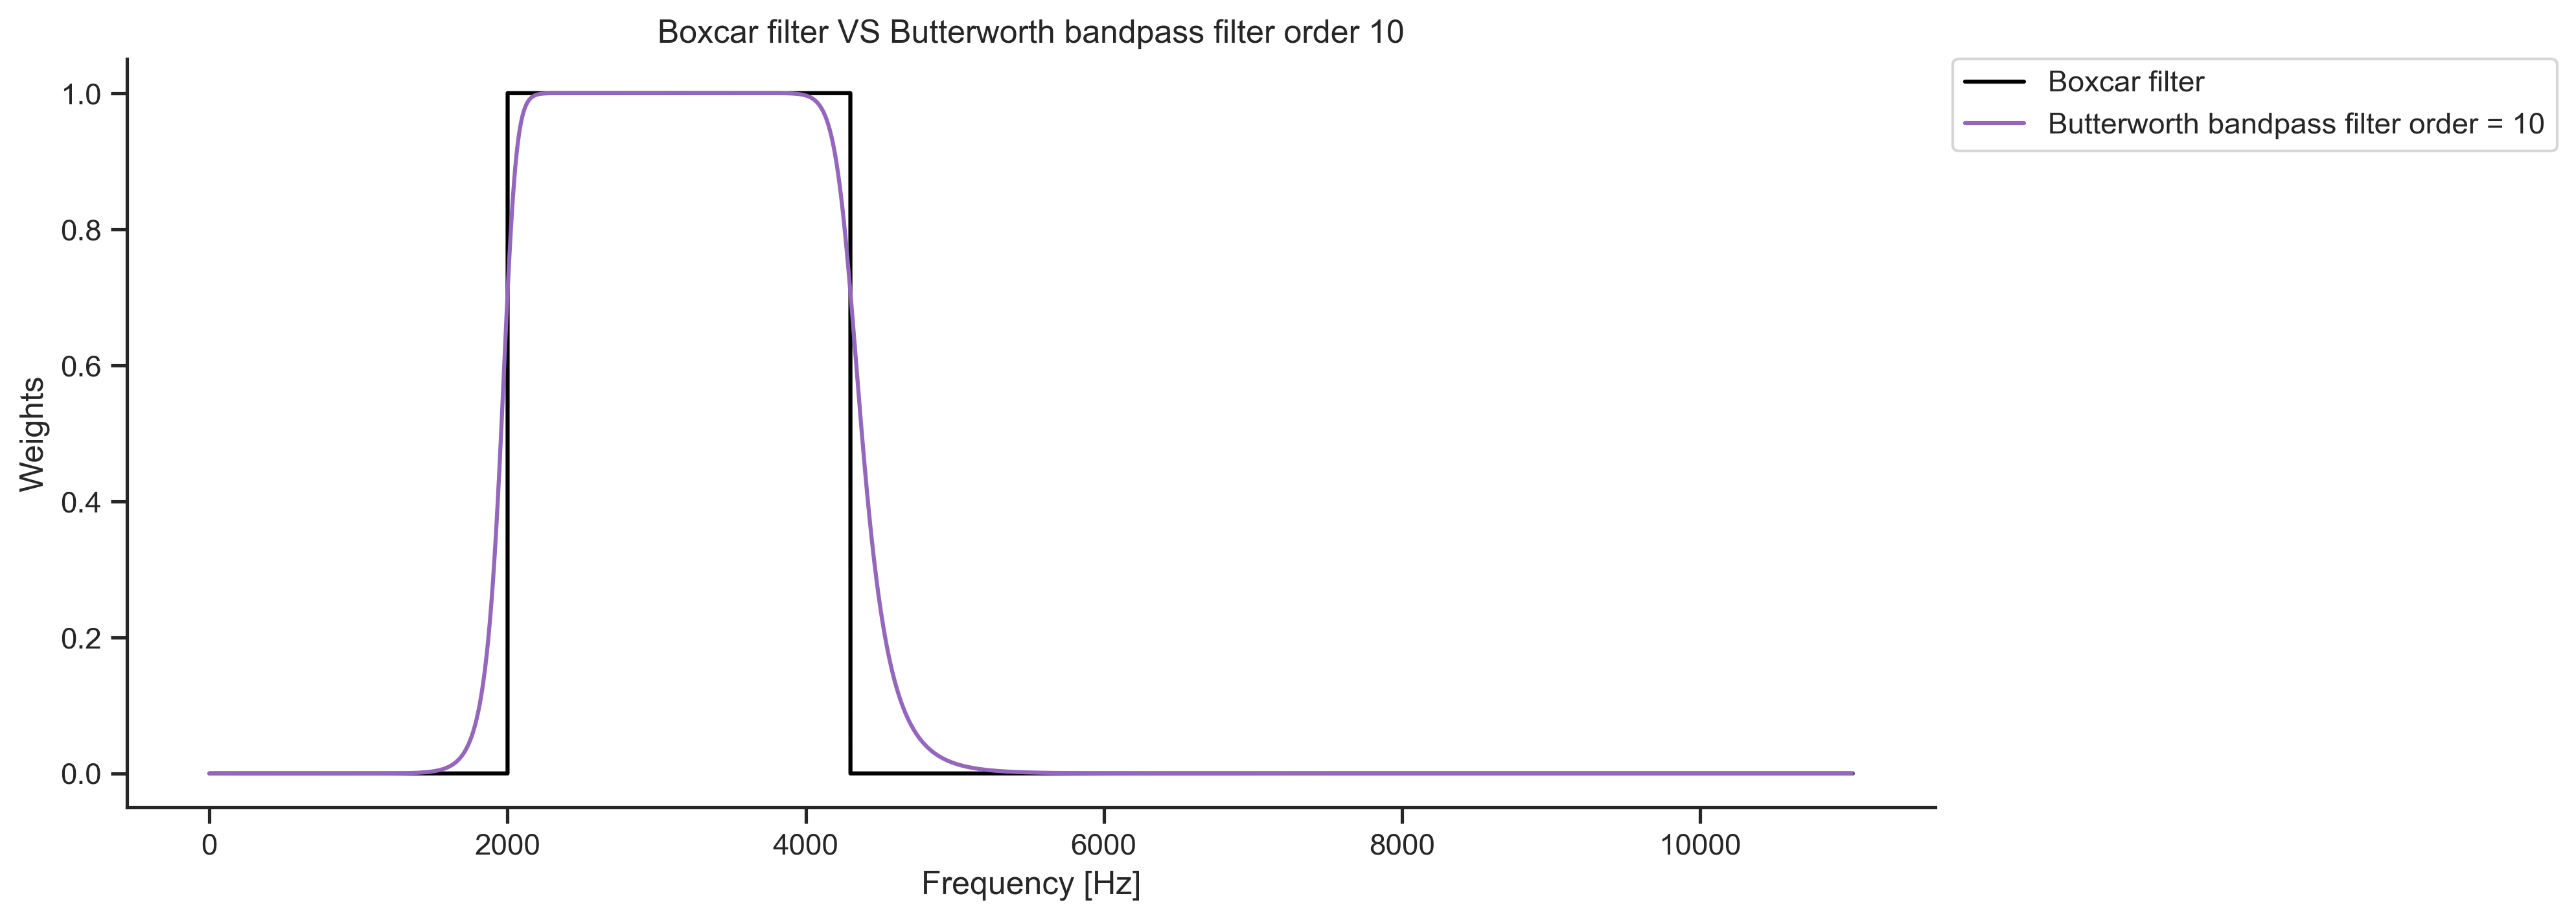

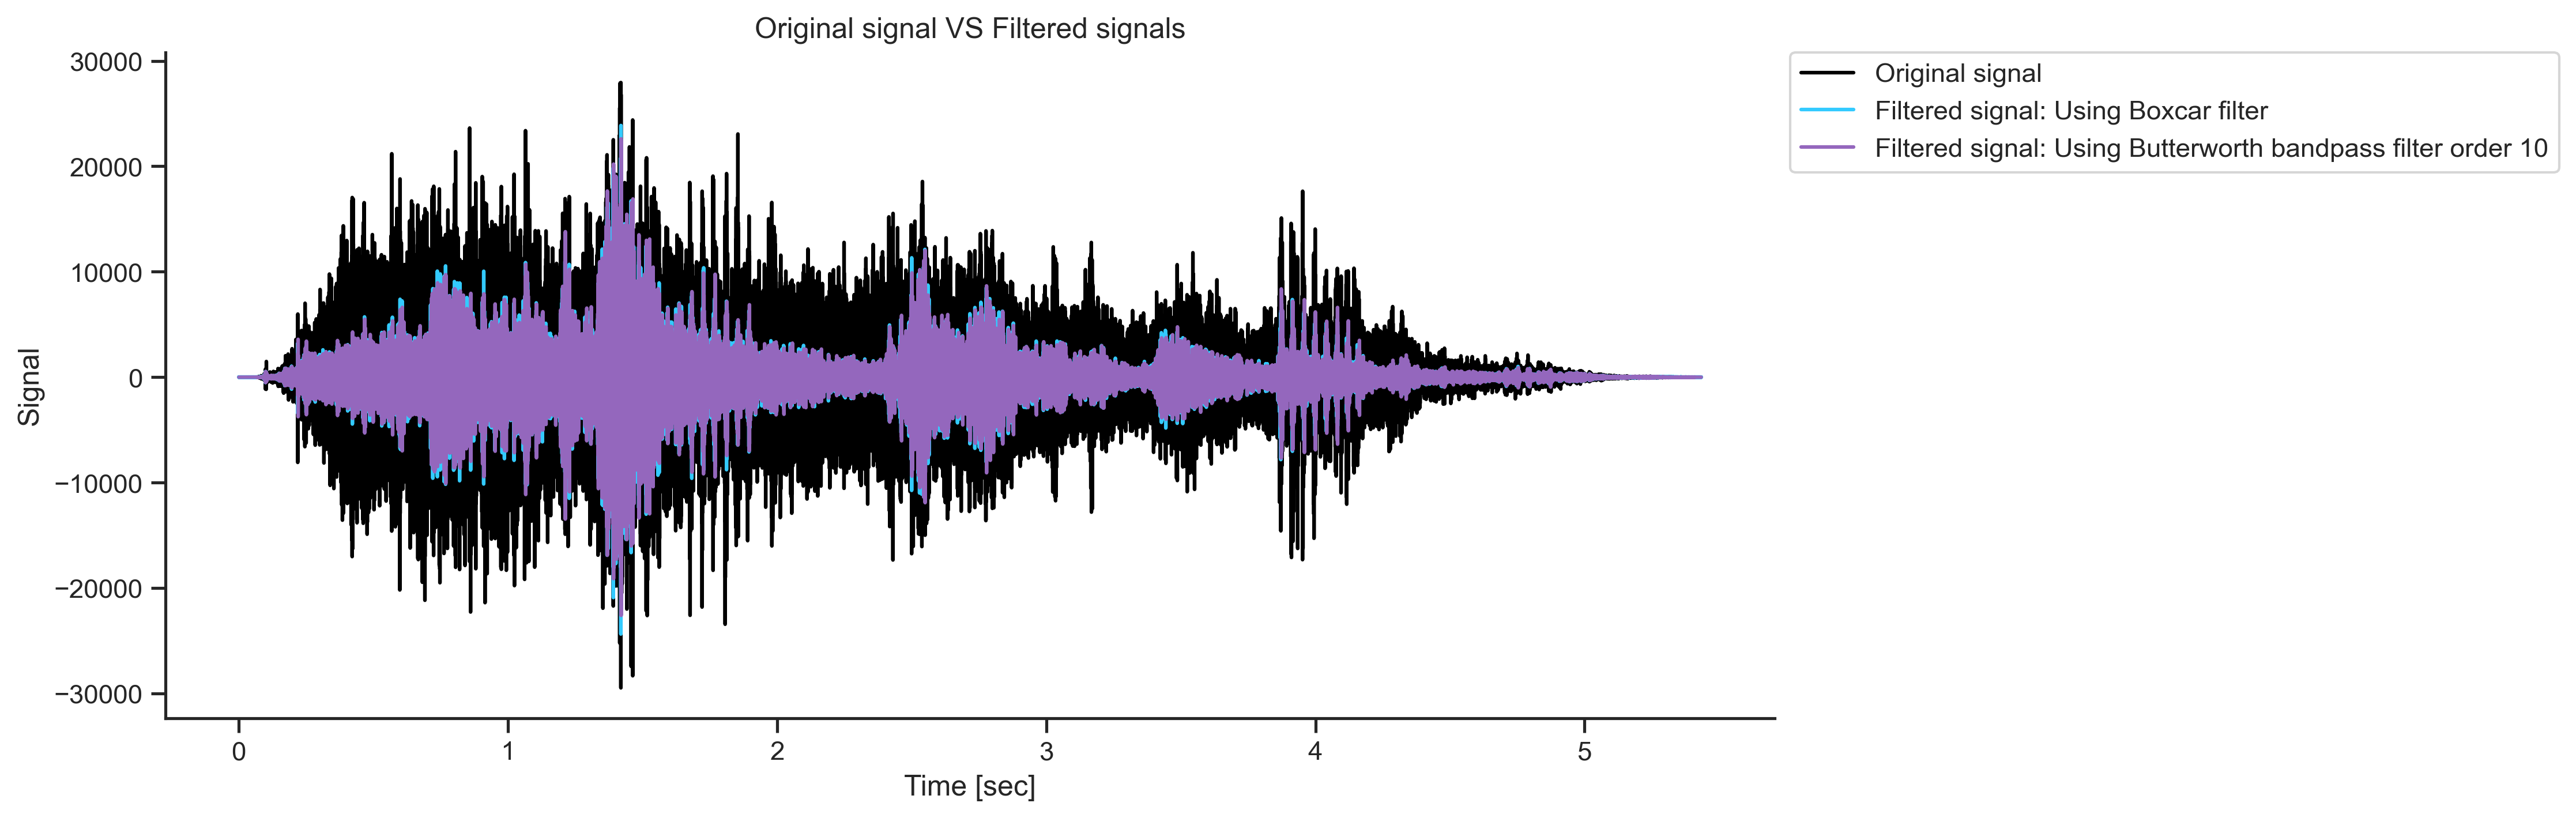

In [76]:
fs = sample_rate
lowcut = 2000
highcut = 4300
order = 10

# Plot Unsmooth filter VS Butterworth bandpass filter (with different orders)

real_freqs_positive = real_freqs[len(real_freqs)//2:]
weights = np.zeros(len(real_freqs_positive))
weights[(real_freqs_positive > lowcut) & (real_freqs_positive < highcut)] = 1.0

plt.figure(figsize=(12, 5))
plt.plot(real_freqs_positive, weights, color = "#000000", label = "Boxcar filter")

b, a = butter_bandpass(lowcut, highcut, fs, order)
w, h = freqz(b, a, worN=2000)

plt.plot((fs * 0.5 / np.pi) * w, abs(h), label= f"Butterworth bandpass filter order = {order}", color = "#9467bd")
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.0, frameon = True)
plt.ylabel('Weights')
plt.xlabel('Frequency [Hz]')
plt.title(f"Boxcar filter VS Butterworth bandpass filter order {order}")
sns.despine()
plt.show() 


# Plot Original signal VS Filtered signals

plt.figure(figsize=(12, 5))
plt.plot(x, data, label = "Original signal", color = "#000000")
plt.plot(x, second_animal_sound, label = "Filtered signal: Using Boxcar filter", color = "#33CAFF")

second_animal_sound_butterworth = butter_bandpass_filter(data, lowcut, highcut, fs, order)

plt.plot(x, second_animal_sound_butterworth, label= f'Filtered signal: Using Butterworth bandpass filter order {order}', color = "#9467bd")
plt.xlabel('Time [sec]')
plt.ylabel('Signal')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.0, frameon = True)
plt.title("Original signal VS Filtered signals")
sns.despine()
plt.show()


### Isolate the second animal sound (using Butterworth bandpass filter order 10)

In [59]:
ipd.Audio(second_animal_sound_butterworth, rate = sample_rate) 

### Visualise the spectrogram of the second animal sound (Boxcar VS Butterworth bandpass filter order 10)

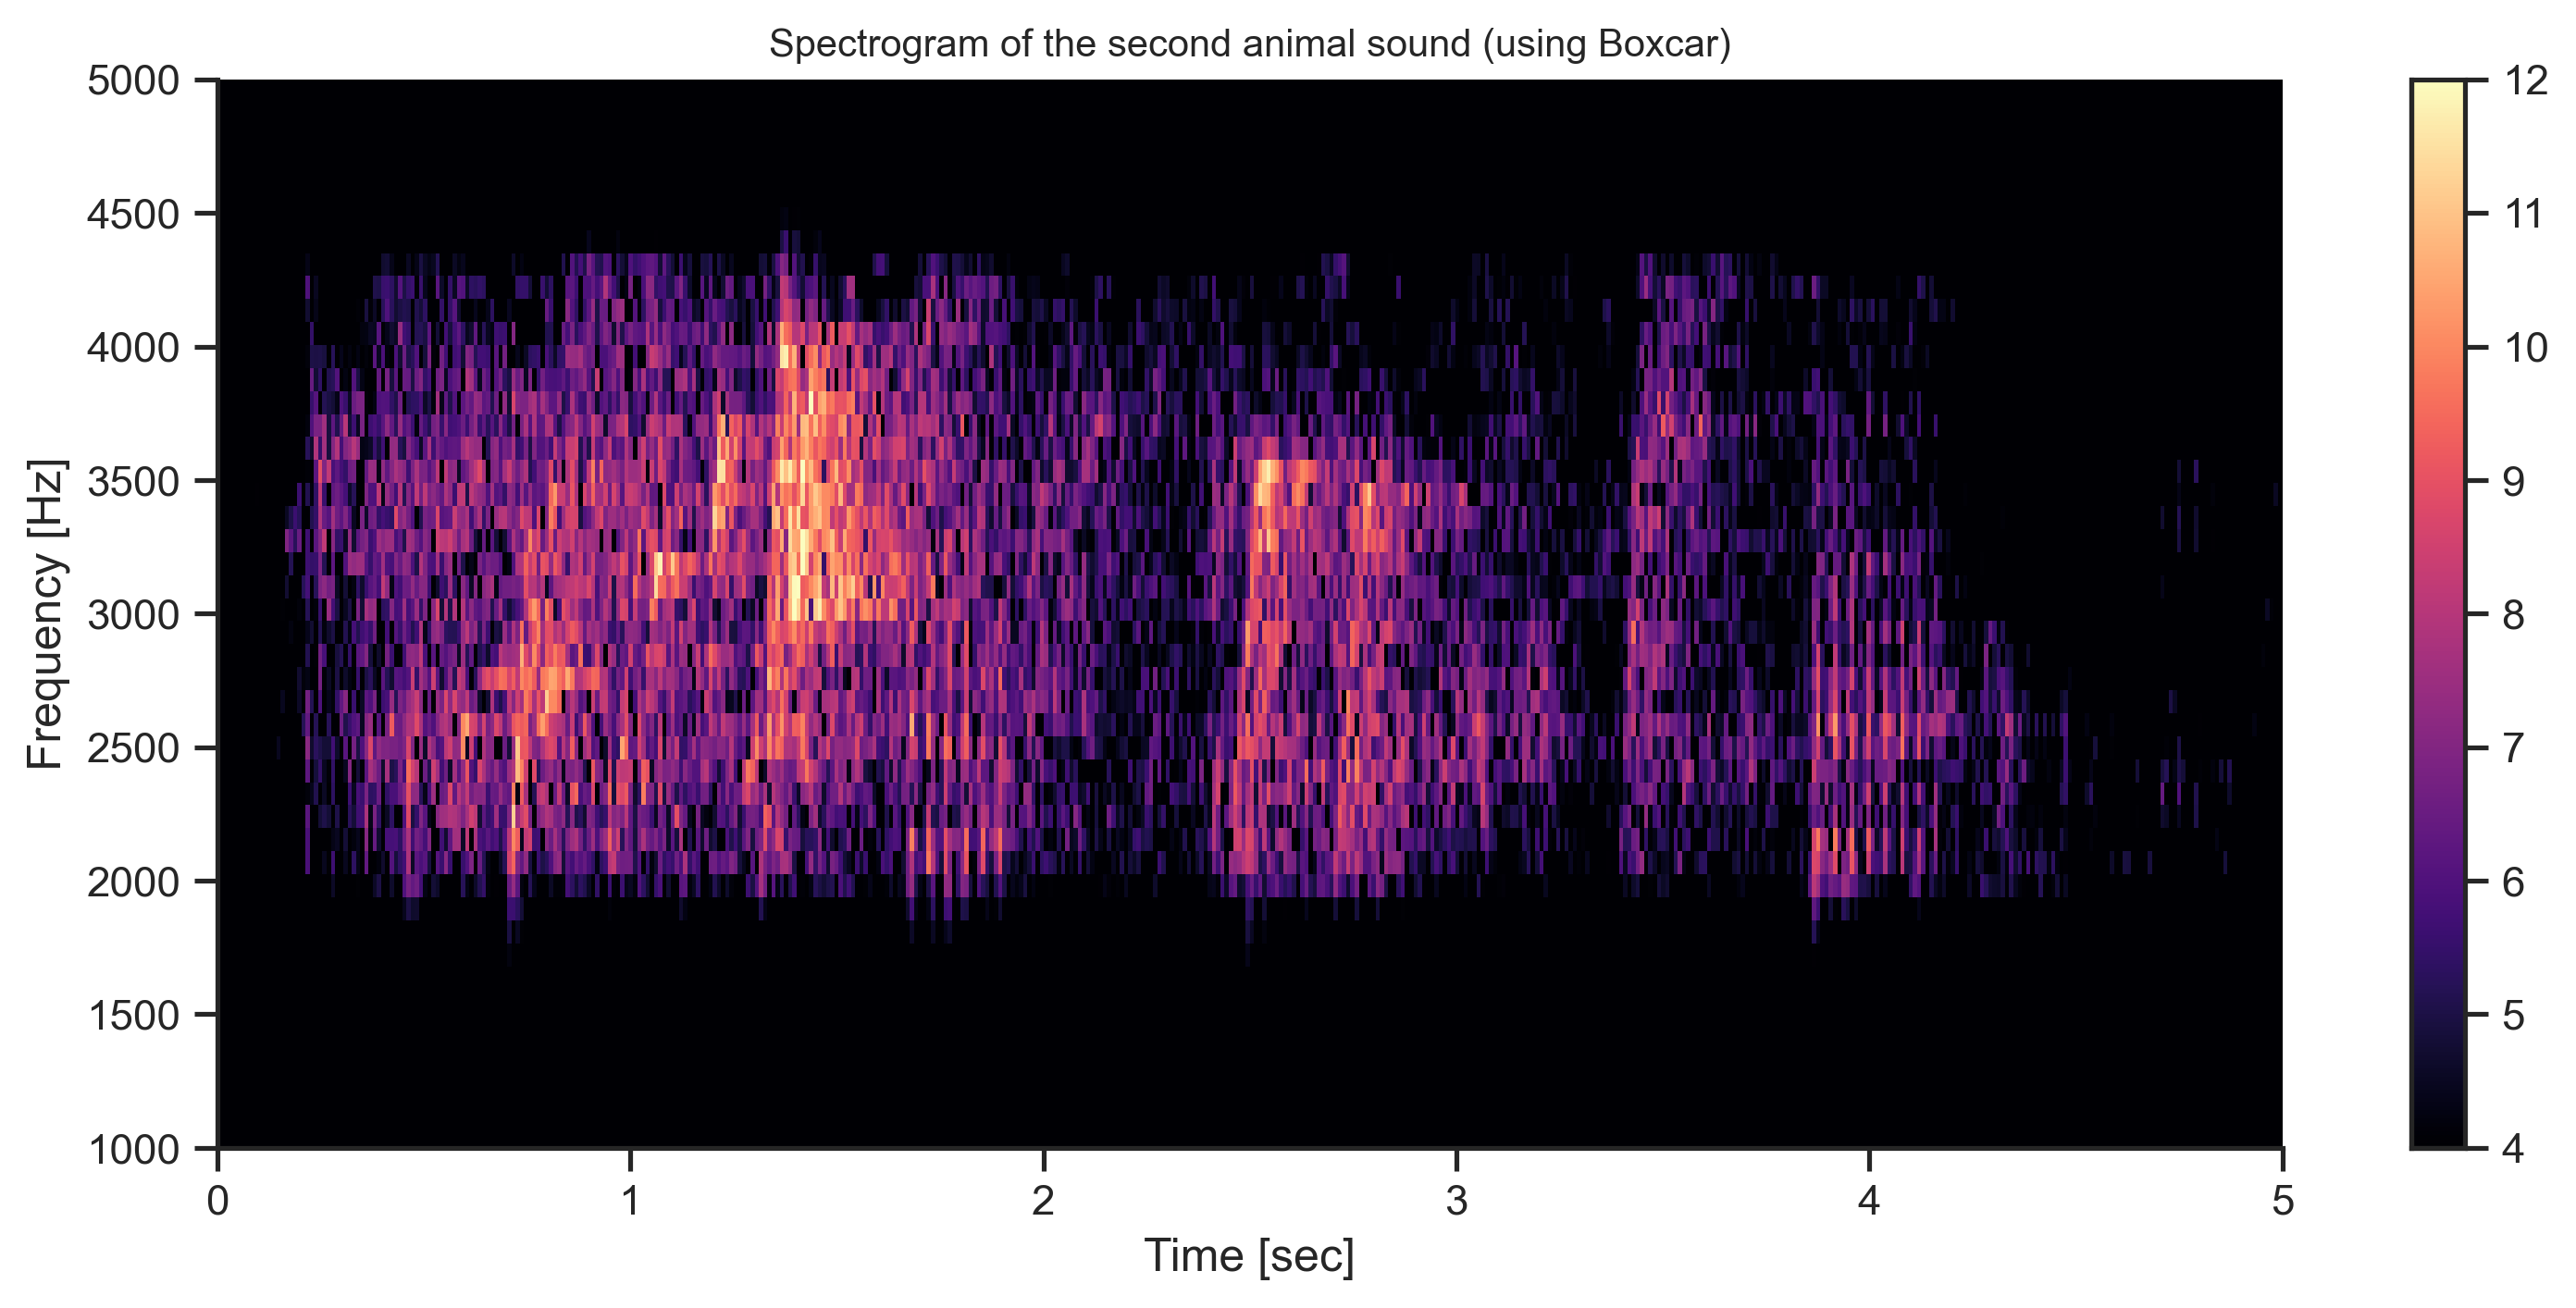

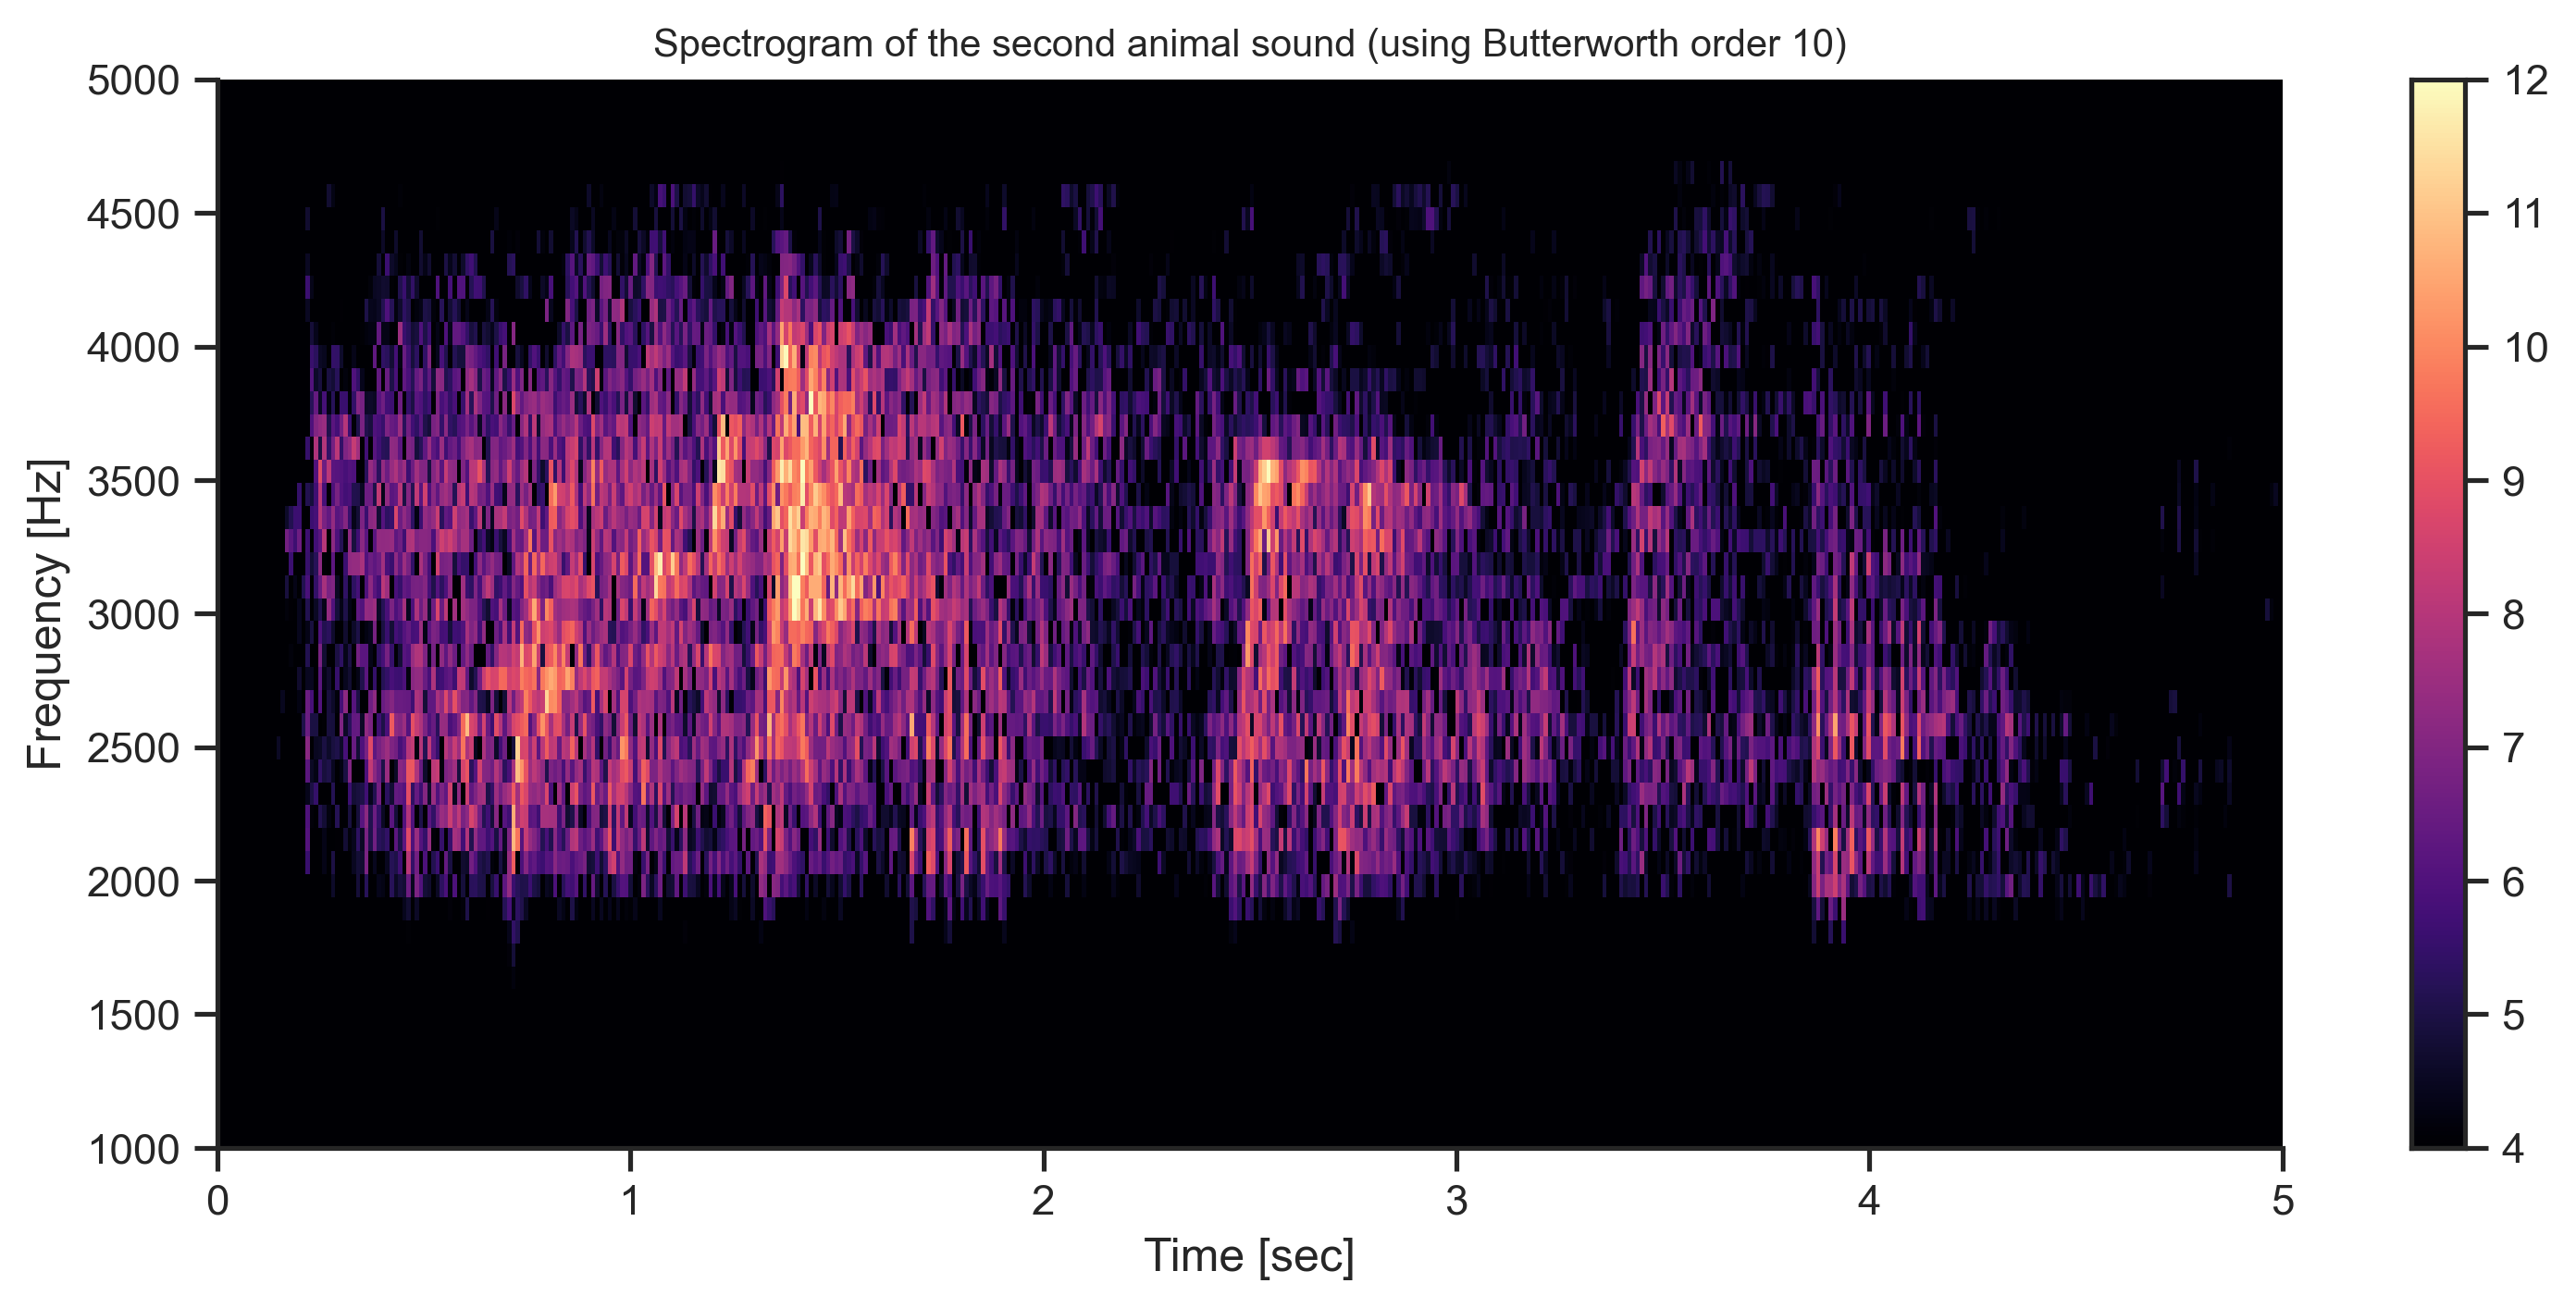

In [75]:
f, t, Sxx = signal.spectrogram(second_animal_sound, sample_rate)
plt.figure(figsize=(12, 5))
plt.pcolormesh(t, f, np.log(Sxx), cmap = 'magma', vmin = 4, vmax = 12)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.ylim(1000,5000)
plt.xlim(0,5)
plt.title("Spectrogram of the second animal sound (using Boxcar)", fontsize=10)
sns.despine()
plt.show()

f, t, Sxx = signal.spectrogram(second_animal_sound_butterworth, sample_rate)
plt.figure(figsize=(12, 5))
plt.pcolormesh(t, f, np.log(Sxx), cmap = 'magma', vmin = 4, vmax = 12)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.ylim(1000,5000)
plt.xlim(0,5)
plt.title("Spectrogram of the second animal sound (using Butterworth order 10)", fontsize=10)
sns.despine()
plt.show()

# 4. Use Gaussian filter to isolate only the second animal sound

## Design the Gaussian filter

### Design the Gaussian distribution

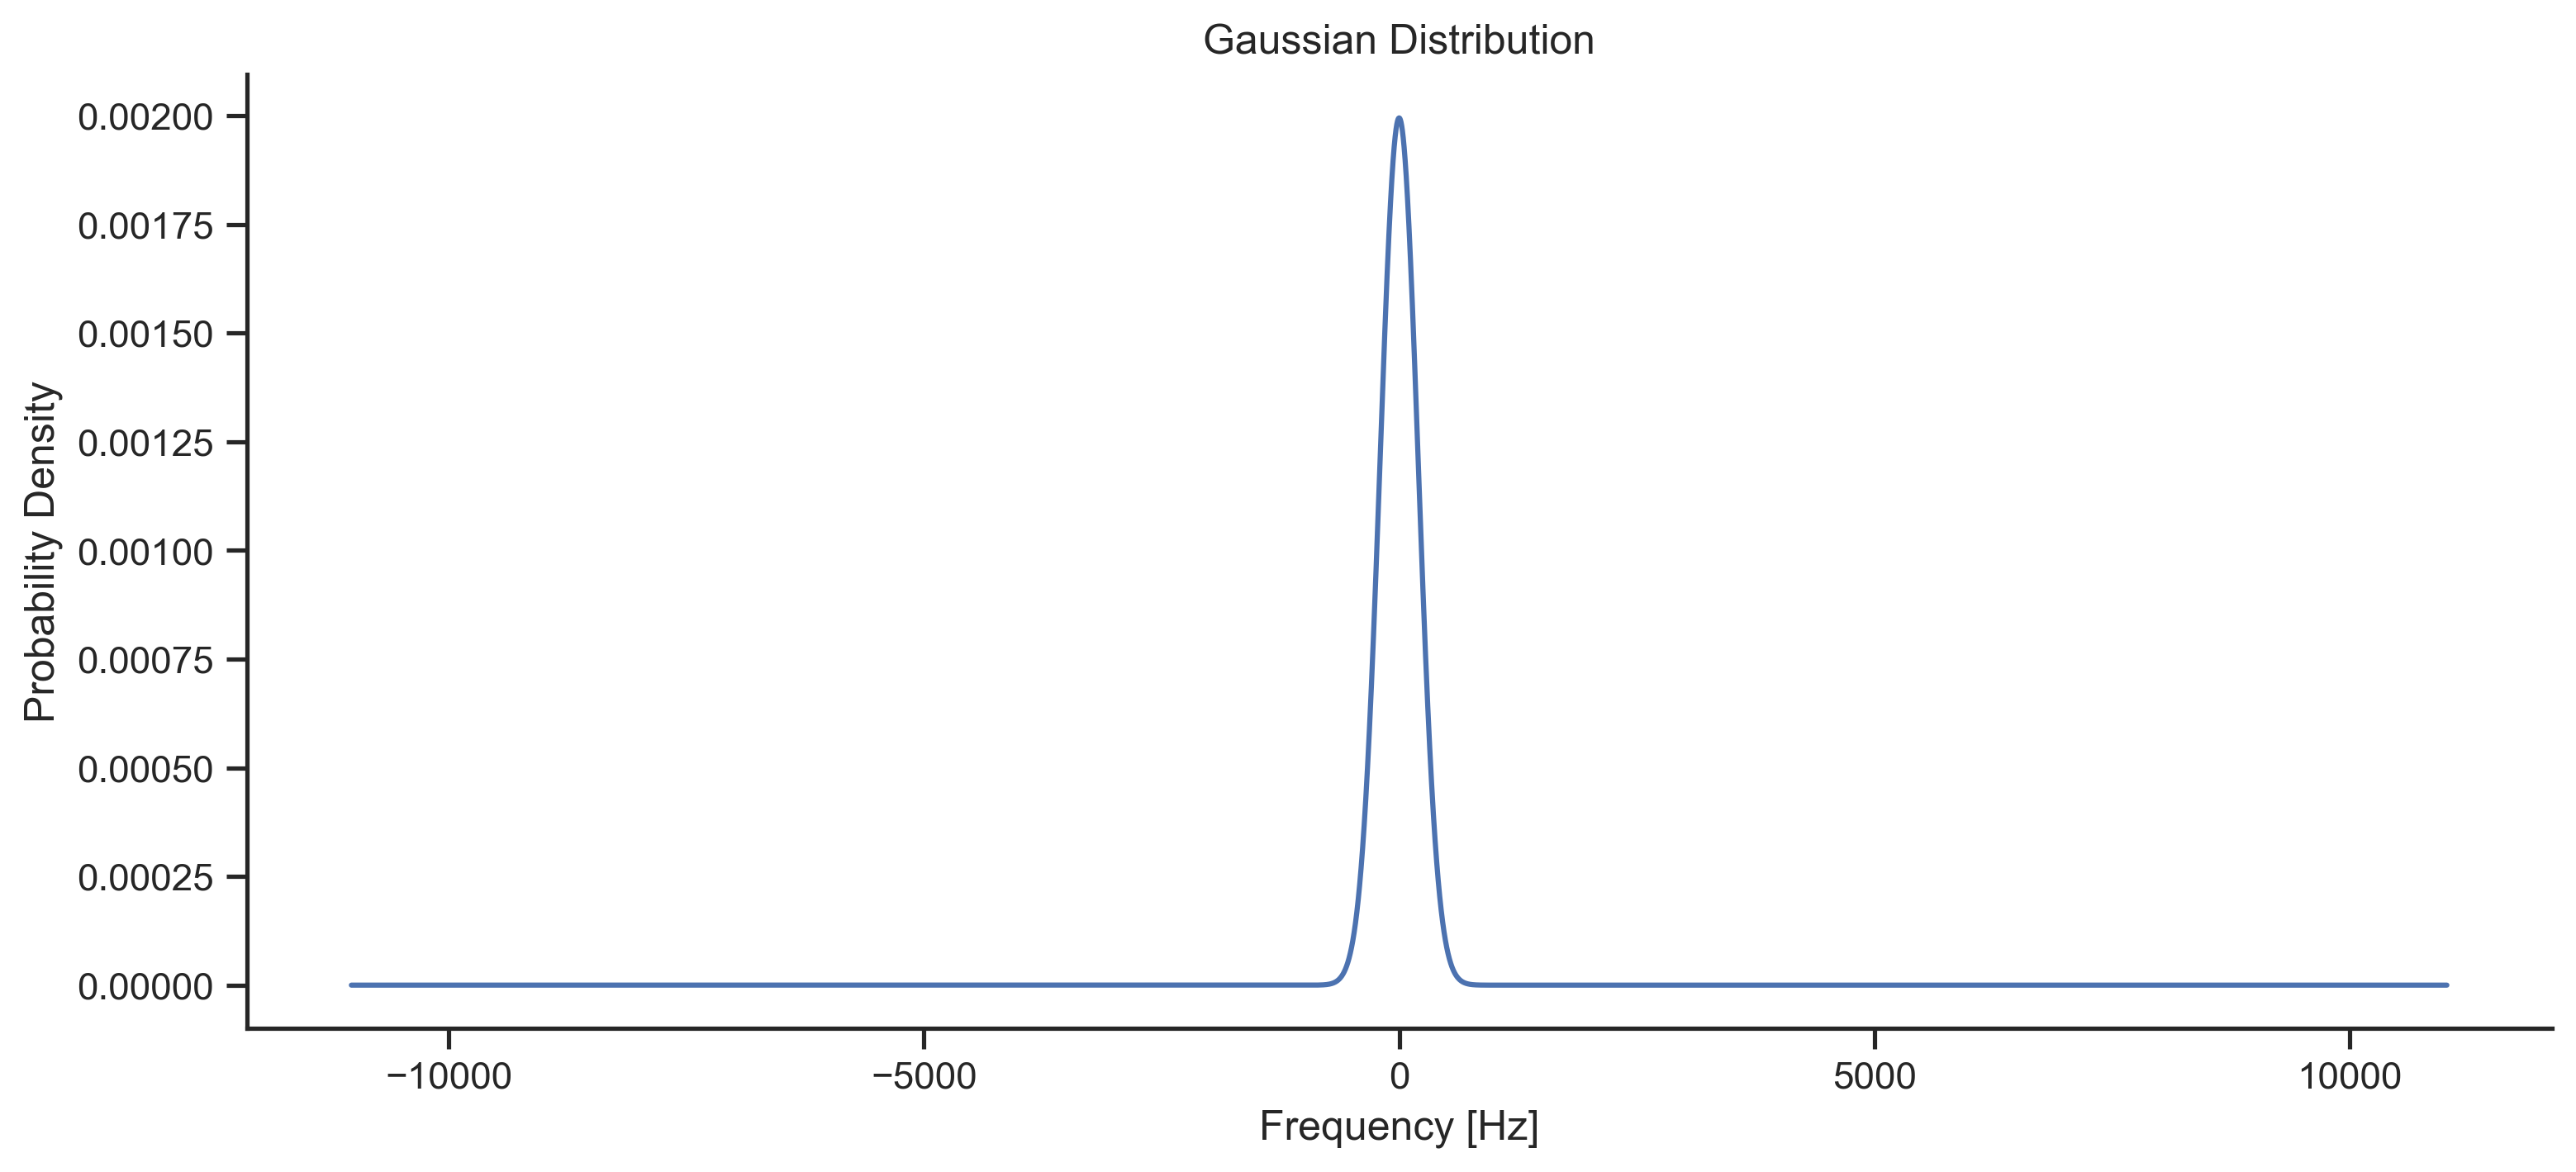

In [61]:
mu = 0  # Mean
sigma = 200  # Standard deviation

f = real_freqs
y = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(f - mu)**2 / (2 * sigma**2))

plt.figure(figsize=(12, 5))
plt.plot(f, y)
plt.title('Gaussian Distribution')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Probability Density')
sns.despine()
plt.show()

### The original boxcar filter for the second animal

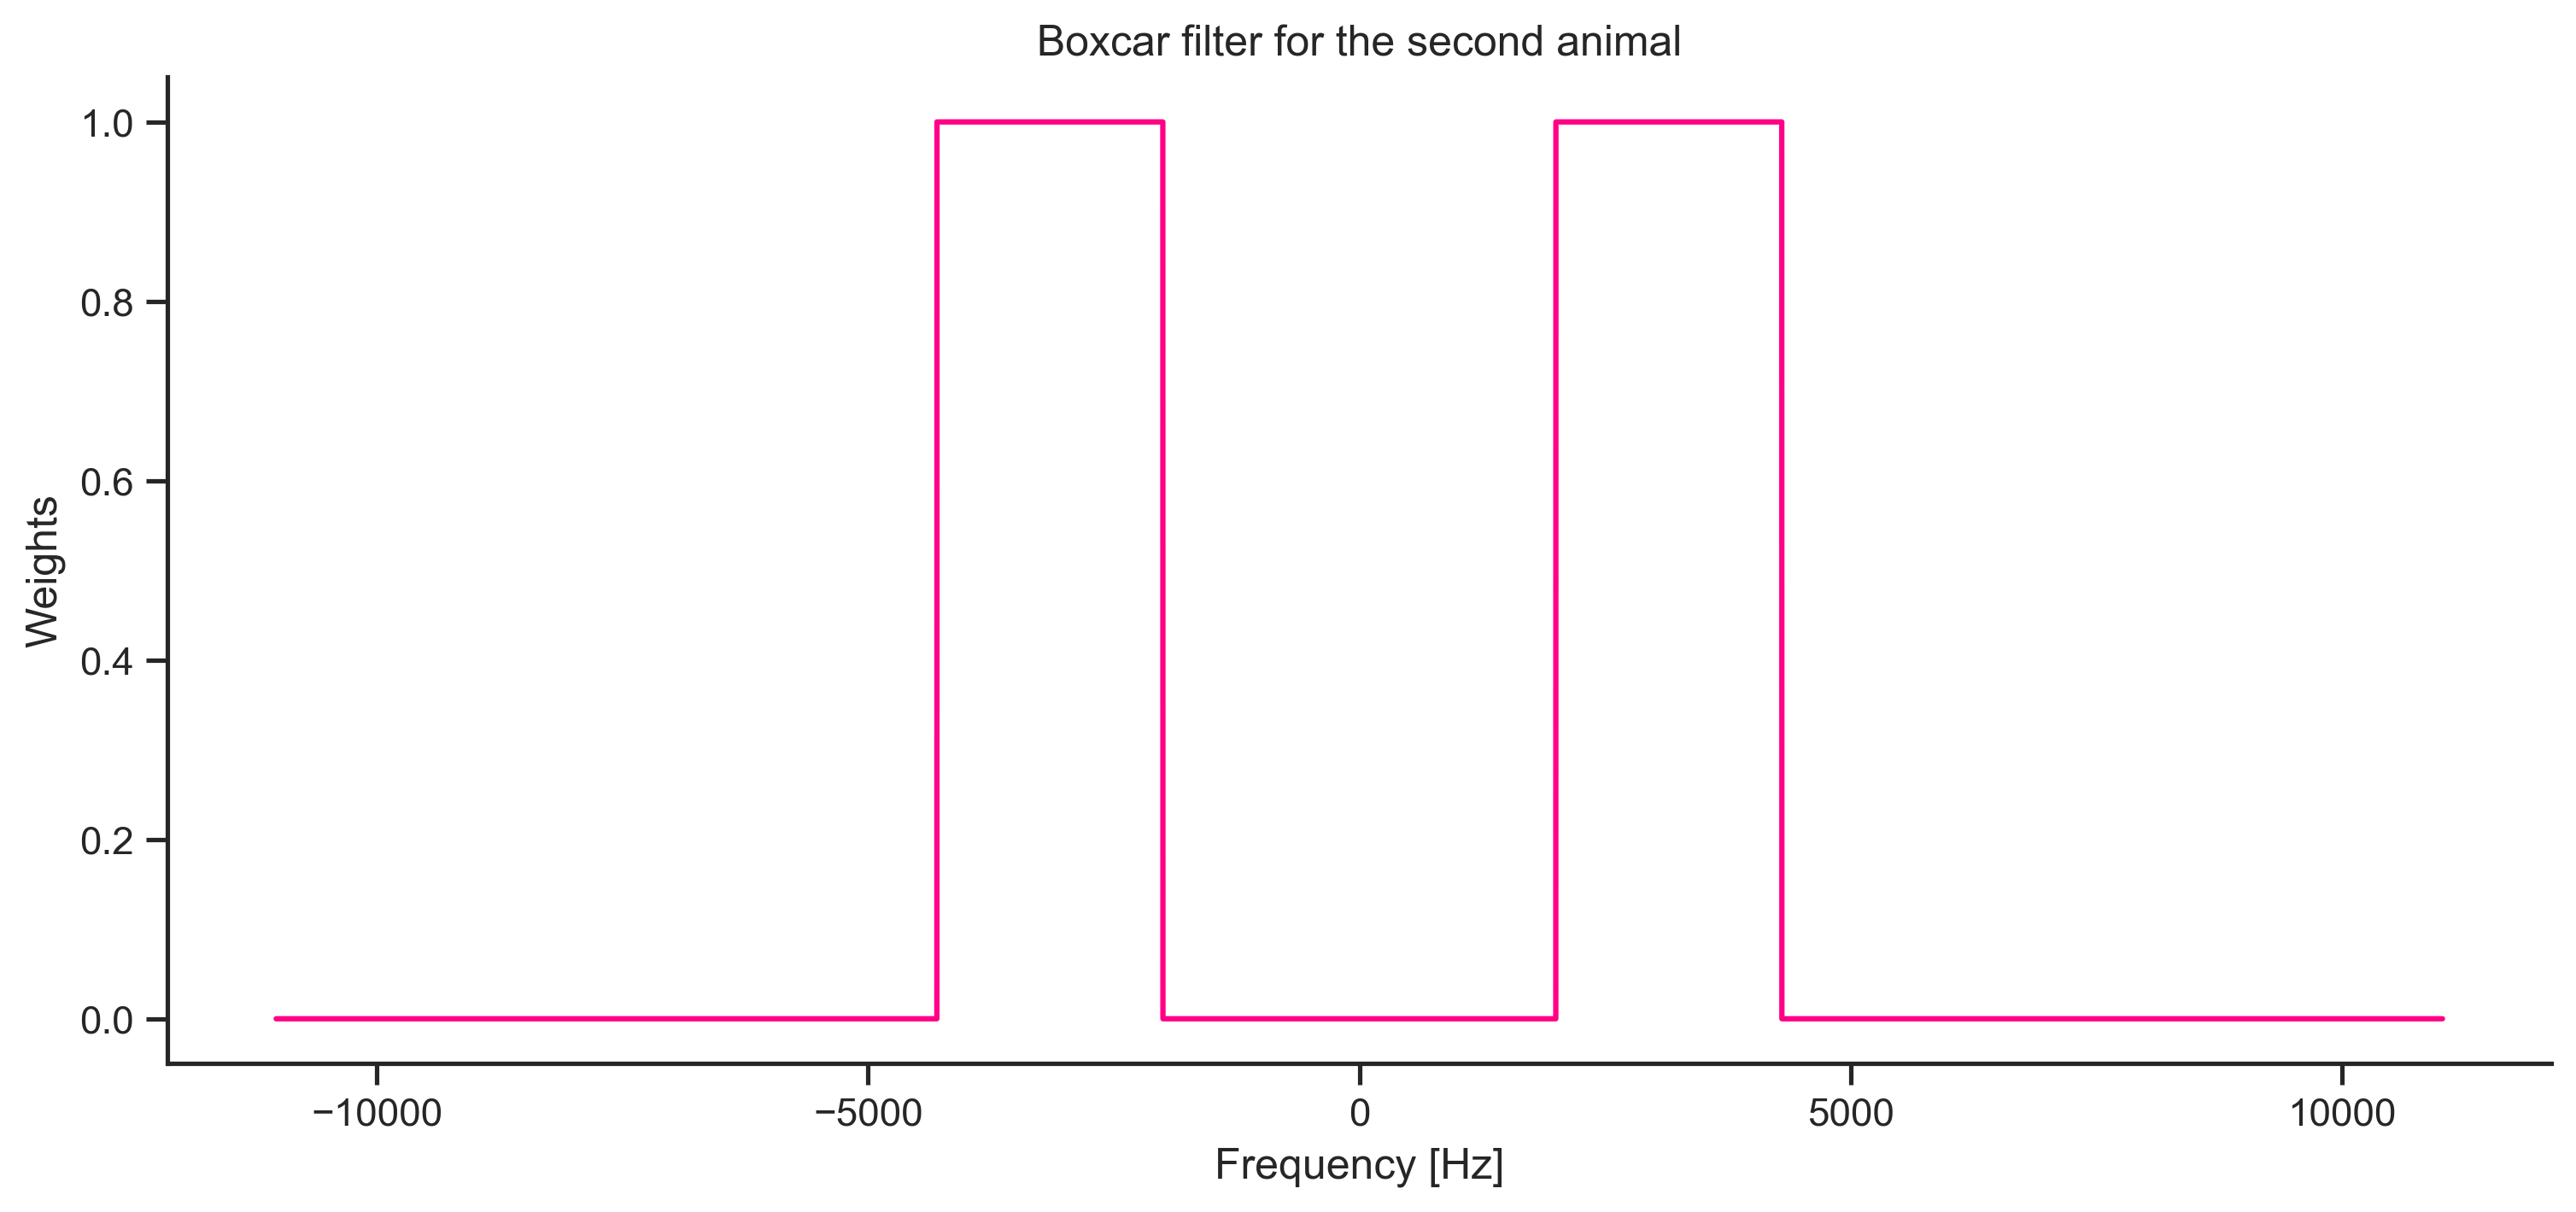

In [65]:
minf = 2000
maxf = 4300
weights = np.zeros(len(real_freqs))
weights[(real_freqs > minf) & (real_freqs < maxf)] = 1.0
weights[(real_freqs < -minf) & (real_freqs > -maxf)] = 1.0

plt.figure(figsize=(12, 5))
plt.plot(real_freqs, weights, color = "#FF0087")
plt.title("Boxcar filter for the second animal")
plt.ylabel('Weights')
plt.xlabel('Frequency [Hz]')
sns.despine()
plt.show()

### Convolution: Boxcar * Gaussian

Result size: 119808


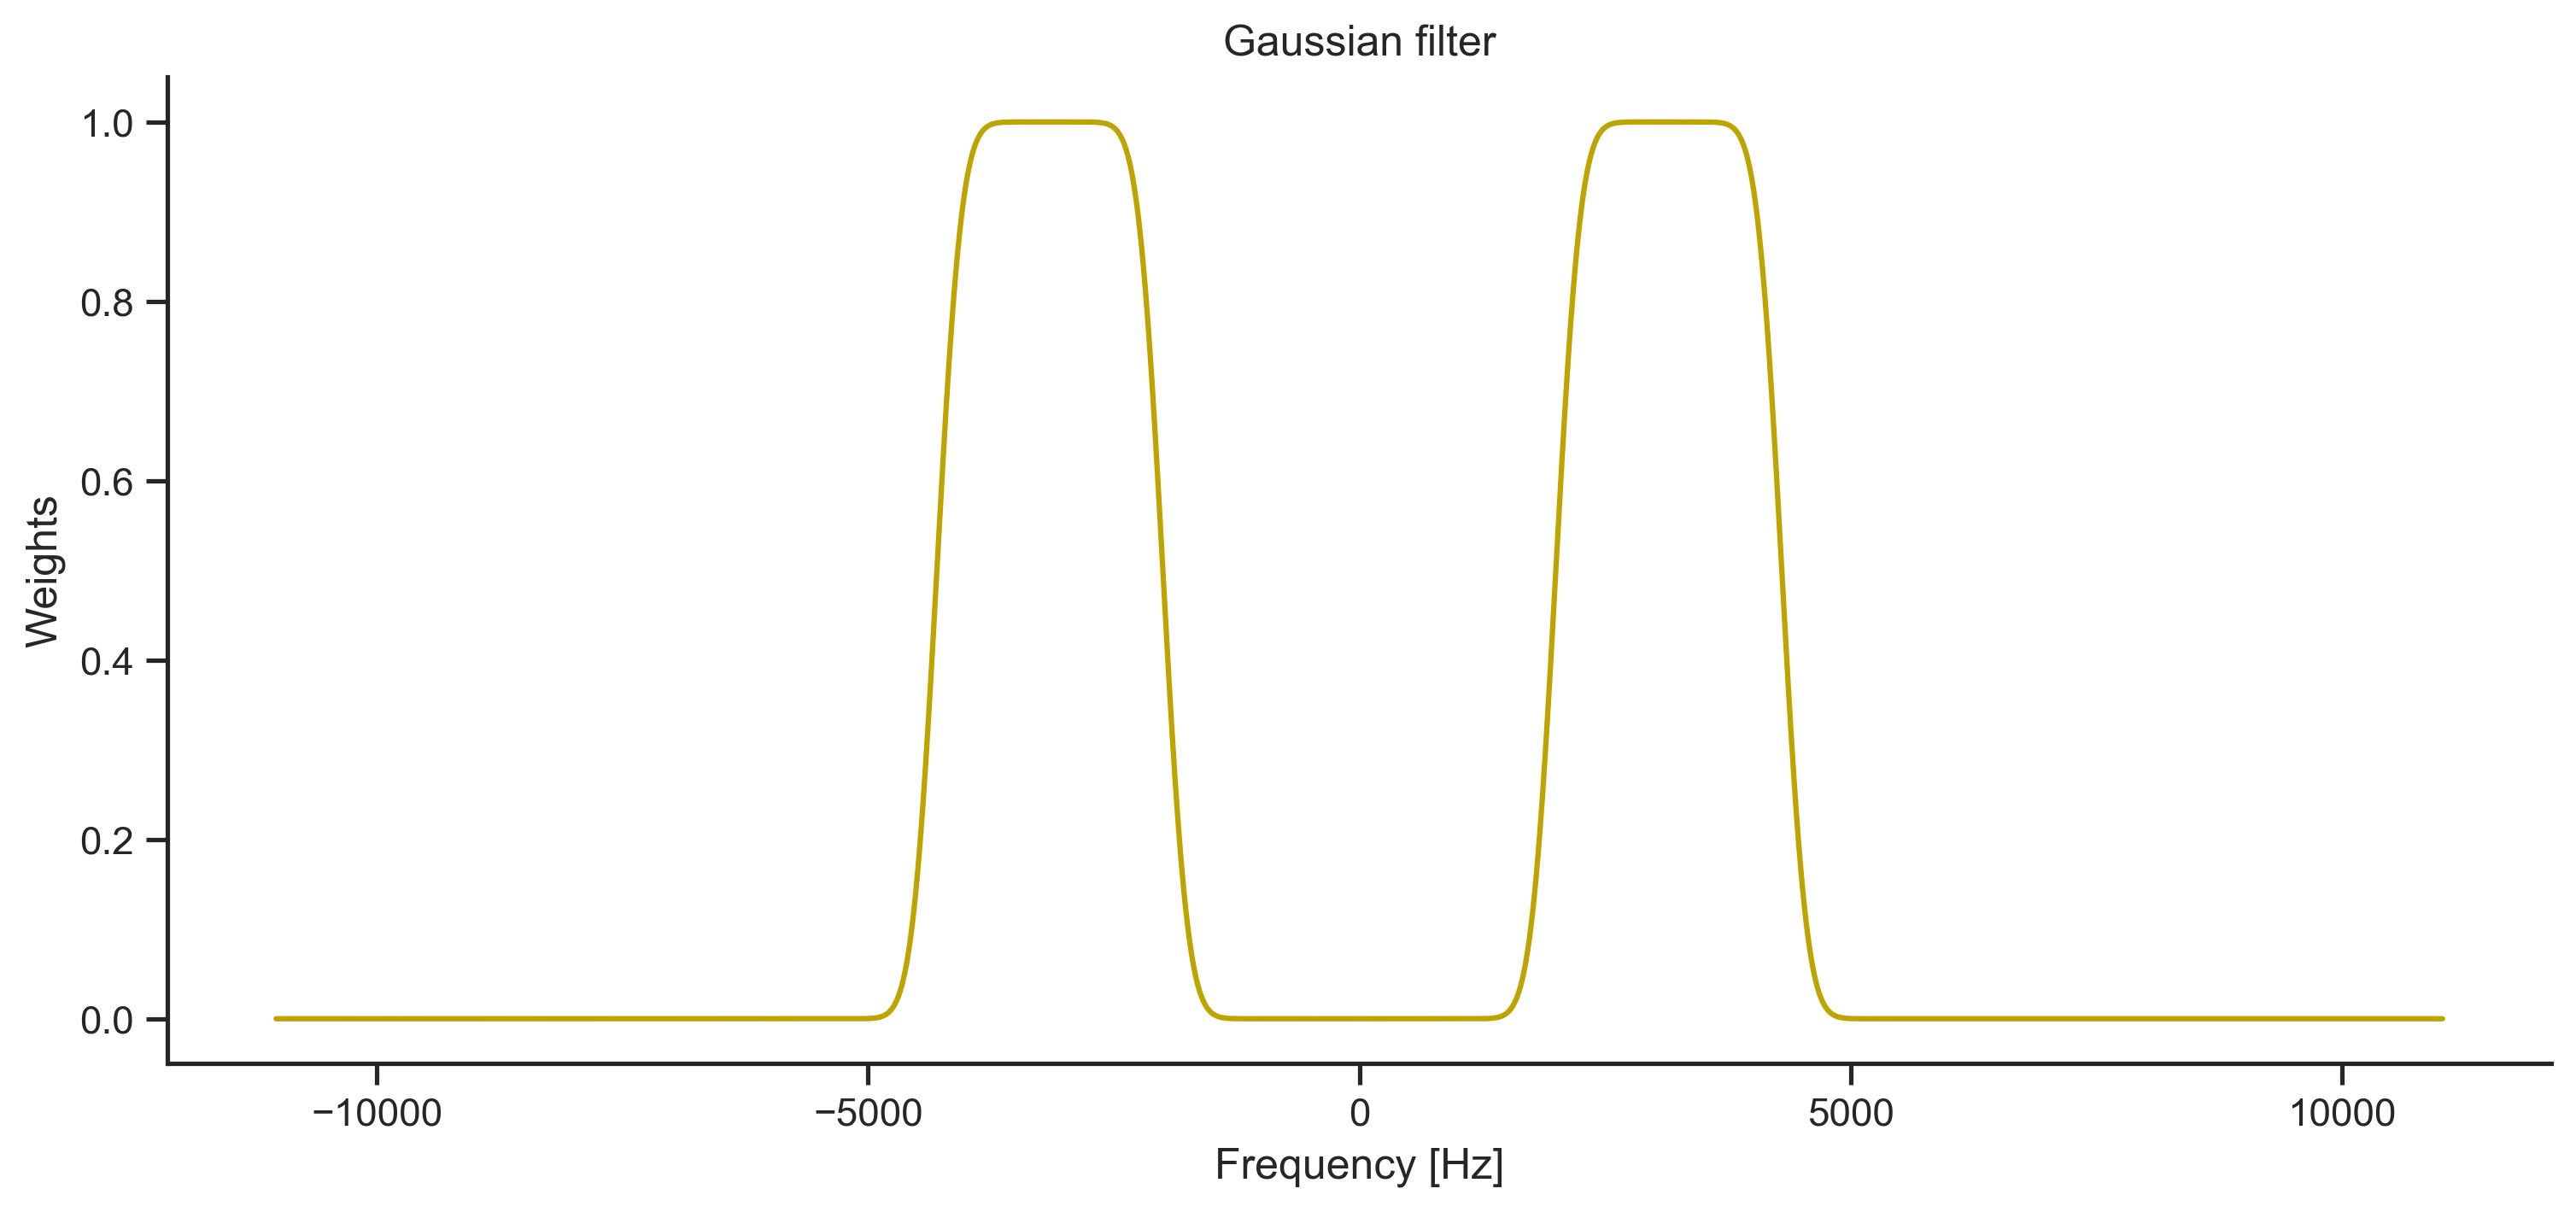

In [64]:
gaussian_filter = np.convolve(weights,y,"same")
gaussian_filter = gaussian_filter/np.max(gaussian_filter) # Normalised the weights s.t. the maximum weight = 1
print('Result size:', gaussian_filter.size)

plt.figure(figsize=(12, 5))
plt.plot(real_freqs, gaussian_filter, color = "#BEA400")
plt.title("Gaussian filter")
plt.ylabel('Weights')
plt.xlabel('Frequency [Hz]')
sns.despine()
plt.show()

### Frequency spectra

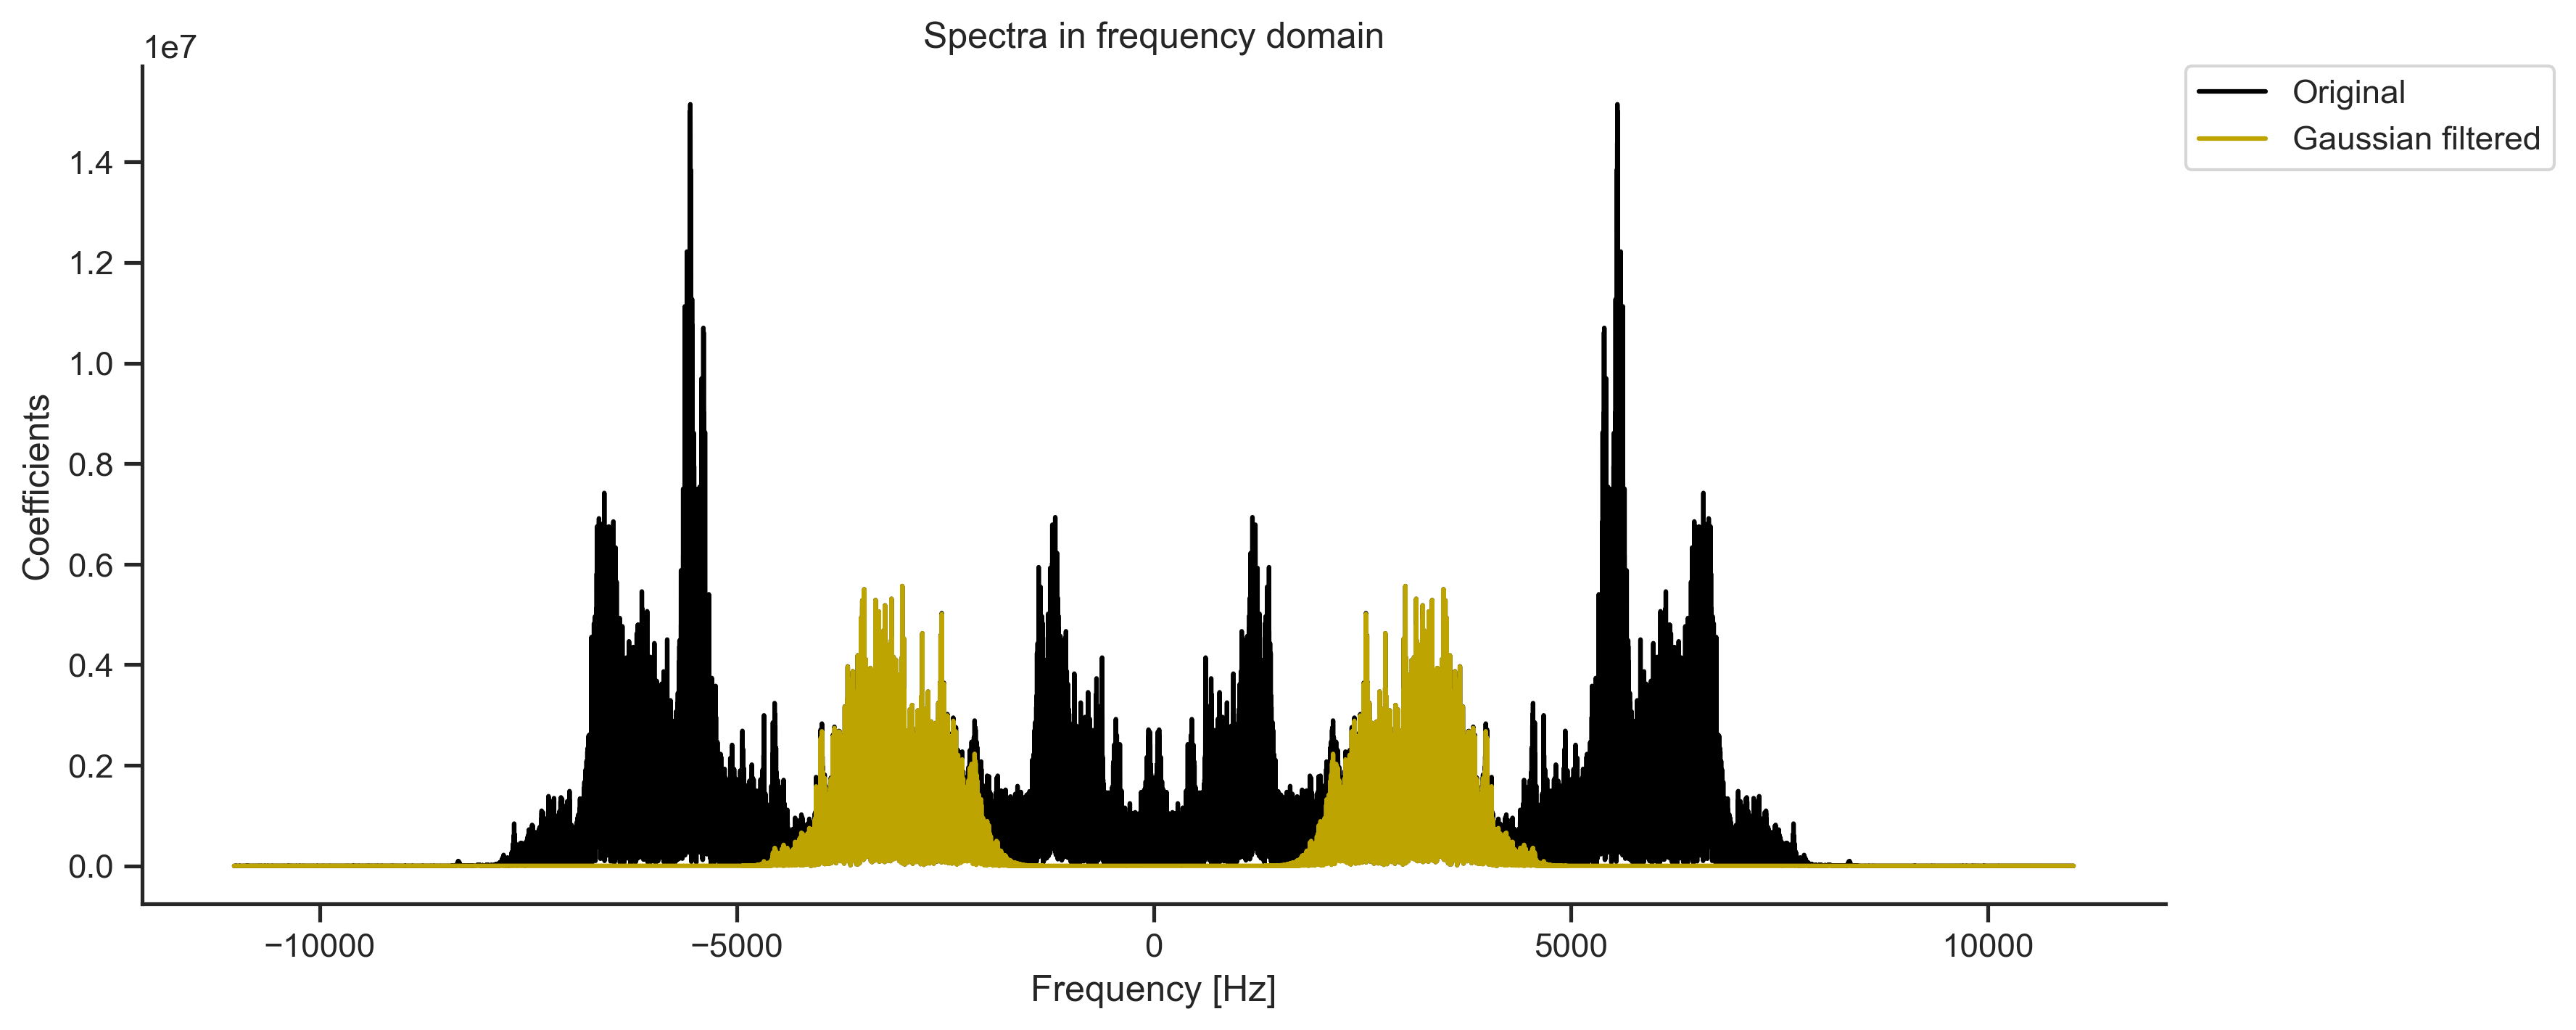

In [67]:
data_fft = fftshift(fft(data))
data_fft_gaussian_filtered = data_fft*gaussian_filter

plt.figure(figsize=(12, 5))
sns.lineplot(x = real_freqs, y = np.abs(data_fft), label = 'Original', color = "#000000")
sns.lineplot(x = real_freqs, y = np.abs(data_fft_gaussian_filtered), label = 'Gaussian filtered', color = "#BEA400")
plt.ylabel('Coefficients')
plt.xlabel('Frequency [Hz]')
sns.despine()
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.0, frameon = True)
plt.title("Spectra in frequency domain")
plt.show()

### Time signals

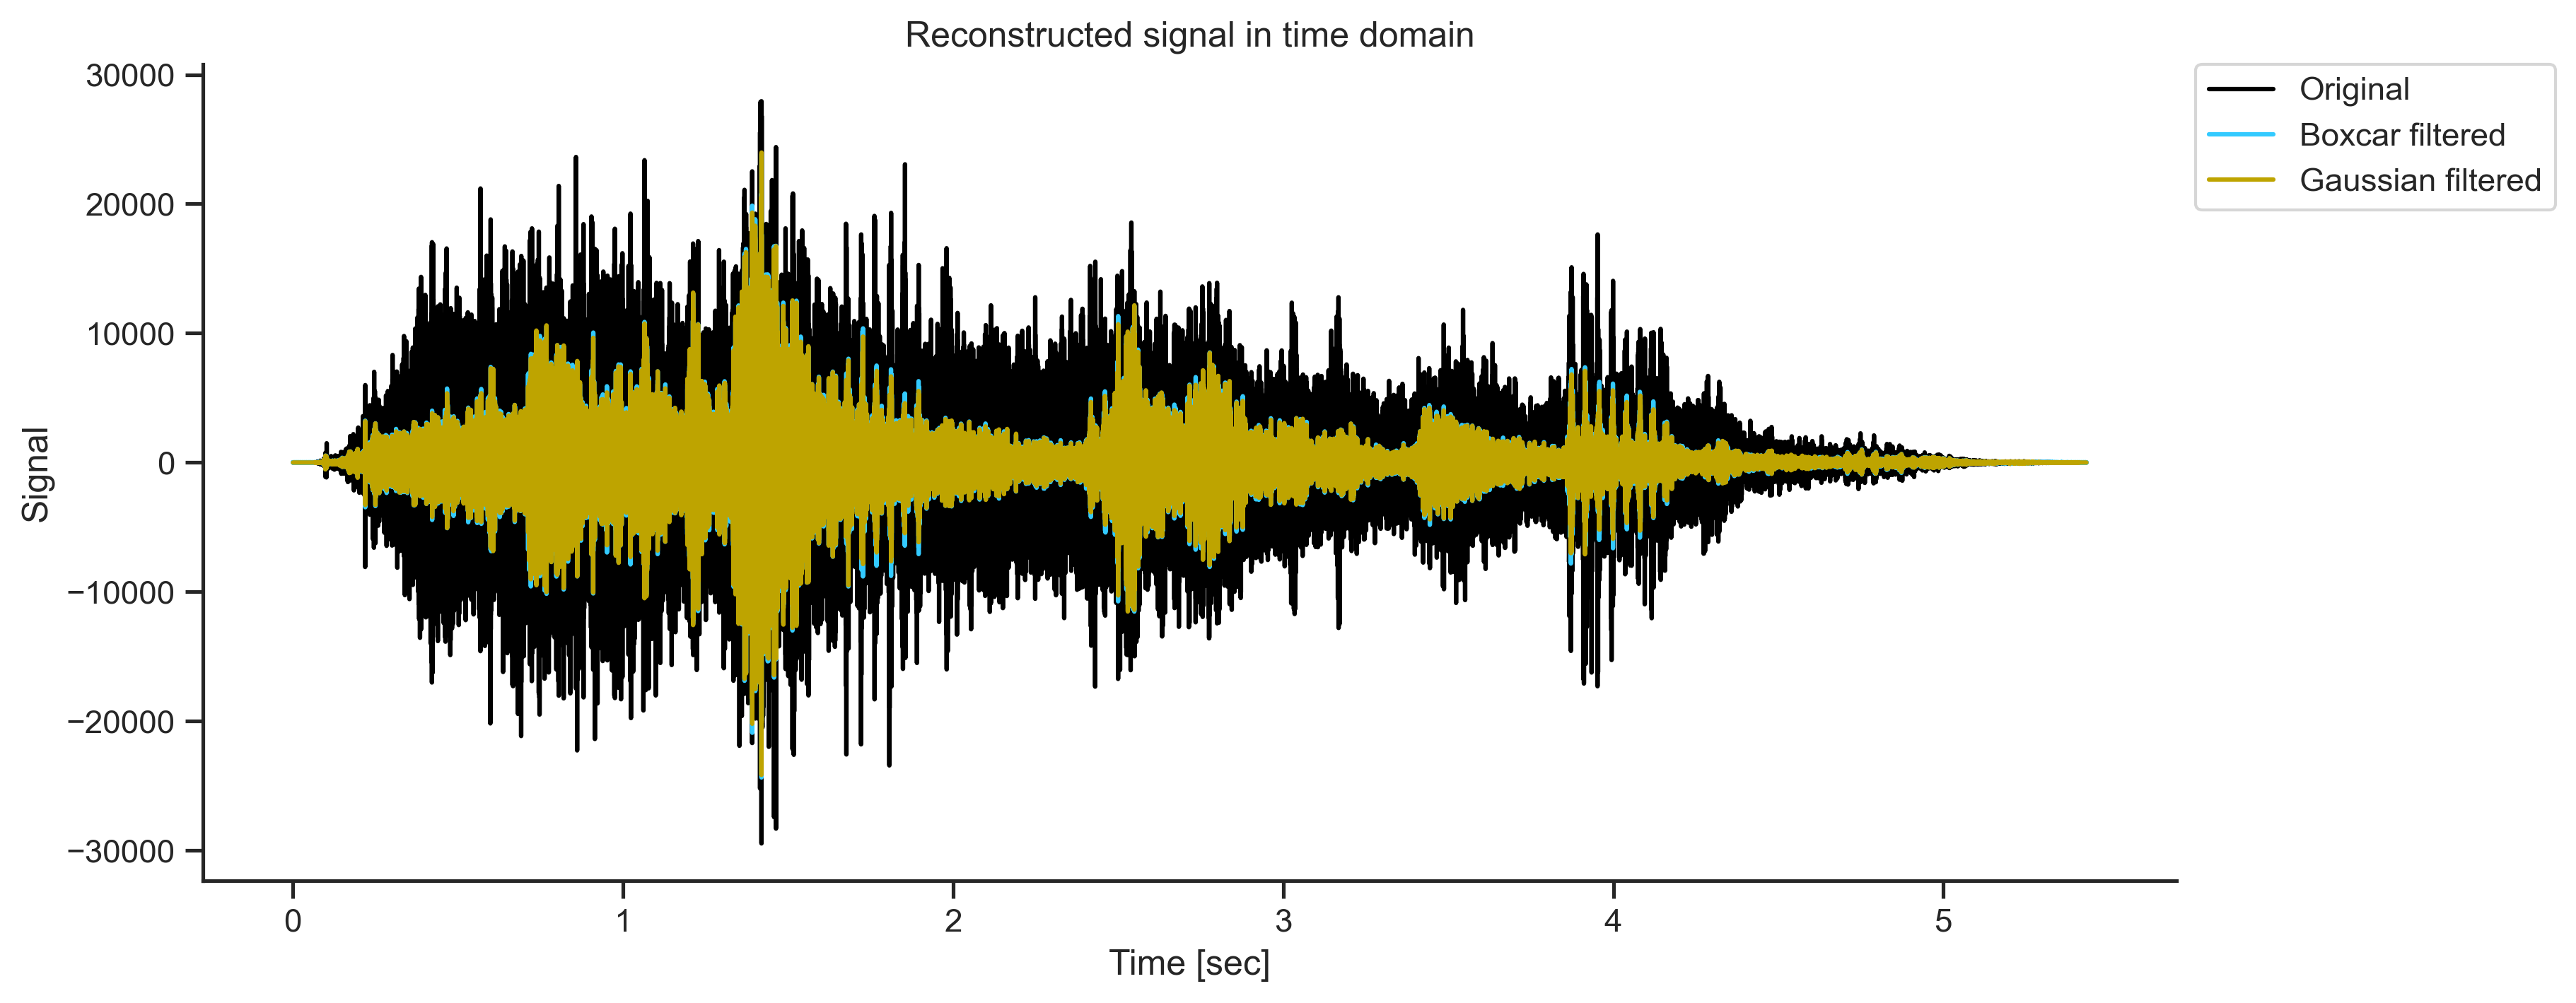

In [73]:
second_animal_sound_gaussian = ifft(ifftshift(data_fft_gaussian_filtered))
second_animal_sound_gaussian = second_animal_sound_gaussian.real

plt.figure(figsize=(12, 5))
plt.plot(x,data, label ='Original', color = "#000000")
plt.plot(x,second_animal_sound, label = 'Boxcar filtered', color = "#33CAFF")
plt.plot(x,second_animal_sound_gaussian, label = 'Gaussian filtered', color = "#BEA400")
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.0, frameon = True)
plt.xlabel('Time [sec]')
plt.ylabel('Signal')
plt.title("Reconstructed signal in time domain")
sns.despine()
plt.show()

## Isolate the second animal sound (using Gaussian filter)

In [70]:
ipd.Audio(second_animal_sound_gaussian, rate = sample_rate) # load a local WAV file

## Visualise the spectrogram of the second animal sound (Boxcar VS Butterworth order 10 VS Gaussian)

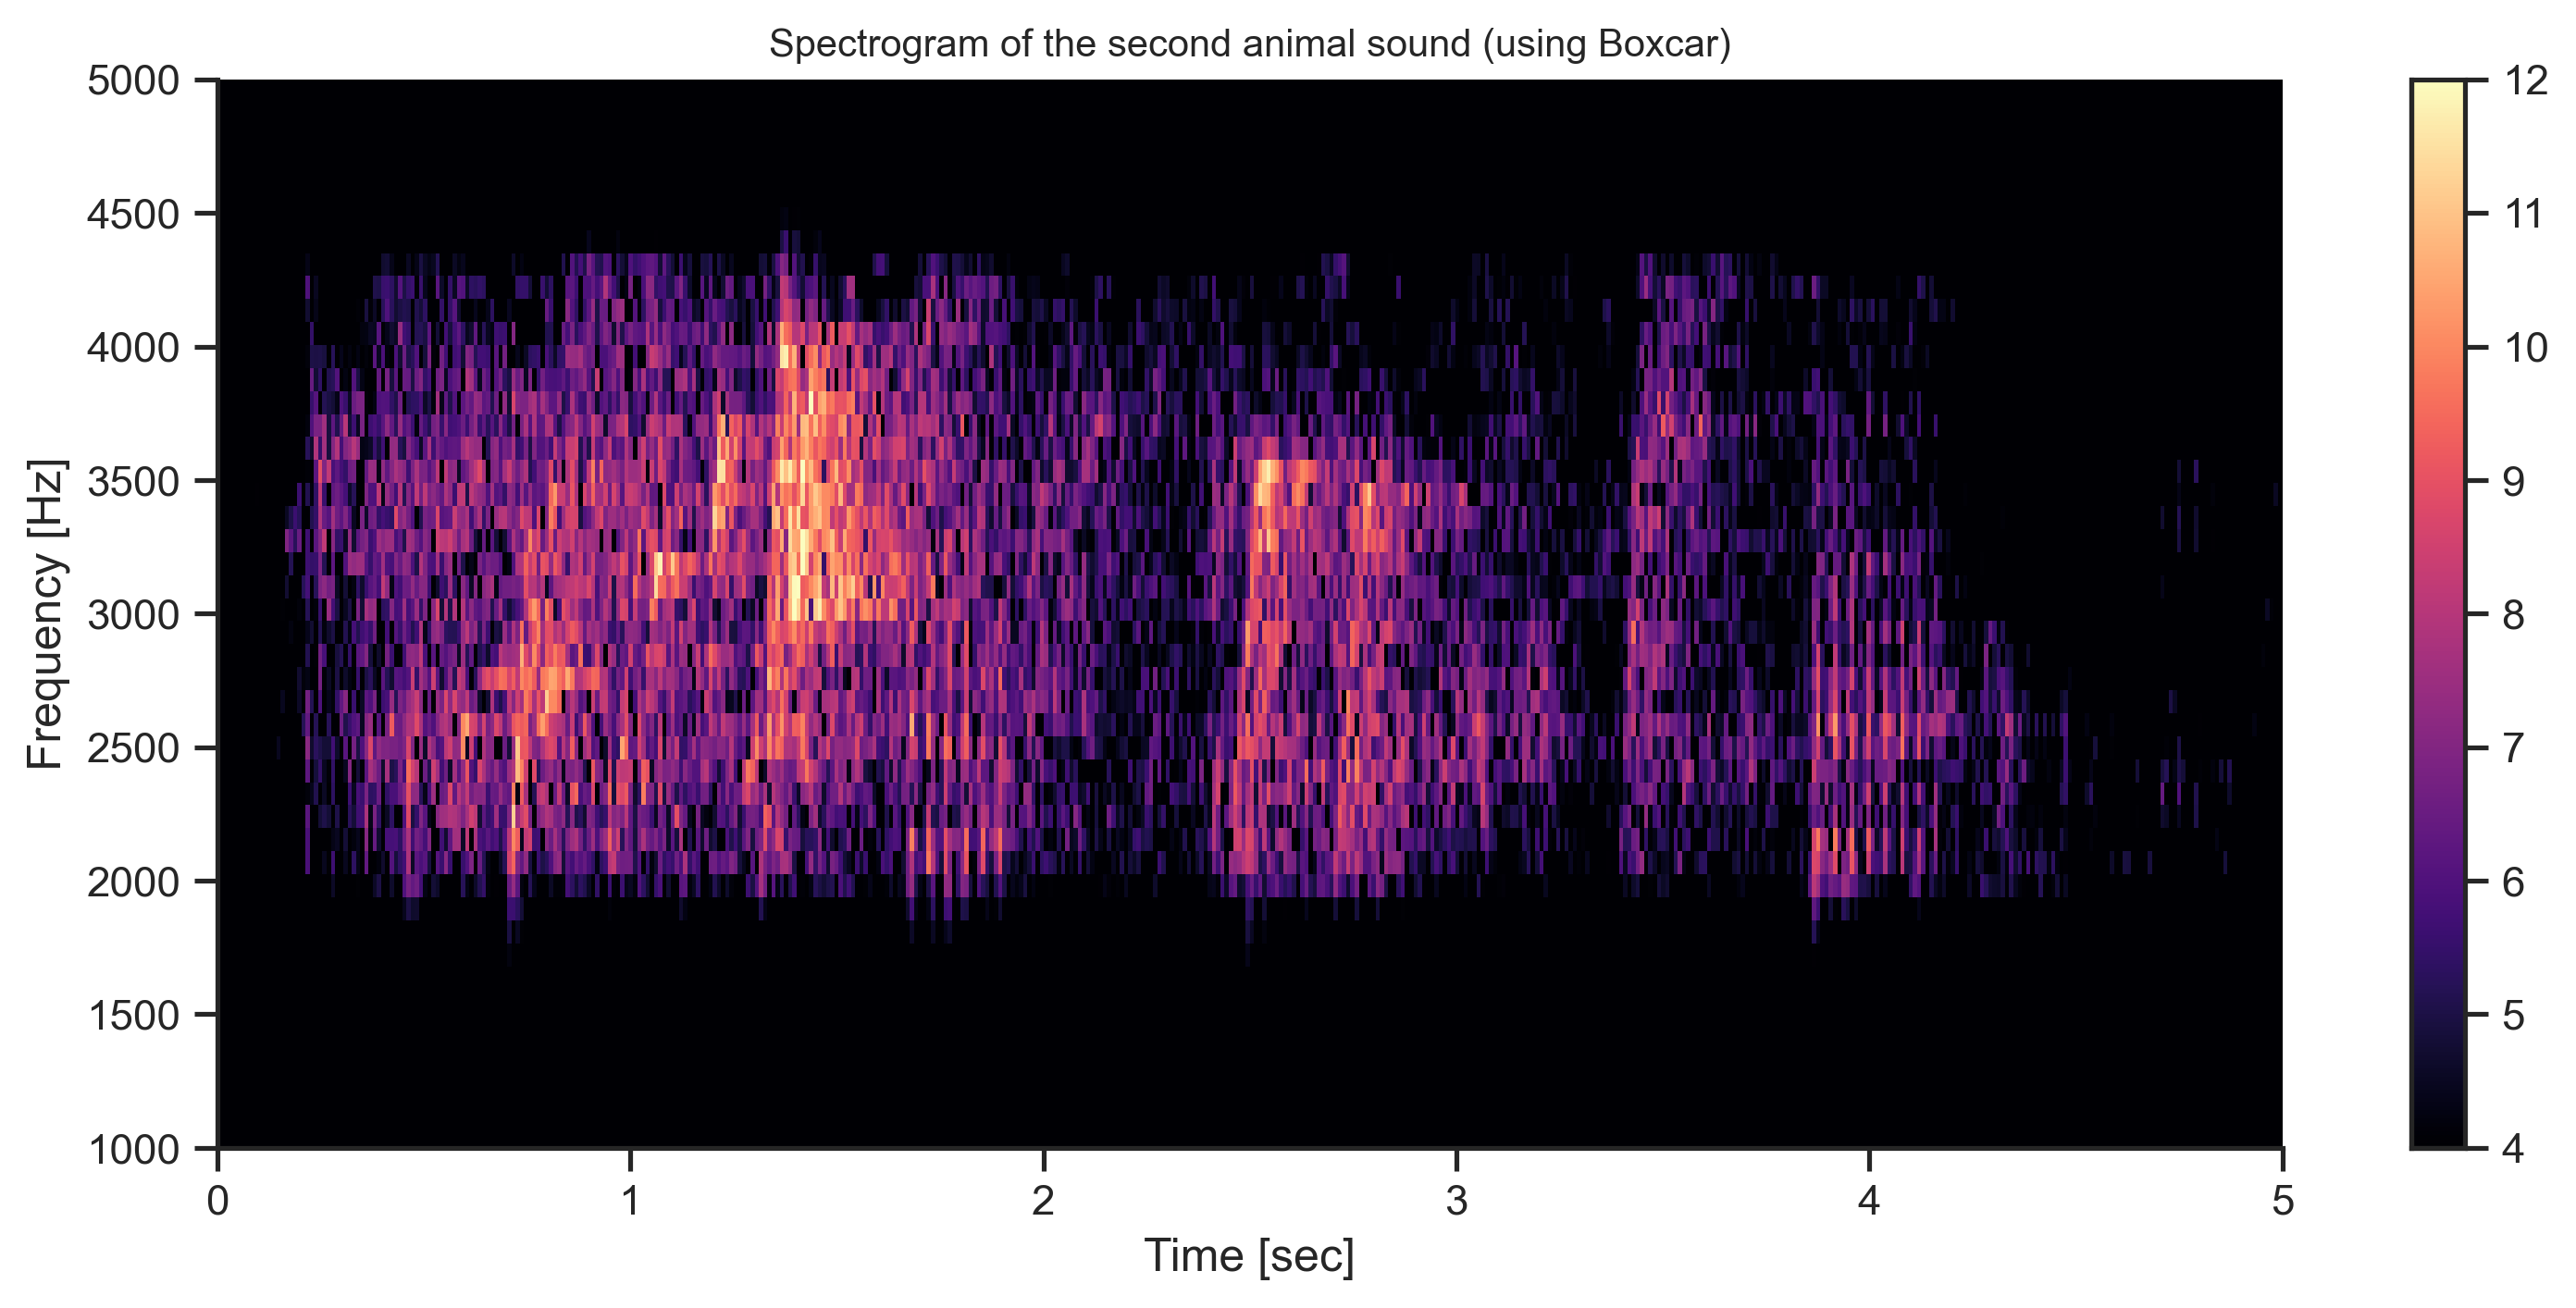

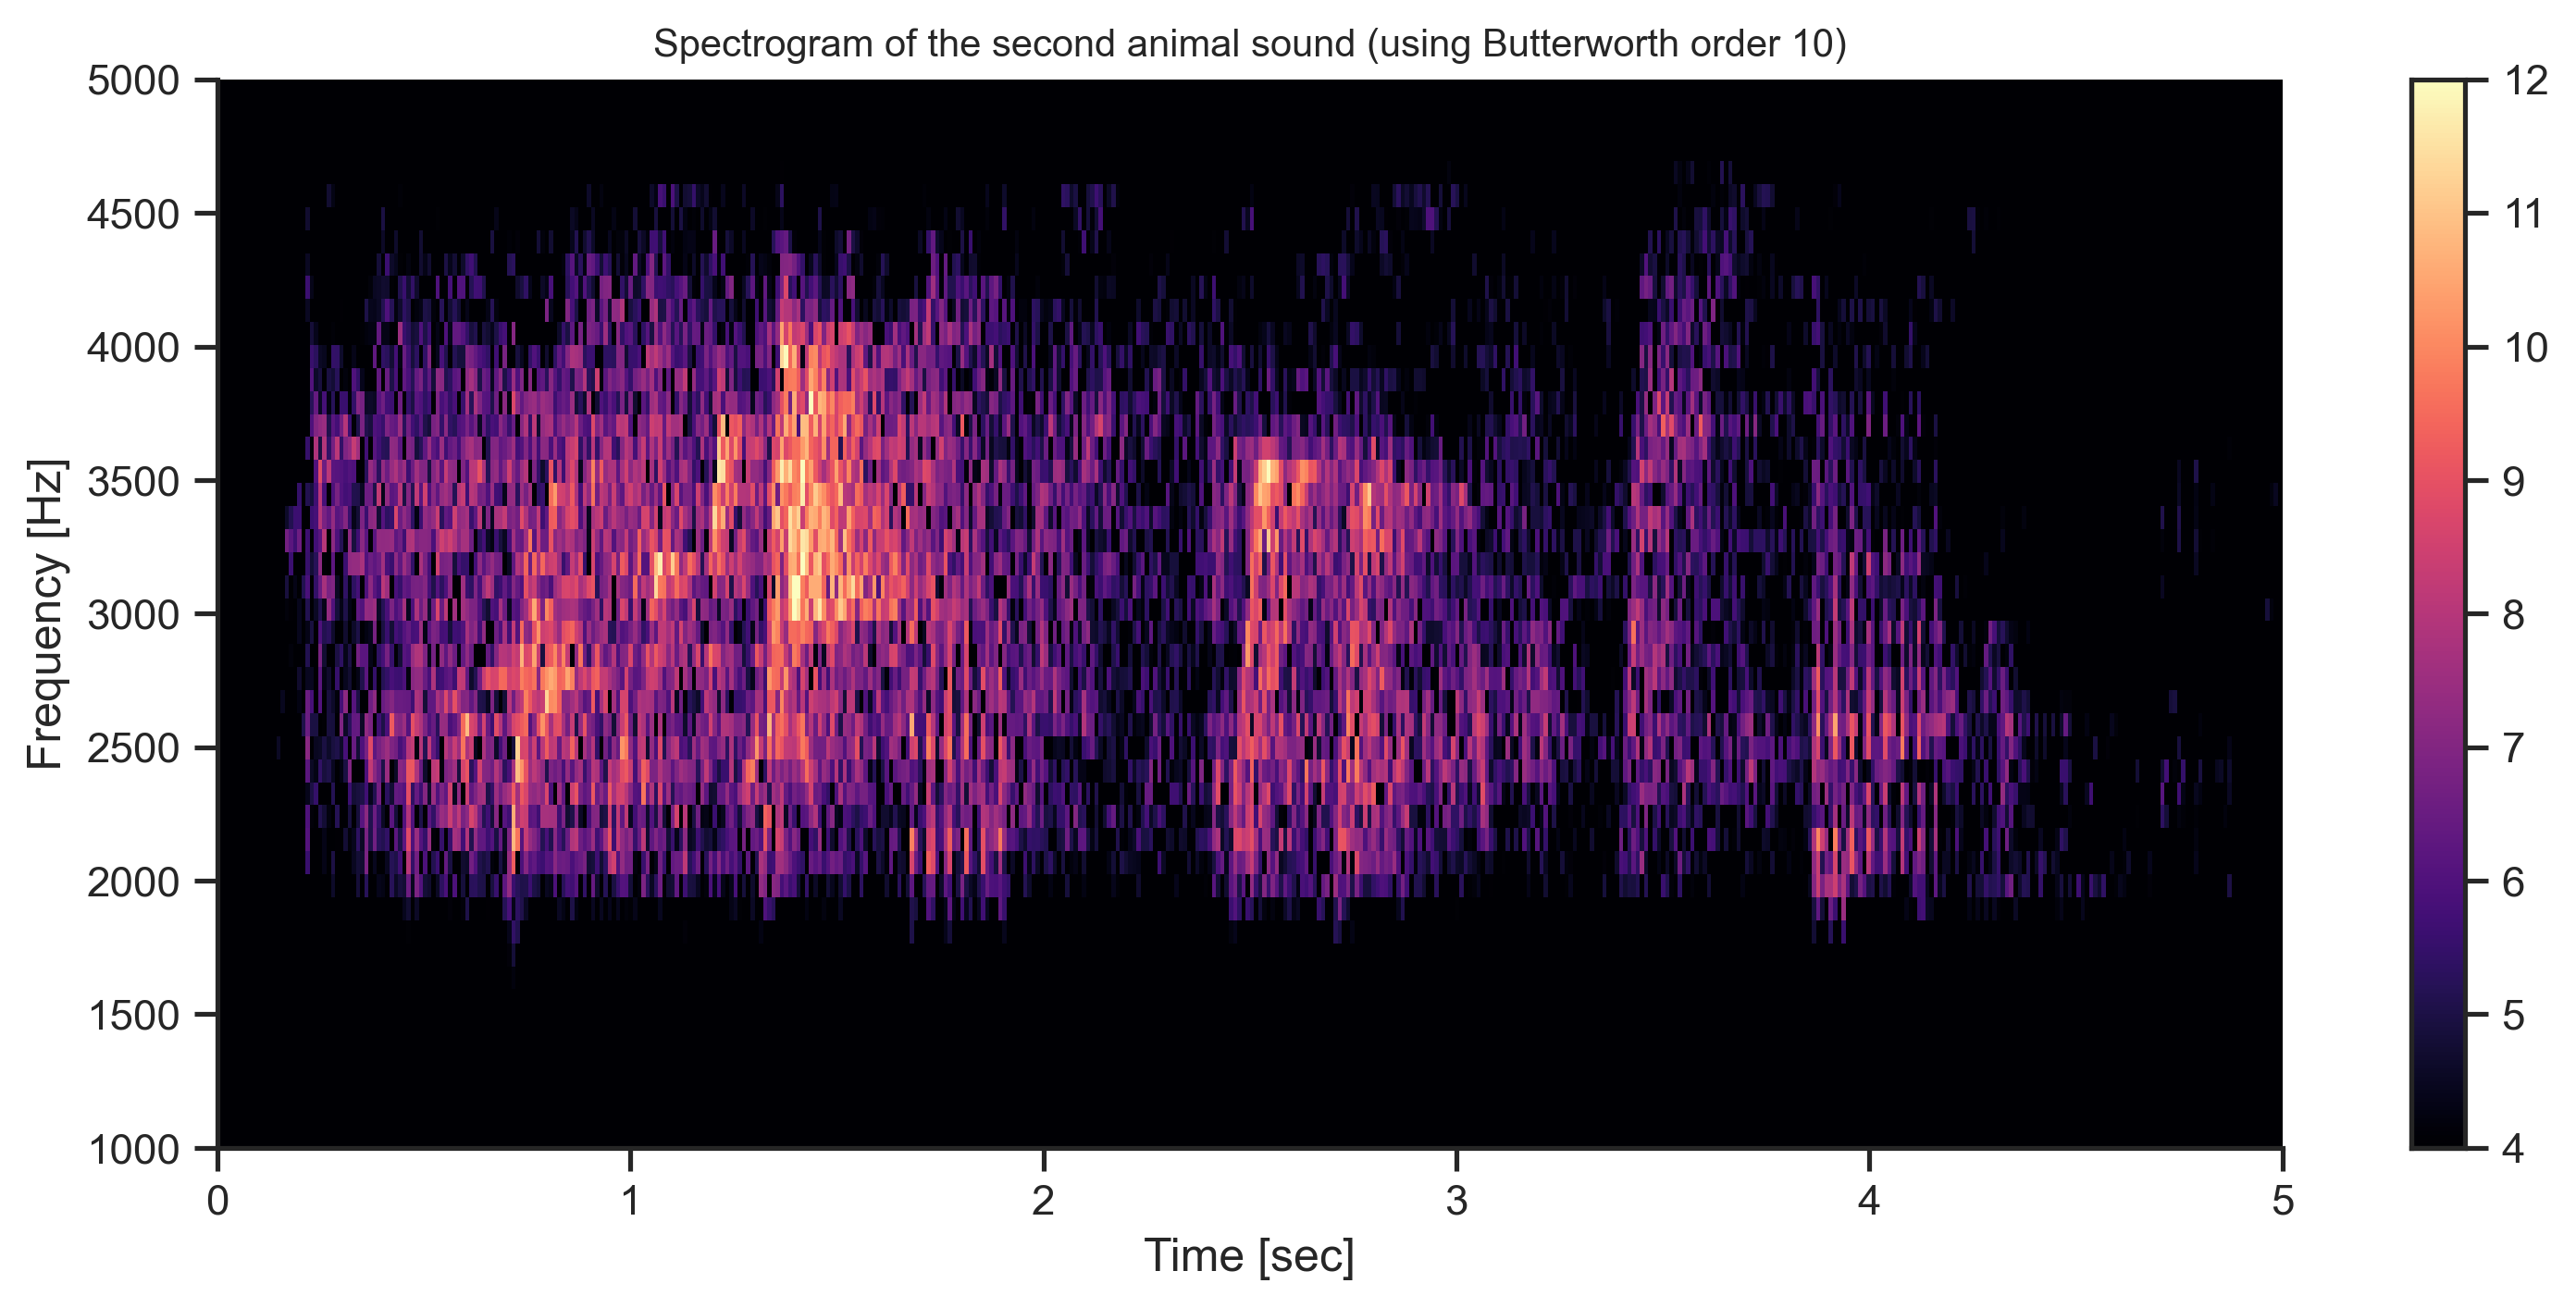

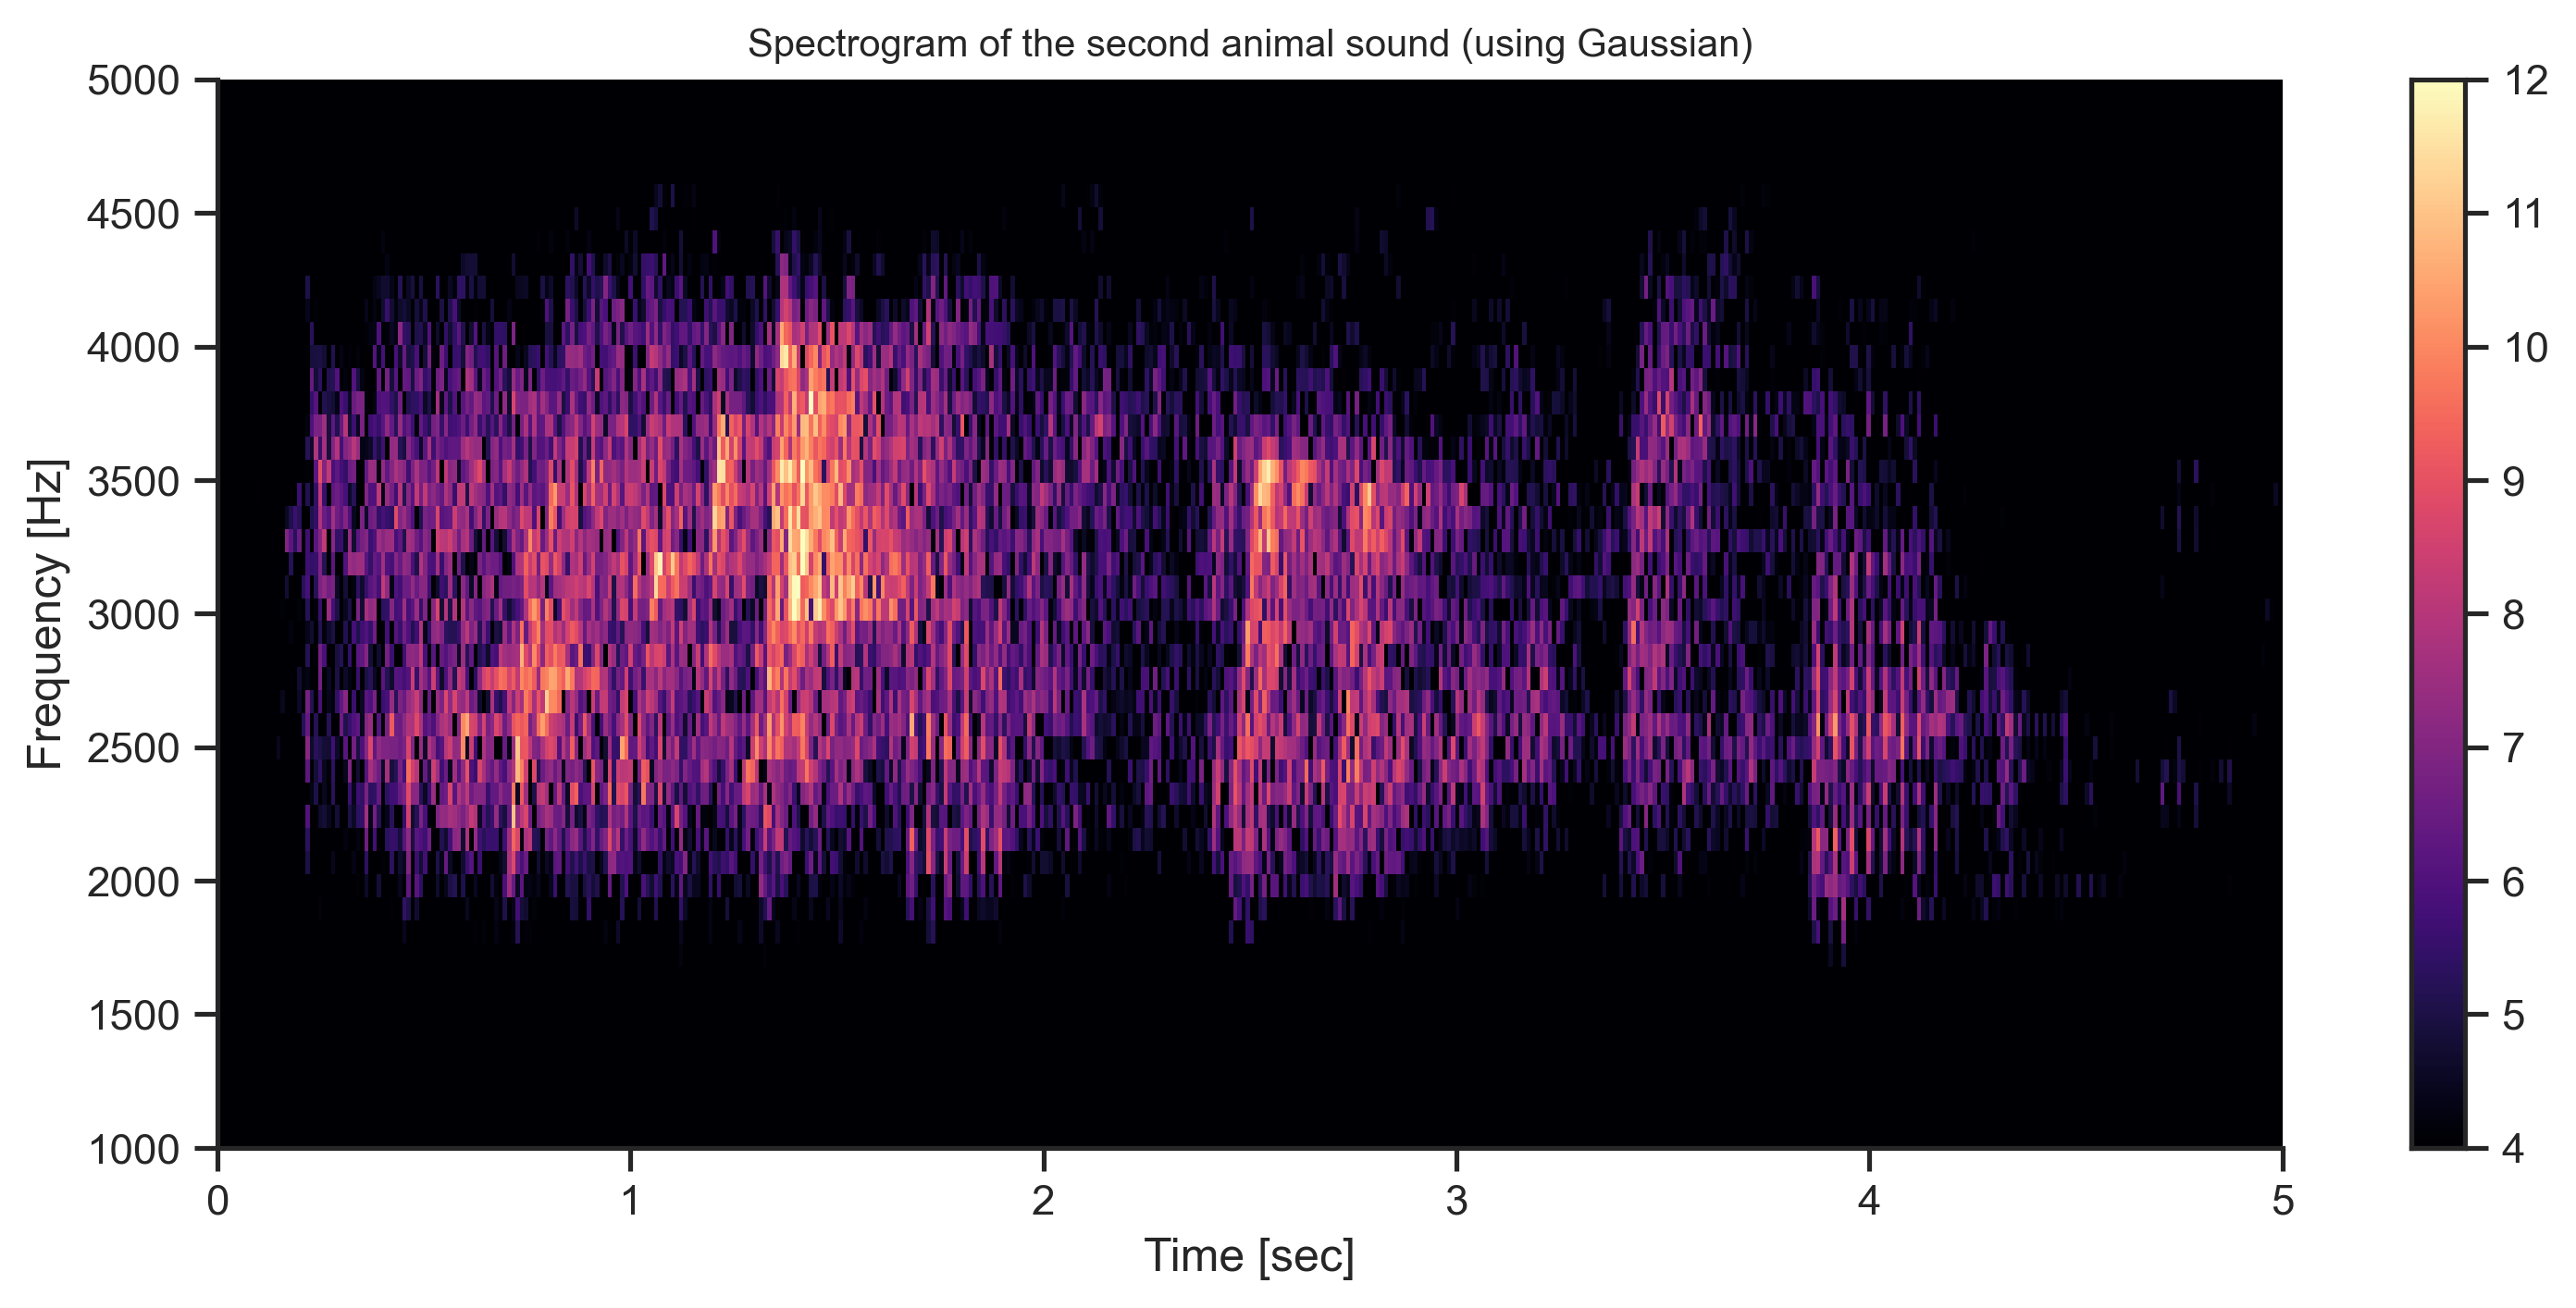

In [72]:
f, t, Sxx = signal.spectrogram(second_animal_sound, sample_rate)
plt.figure(figsize=(12, 5))
plt.pcolormesh(t, f, np.log(Sxx), cmap = 'magma', vmin = 4, vmax = 12)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.ylim(1000,5000)
plt.xlim(0,5)
plt.title("Spectrogram of the second animal sound (using Boxcar)", fontsize=10)
sns.despine()
plt.show()

f, t, Sxx = signal.spectrogram(second_animal_sound_butterworth, sample_rate)
plt.figure(figsize=(12, 5))
plt.pcolormesh(t, f, np.log(Sxx), cmap = 'magma', vmin = 4, vmax = 12)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.ylim(1000,5000)
plt.xlim(0,5)
plt.title("Spectrogram of the second animal sound (using Butterworth order 10)", fontsize=10)
sns.despine()
plt.show()

f, t, Sxx = signal.spectrogram(second_animal_sound_gaussian, sample_rate)
plt.figure(figsize=(12, 5))
plt.pcolormesh(t, f, np.log(Sxx), cmap = 'magma', vmin = 4, vmax = 12)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.ylim(1000,5000)
plt.xlim(0,5)
plt.title("Spectrogram of the second animal sound (using Gaussian)", fontsize=10)
sns.despine()
plt.show()